# Mutational antigenic profiling of WSN HA with FI6v3, S139/1, C179, and H17-L19

Experiments and data analysis by Mike Doud, Juhye Lee, and Jesse Bloom.

## Overview

We performed mutational antigenic profiling of three broadly neutralizing monoclonal antibodies, **FI6v3**, **S139/1**, and **C179**, that target influenza hemagglutinin. We used mutant virus libraries of the A/WSN/1933 (H1N1) HA using the procedure described in [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271). We are also including analysis of the monoclonal antibody **H17-L19**, previously profiled in Doud, Hensley, and Bloom (2017).

## Experimental summary

We selected three biological replicate mutant virus libraries carrying mutant HA's with different neutralizing concentrations of FI6v3, S139/1, C179, or H17-L19 (performed previously). We then infected cells with the neutralized viruses, extracted RNA from the infected cells, reverse-transcribed and amplified the extracted RNA, and deep sequenced the libraries using a barcoded-subamplicon approach.

In this analysis, we examine deep sequencing data from these antibody selections and evaluate amino-acid mutations that enable escape from each of these four antibodies.

# Import modules, define directories

In [1]:
import os
import glob
import math
import time
import pandas as pd
import numpy as np
from colour import Color
from pymodules.utils import * # custom modules for this analysis
import matplotlib
import matplotlib.lines as mlines
matplotlib.use('Pdf')
print('Using matplotlib version {0}'.format(matplotlib.__version__))
from matplotlib.ticker import MaxNLocator
import pylab as plt
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.diffsel
from dms_tools2.ipython_utils import showPDF

print('Using dms_tools2 version {0}'.format(dms_tools2.__version__))

# define directories
inputdir = './data/' 

resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)

countsdir = os.path.join(resultsdir, 'codoncounts/')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)

diffseldir = os.path.join(resultsdir, 'differential_selections/')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

plotsdir = os.path.join(resultsdir, 'plots/')
if not os.path.isdir(plotsdir):
    os.mkdir(plotsdir)

fracsurvivedir = os.path.join(resultsdir, 'fracsurvive/')
if not os.path.isdir(fracsurvivedir):
    os.mkdir(fracsurvivedir)

pymoldir = os.path.join(resultsdir, 'pymol/')
if not os.path.isdir(pymoldir):
    os.mkdir(pymoldir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 4 

# do we use existing results or generate everything new?
use_existing = 'yes'

/home/jmlee34/.local/lib/python3.4/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Using matplotlib version 2.0.2


/app/python3/3.4.1/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


Using dms_tools2 version 2.1a0


# Define the samples

This is a `csv` of the samples that we are going to analyze.
We will read the `csv` into a pandas dataframe that lists the sample names with the following associating information: 
1. SRA run number
2. the antibody used for selection (`none` for mock selections and WT plasmid control)
3. the concentration (ug/ml) of antibody used to neutralize the libraries
4. the % infectivity after neutralization, as estimated by qPCR

In [42]:
exptsdf = pd.read_csv('./data/samples.csv')

In [43]:
display(HTML(exptsdf.to_html(index=False)))

name,run,antibody,ug/ml_Ab,libfracsurvive
L1-FI6v3-100ng-ml-r1,SRR5930379,FI6v3,0.1,0.01662
L1-FI6v3-100ng-ml-r2,SRR5930376,FI6v3,0.1,0.01390
L1-FI6v3-200ng-ml-r1,SRR5930378,FI6v3,0.2,0.00465
L1-FI6v3-200ng-ml-r2,SRR5930383,FI6v3,0.2,0.00345
L2-FI6v3-100ng-ml,SRR5930381,FI6v3,0.1,0.02322
L2-FI6v3-200ng-ml,SRR5930380,FI6v3,0.2,0.00278
L3-FI6v3-100ng-ml,SRR5930384,FI6v3,0.1,0.00903
L3-FI6v3-200ng-ml,SRR5930375,FI6v3,0.2,0.00144
L1-S139-100ug-ml,SRR6116992,S139,100.0,0.02490
L1-S139-200ug-ml,SRR6116993,S139,200.0,0.01470


# Download `FASTQ` files from the SRA
These `FASTQ` files will be stored in `fastqdir`.

First we define a dataframe called `samples` which extracts the sample name and the associated SRA run from `exptsdf`.

In [44]:
samples = exptsdf[['name', 'run']].copy()

In [47]:
print('Downloading FASTQ files from the SRA...')
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            )
        )
print('Completed download of FASTQ files from the SRA')

Completed download of FASTQ files from the SRA


# Align the deep sequencing data and count mutations

We used a barcoded-subamplicon sequencing approach to prep and deep sequence the libraries to high accuracy, as described in [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271). 
We will now align the deep sequencing reads using `dms2_batch_bcsubamp`.

It is also worth noting that we have specified trimming parameters for Read 1 and Read 2. Because different sets of samples were sequenced on different Illumina runs, these trimming parameters differ across the samples

In [33]:
# Specify global alignment parameters
# file containing wildtype WSN HA sequence
refseq = './data/WSN_HA_reference.fa'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

In [34]:
# Specify trimming parameters
S139_R1trim = ' '.join(['190', '175', '175', '175', '190', '190'])
S139_R2trim = ' '.join(['180', '180', '180', '180', '190', '190'])

def trimparam_R1(row):
    if 'S139' in row['name']:
        return S139_R1trim
    else:
        return 200
    
def trimparam_R2(row):
    if 'S139' in row['name']:
        return S139_R2trim
    else:
        return 170
    
samples['R1trim'] = samples.apply(trimparam_R1, axis=1)
samples['R2trim'] = samples.apply(trimparam_R2, axis=1)

In [35]:
# Alignments for all samples
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1', 'R1trim', 'R2trim']].to_html(index=False)))
samples[['name', 'R1', 'R1trim', 'R2trim']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}
        
print('Completed dms2_batch_bcsubamp.')

Here is the batch file that we write to CSV format to use as input:


name,R1,R1trim,R2trim
L1-FI6v3-c1-r1,L1-FI6v3-c1-r1_R1.fastq.gz,200,170
L1-FI6v3-c1-r2,L1-FI6v3-c1-r2_R1.fastq.gz,200,170
L1-FI6v3-c2-r1,L1-FI6v3-c2-r1_R1.fastq.gz,200,170
L1-FI6v3-c2-r2,L1-FI6v3-c2-r2_R1.fastq.gz,200,170
L2-FI6v3-c1,L2-FI6v3-c1_R1.fastq.gz,200,170
L2-FI6v3-c2,L2-FI6v3-c2_R1.fastq.gz,200,170
L3-FI6v3-c1,L3-FI6v3-c1_R1.fastq.gz,200,170
L3-FI6v3-c2,L3-FI6v3-c2_R1.fastq.gz,200,170
L1-mock-r1-A,L1-mock-r1-A_R1.fastq.gz,200,170
L1-mock-r2-A,L1-mock-r2-A_R1.fastq.gz,200,170



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [36]:
countsplotprefix = os.path.join(countsdir, 'summary')

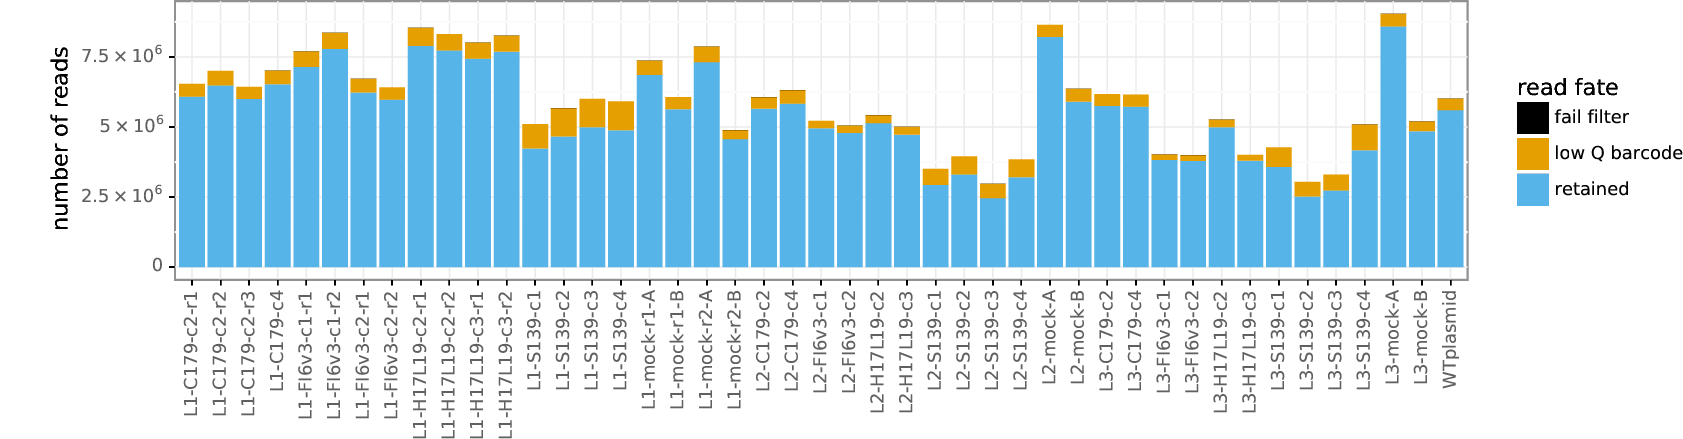

In [11]:
showPDF(countsplotprefix + '_readstats.pdf')

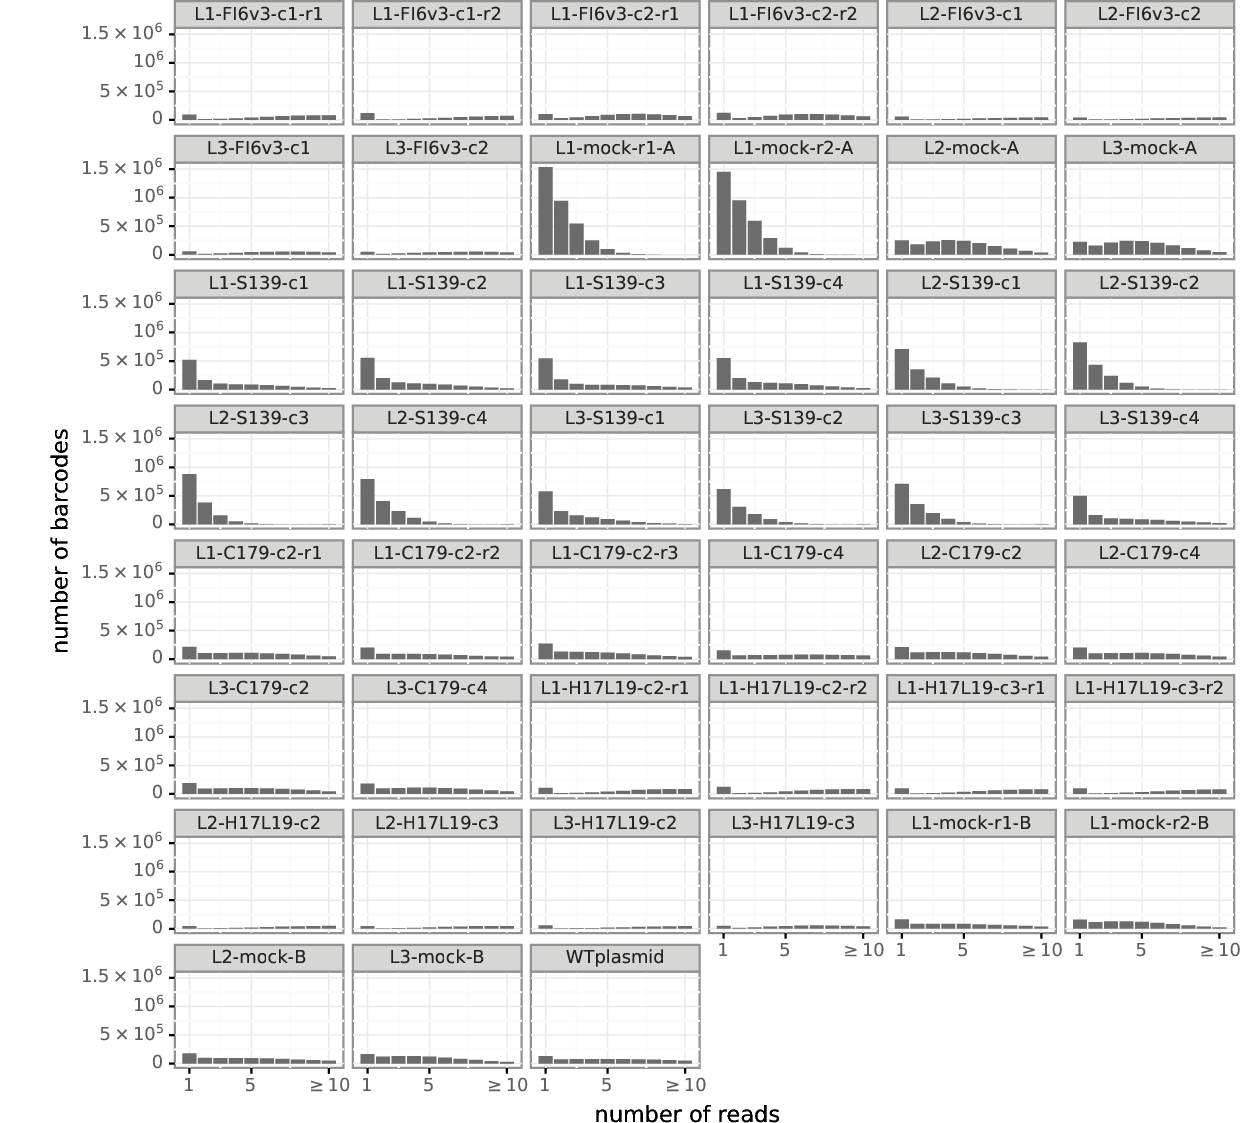

In [12]:
showPDF(countsplotprefix + '_readsperbc.pdf')

Overall read depth for the C179-associated samples is very good. Some of the S139-selected samples look like they are oversequenced, while others look like they could have been sequenced to greater depth. Mike's two L1mock samples also look a little undersequenced.

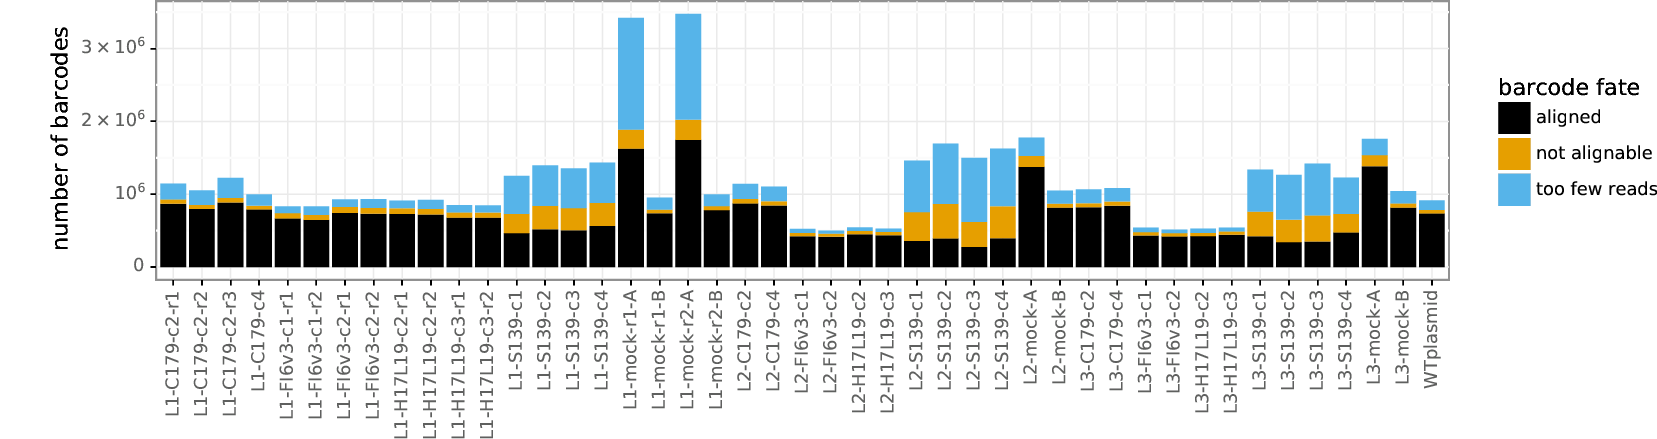

In [13]:
showPDF(countsplotprefix + '_bcstats.pdf')

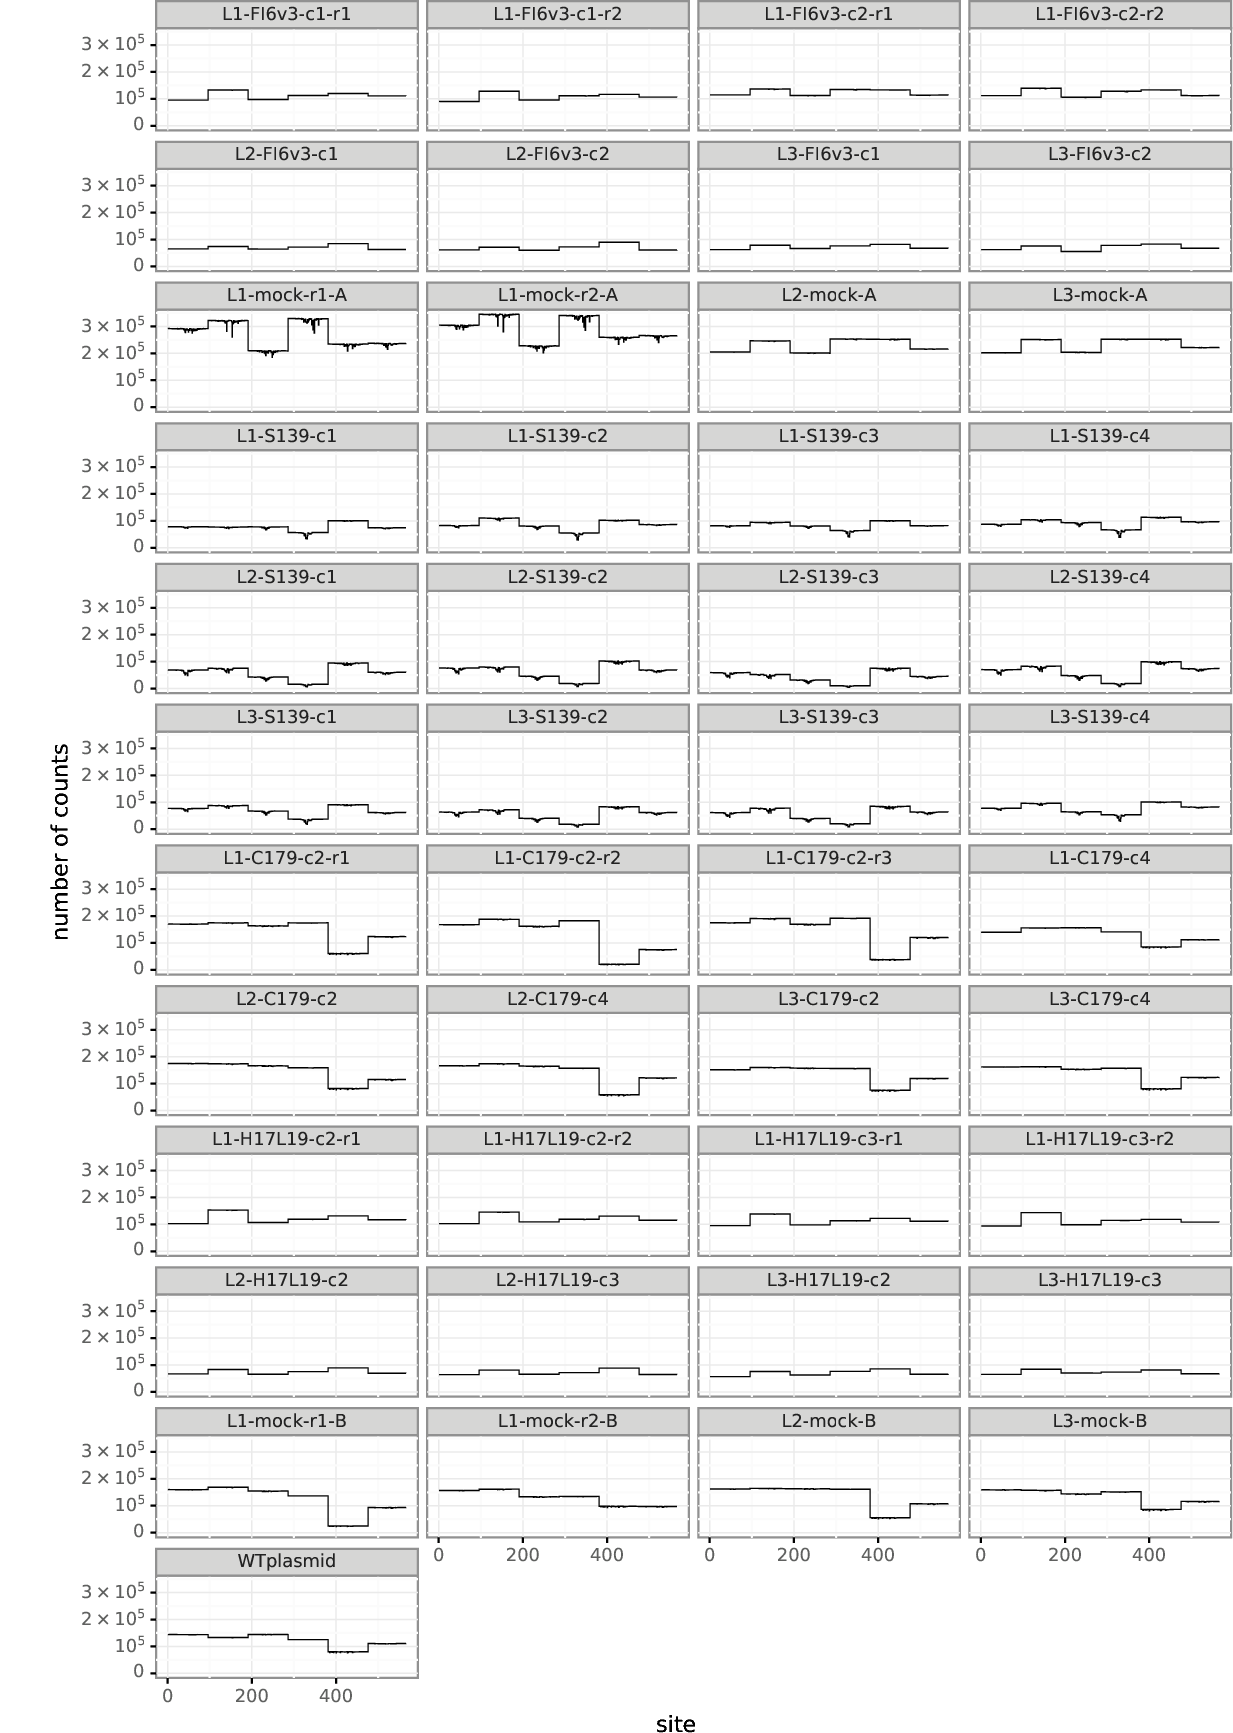

In [14]:
showPDF(countsplotprefix + '_depth.pdf')

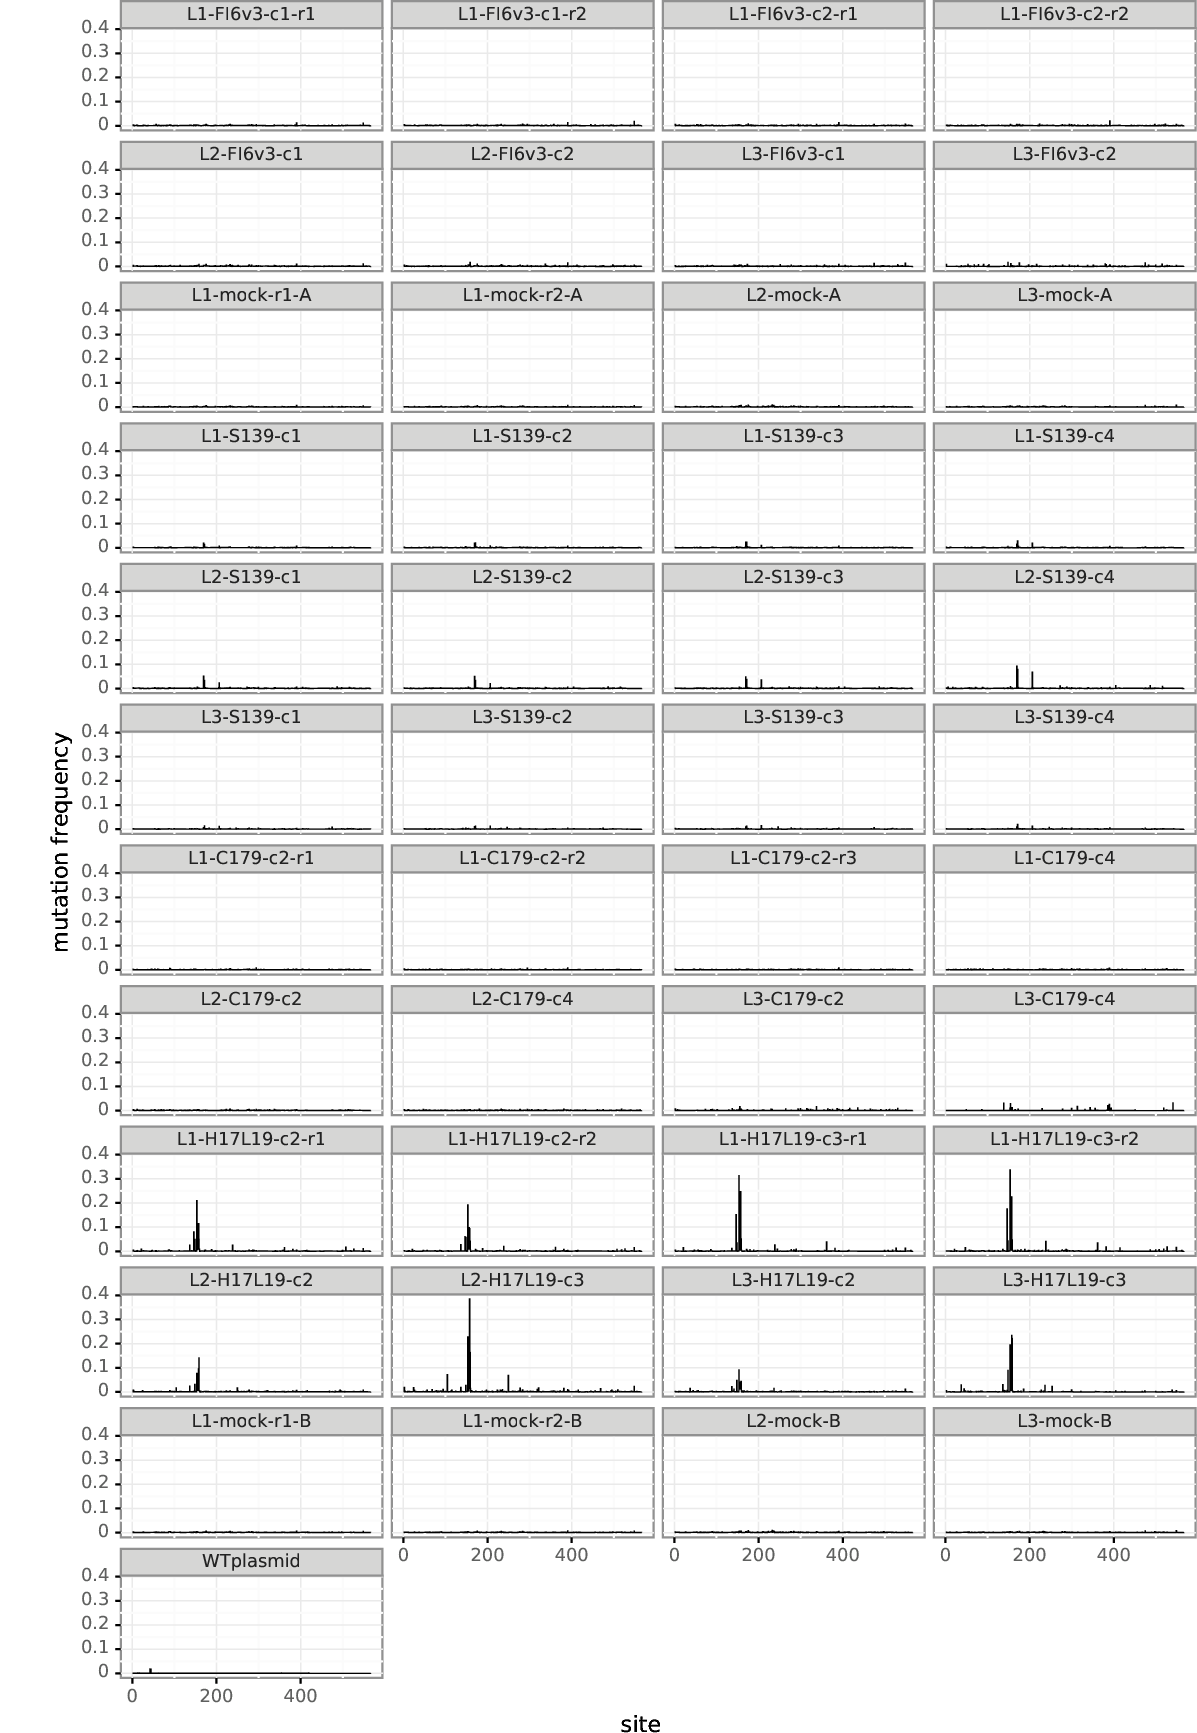

In [15]:
showPDF(countsplotprefix + '_mutfreq.pdf')

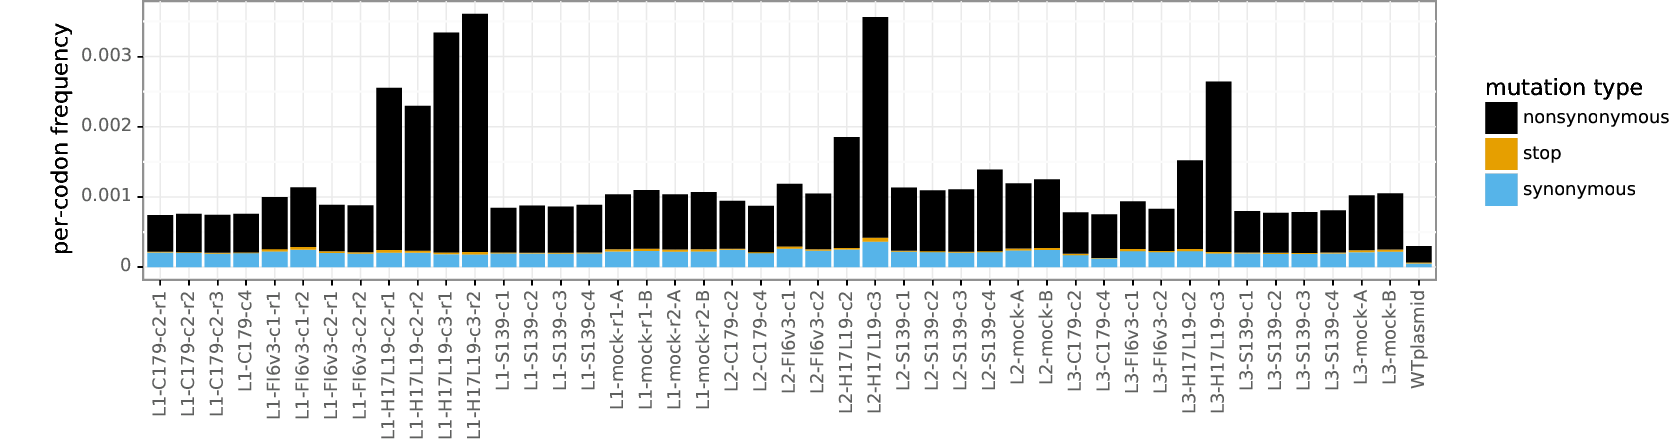

In [16]:
showPDF(countsplotprefix + '_codonmuttypes.pdf')

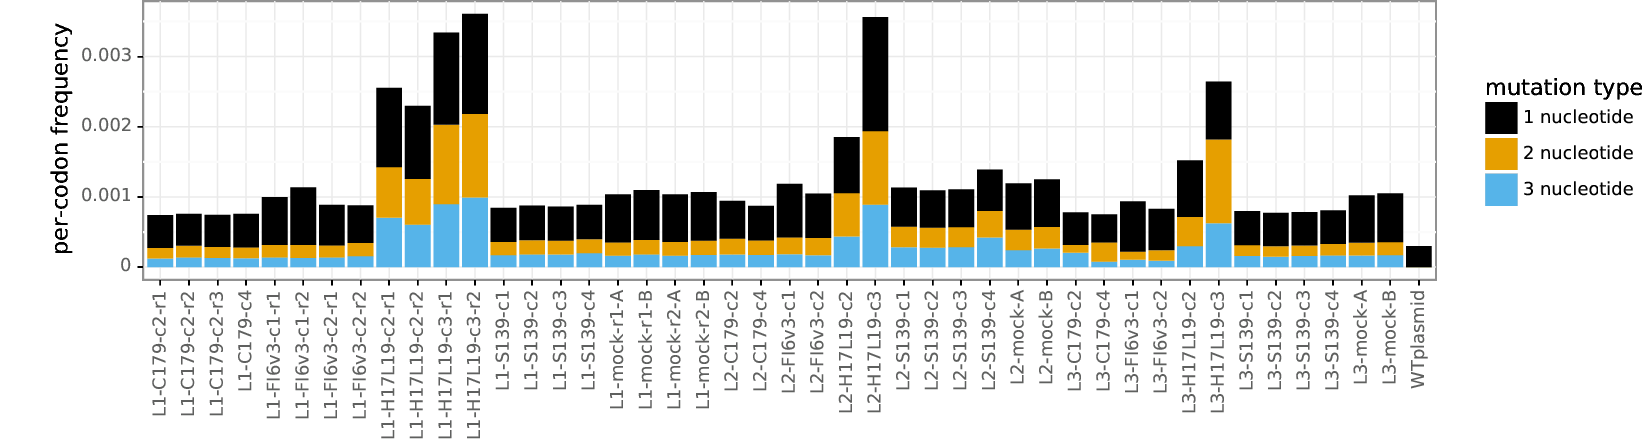

In [17]:
showPDF(countsplotprefix + '_codonntchanges.pdf')

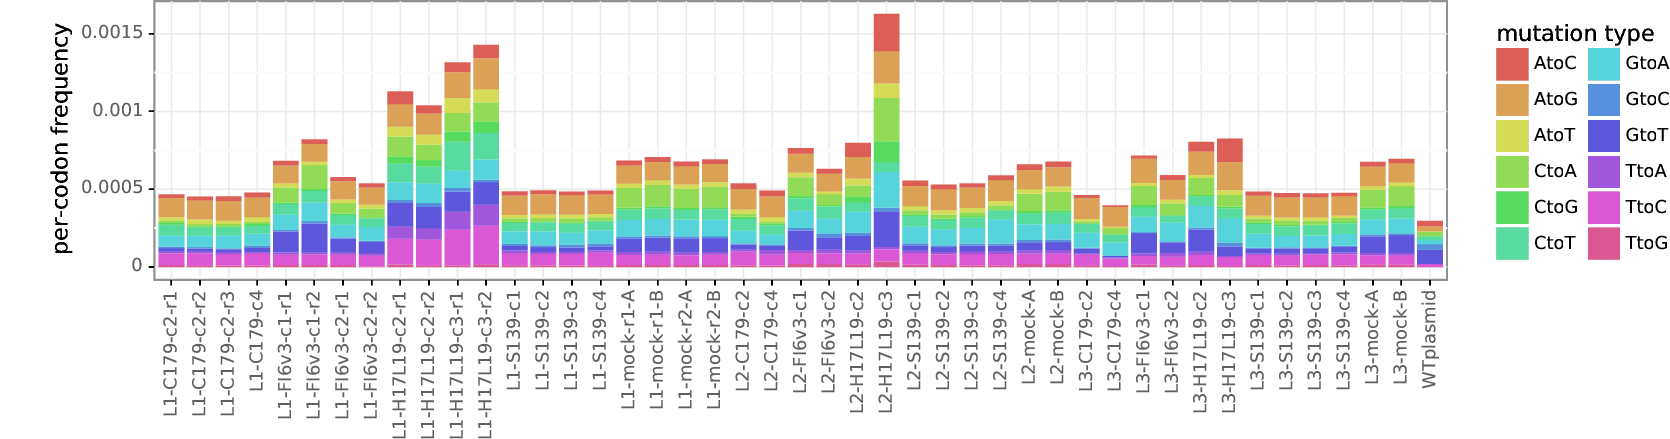

In [18]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

Some of the FI6v3- and H17-L19- selected samples show signs of oxidative damage (enrichment of `G to T` and `C to A` mutations). In contrast, the C179- and S139/1- selected samples do not show much signs of oxidative damage. The two sets of mock-selected samples (A and B), which are actually two sequencing reactions of the same initial library prep, do show some signs of oxidative damage.

# Compute differential selection

Here we are going to compute differential selection for the various selection conditions by defining selection groups as well as their associated replicates, selection name, mock library, and error control correction.

We will analyze differential selections for each antibody at each of the different concentrations used for the selection experiments. For the FI6v3- and H17L19-selected libraries, we will use the mock-selected codon counts from the libraries that we sequenced in parallel with these selections. These mock-selected codon counts are designated by an `-A` attached to the sample name. For the S139/1- and C179-selected libraries, we will use the mock-selected codon counts from the libraries that we sequenced in parallel with the C179 selections, and are designated by a `-B` attached to the sample name.

For error control correction for all samples, we will use the codon counts from the `WT plasmid` that we sequenced alongside the C179-selected libraries.

In [37]:
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pd.DataFrame.from_records([ 
         # FI6v3 at 0.1 ug/ml (100 ng/ml)
         ('FI6v3-100ng-ml', 'replicate-1a', 'L1-FI6v3-100ng-ml-r1', 'L1-mock-r1-A'), 
         ('FI6v3-100ng-ml', 'replicate-1b', 'L1-FI6v3-100ng-ml-r2', 'L1-mock-r2-A'),
         ('FI6v3-100ng-ml', 'replicate-2', 'L2-FI6v3-100ng-ml', 'L2-mock-A'), 
         ('FI6v3-100ng-ml', 'replicate-3', 'L3-FI6v3-100ng-ml', 'L3-mock-A'), 
         # FI6v3 at 0.2 ug/ml (200 ng/ml)
         ('FI6v3-200ng-ml', 'replicate-1a', 'L1-FI6v3-200ng-ml-r1', 'L1-mock-r1-A'),
         ('FI6v3-200ng-ml', 'replicate-1b', 'L1-FI6v3-200ng-ml-r2', 'L1-mock-r2-A'), 
         ('FI6v3-200ng-ml', 'replicate-2', 'L2-FI6v3-200ng-ml', 'L2-mock-A'),
         ('FI6v3-200ng-ml', 'replicate-3', 'L3-FI6v3-200ng-ml', 'L3-mock-A'),
         # S139 at 100 ug/ml
         ('S139-100ug-ml', 'replicate-1', 'L1-S139-100ug-ml', 'L1-mock-r1-B'),  
         ('S139-100ug-ml', 'replicate-2', 'L2-S139-100ug-ml', 'L2-mock-B'),        
         ('S139-100ug-ml', 'replicate-3', 'L3-S139-100ug-ml', 'L3-mock-B'), 
         # S139 at 200 ug/ml
         ('S139-200ug-ml', 'replicate-1', 'L1-S139-200ug-ml', 'L1-mock-r1-B'),
         ('S139-200ug-ml', 'replicate-2', 'L2-S139-200ug-ml', 'L2-mock-B'),
         ('S139-200ug-ml', 'replicate-3', 'L3-S139-200ug-ml', 'L3-mock-B'), 
         # S139 at 300 ug/ml
         ('S139-300ug-ml', 'replicate-1', 'L1-S139-300ug-ml', 'L1-mock-r1-B'), 
         ('S139-300ug-ml', 'replicate-2', 'L2-S139-300ug-ml', 'L2-mock-B'),
         ('S139-300ug-ml', 'replicate-3', 'L3-S139-300ug-ml', 'L3-mock-B'), 
         # C179 at 1 ug/ml
         ('C179-1ug-ml', 'replicate-1a', 'L1-C179-1ug-ml-r1', 'L1-mock-r1-B'),
         ('C179-1ug-ml', 'replicate-1b', 'L1-C179-1ug-ml-r2', 'L1-mock-r1-B'),
         ('C179-1ug-ml', 'replicate-1c', 'L1-C179-1ug-ml-r3', 'L1-mock-r2-B'), 
         ('C179-1ug-ml', 'replicate-2', 'L2-C179-1ug-ml', 'L2-mock-B'), 
         ('C179-1ug-ml', 'replicate-3', 'L3-C179-1ug-ml', 'L3-mock-B'),
         # C179 at 2.5 ug/ml (rounded down to 2 ug/ml)
         ('C179-2ug-ml', 'replicate-1', 'L1-C179-2ug-ml', 'L1-mock-r1-B'), 
         ('C179-2ug-ml', 'replicate-2', 'L2-C179-2ug-ml', 'L2-mock-B'), 
         ('C179-2ug-ml', 'replicate-3', 'L3-C179-2ug-ml', 'L3-mock-B'), 
         # H17L19 at 1 ug/ml
         ('H17L19-1ug-ml', 'replicate-1a', 'L1-H17L19-1ug-ml-r1', 'L1-mock-r1-A'), 
         ('H17L19-1ug-ml', 'replicate-1b', 'L1-H17L19-1ug-ml-r2', 'L1-mock-r2-A'),
         ('H17L19-1ug-ml', 'replicate-2', 'L2-H17L19-1ug-ml', 'L2-mock-A'), 
         ('H17L19-1ug-ml', 'replicate-3', 'L3-H17L19-1ug-ml', 'L3-mock-A'), 
         # H17L19 at 10 ug/ml
         ('H17L19-10ug-ml', 'replicate-1a', 'L1-H17L19-10ug-ml-r1', 'L1-mock-r1-A'),
         ('H17L19-10ug-ml', 'replicate-1b', 'L1-H17L19-10ug-ml-r2', 'L1-mock-r2-A'),
         ('H17L19-10ug-ml', 'replicate-2', 'L2-H17L19-10ug-ml', 'L2-mock-A'),
         ('H17L19-10ug-ml', 'replicate-3', 'L3-H17L19-10ug-ml', 'L3-mock-A'), 
         # H17L10 at 3 ug/ml
         ('H17L10-3ug-ml', 'replicate-1', 'L1_H17L10-3ug-ml', 'L1-mock-r1-A'), 
         ('H17L10-3ug-ml', 'replicate-2', 'L2_H17L10-3ug-ml', 'L2-mock-A'), 
         ('H17L10-3ug-ml', 'replicate-3', 'L3_H17L10-3ug-ml', 'L3-mock-A'), 
         # H17L7 at 15 ug/ml
         ('H17L7-15ug-ml', 'replicate-1', 'L1_H17L7-15ug-ml', 'L1-mock-r1-A'), 
         ('H17L7-15ug-ml', 'replicate-2', 'L2_H17L7-15ug-ml', 'L2-mock-A'), 
         ('H17L7-15ug-ml', 'replicate-3', 'L3_H17L7-15ug-ml', 'L3-mock-A')
        ],       
        columns=['group', 'name', 'sel', 'mock']
        )
diffselbatch['err'] = 'WTplasmid' # all samples have the same error control

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
S139-80ug-ml,replicate-1,L1-S139-c1,L1-mock-r1-B,WTplasmid
S139-80ug-ml,replicate-2,L2-S139-c1,L2-mock-B,WTplasmid
S139-80ug-ml,replicate-3,L3-S139-c1,L3-mock-B,WTplasmid
S139-100ug-ml,replicate-1,L1-S139-c2,L1-mock-r1-B,WTplasmid
S139-100ug-ml,replicate-2,L2-S139-c2,L2-mock-B,WTplasmid
S139-100ug-ml,replicate-3,L3-S139-c2,L3-mock-B,WTplasmid
S139-200ug-ml,replicate-1,L1-S139-c3,L1-mock-r1-B,WTplasmid
S139-200ug-ml,replicate-2,L2-S139-c3,L2-mock-B,WTplasmid
S139-200ug-ml,replicate-3,L3-S139-c3,L3-mock-B,WTplasmid
S139-300ug-ml,replicate-1,L1-S139-c4,L1-mock-r1-B,WTplasmid


In [38]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {countsdir} \
        --use_existing {use_existing}

In [39]:
!ls {diffseldir}/summary*C179*.csv

./results/differential_selections//summary_C179-1ug-ml-meanmutdiffsel.csv
./results/differential_selections//summary_C179-1ug-ml-meansitediffsel.csv
./results/differential_selections//summary_C179-1ug-ml-medianmutdiffsel.csv
./results/differential_selections//summary_C179-1ug-ml-mediansitediffsel.csv
./results/differential_selections//summary_C179-2ug-ml-meanmutdiffsel.csv
./results/differential_selections//summary_C179-2ug-ml-meansitediffsel.csv
./results/differential_selections//summary_C179-2ug-ml-medianmutdiffsel.csv
./results/differential_selections//summary_C179-2ug-ml-mediansitediffsel.csv


In [40]:
!ls {diffseldir}/summary*FI6v3*.csv

./results/differential_selections//summary_FI6v3-100ng-ml-meanmutdiffsel.csv
./results/differential_selections//summary_FI6v3-100ng-ml-meansitediffsel.csv
./results/differential_selections//summary_FI6v3-100ng-ml-medianmutdiffsel.csv
./results/differential_selections//summary_FI6v3-100ng-ml-mediansitediffsel.csv
./results/differential_selections//summary_FI6v3-200ng-ml-meanmutdiffsel.csv
./results/differential_selections//summary_FI6v3-200ng-ml-meansitediffsel.csv
./results/differential_selections//summary_FI6v3-200ng-ml-medianmutdiffsel.csv
./results/differential_selections//summary_FI6v3-200ng-ml-mediansitediffsel.csv


### Show the correlation of mutation differential selection and positive site differential selection between the different replicates  


mutdiffsel correlations:


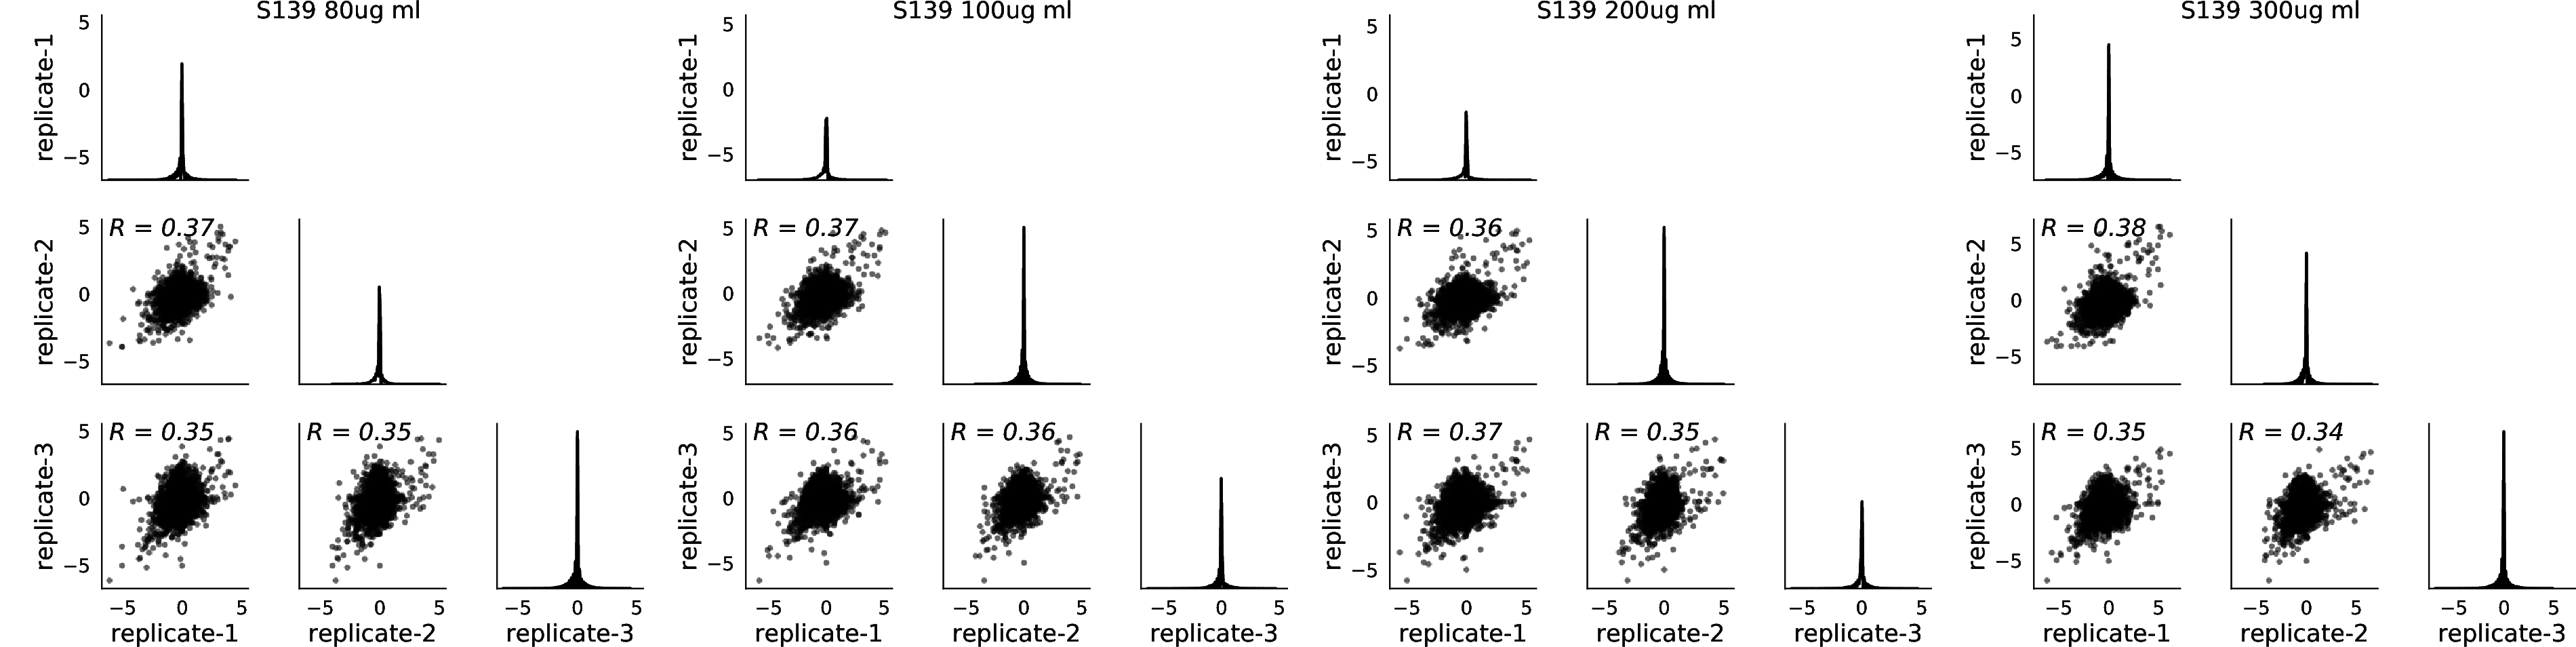

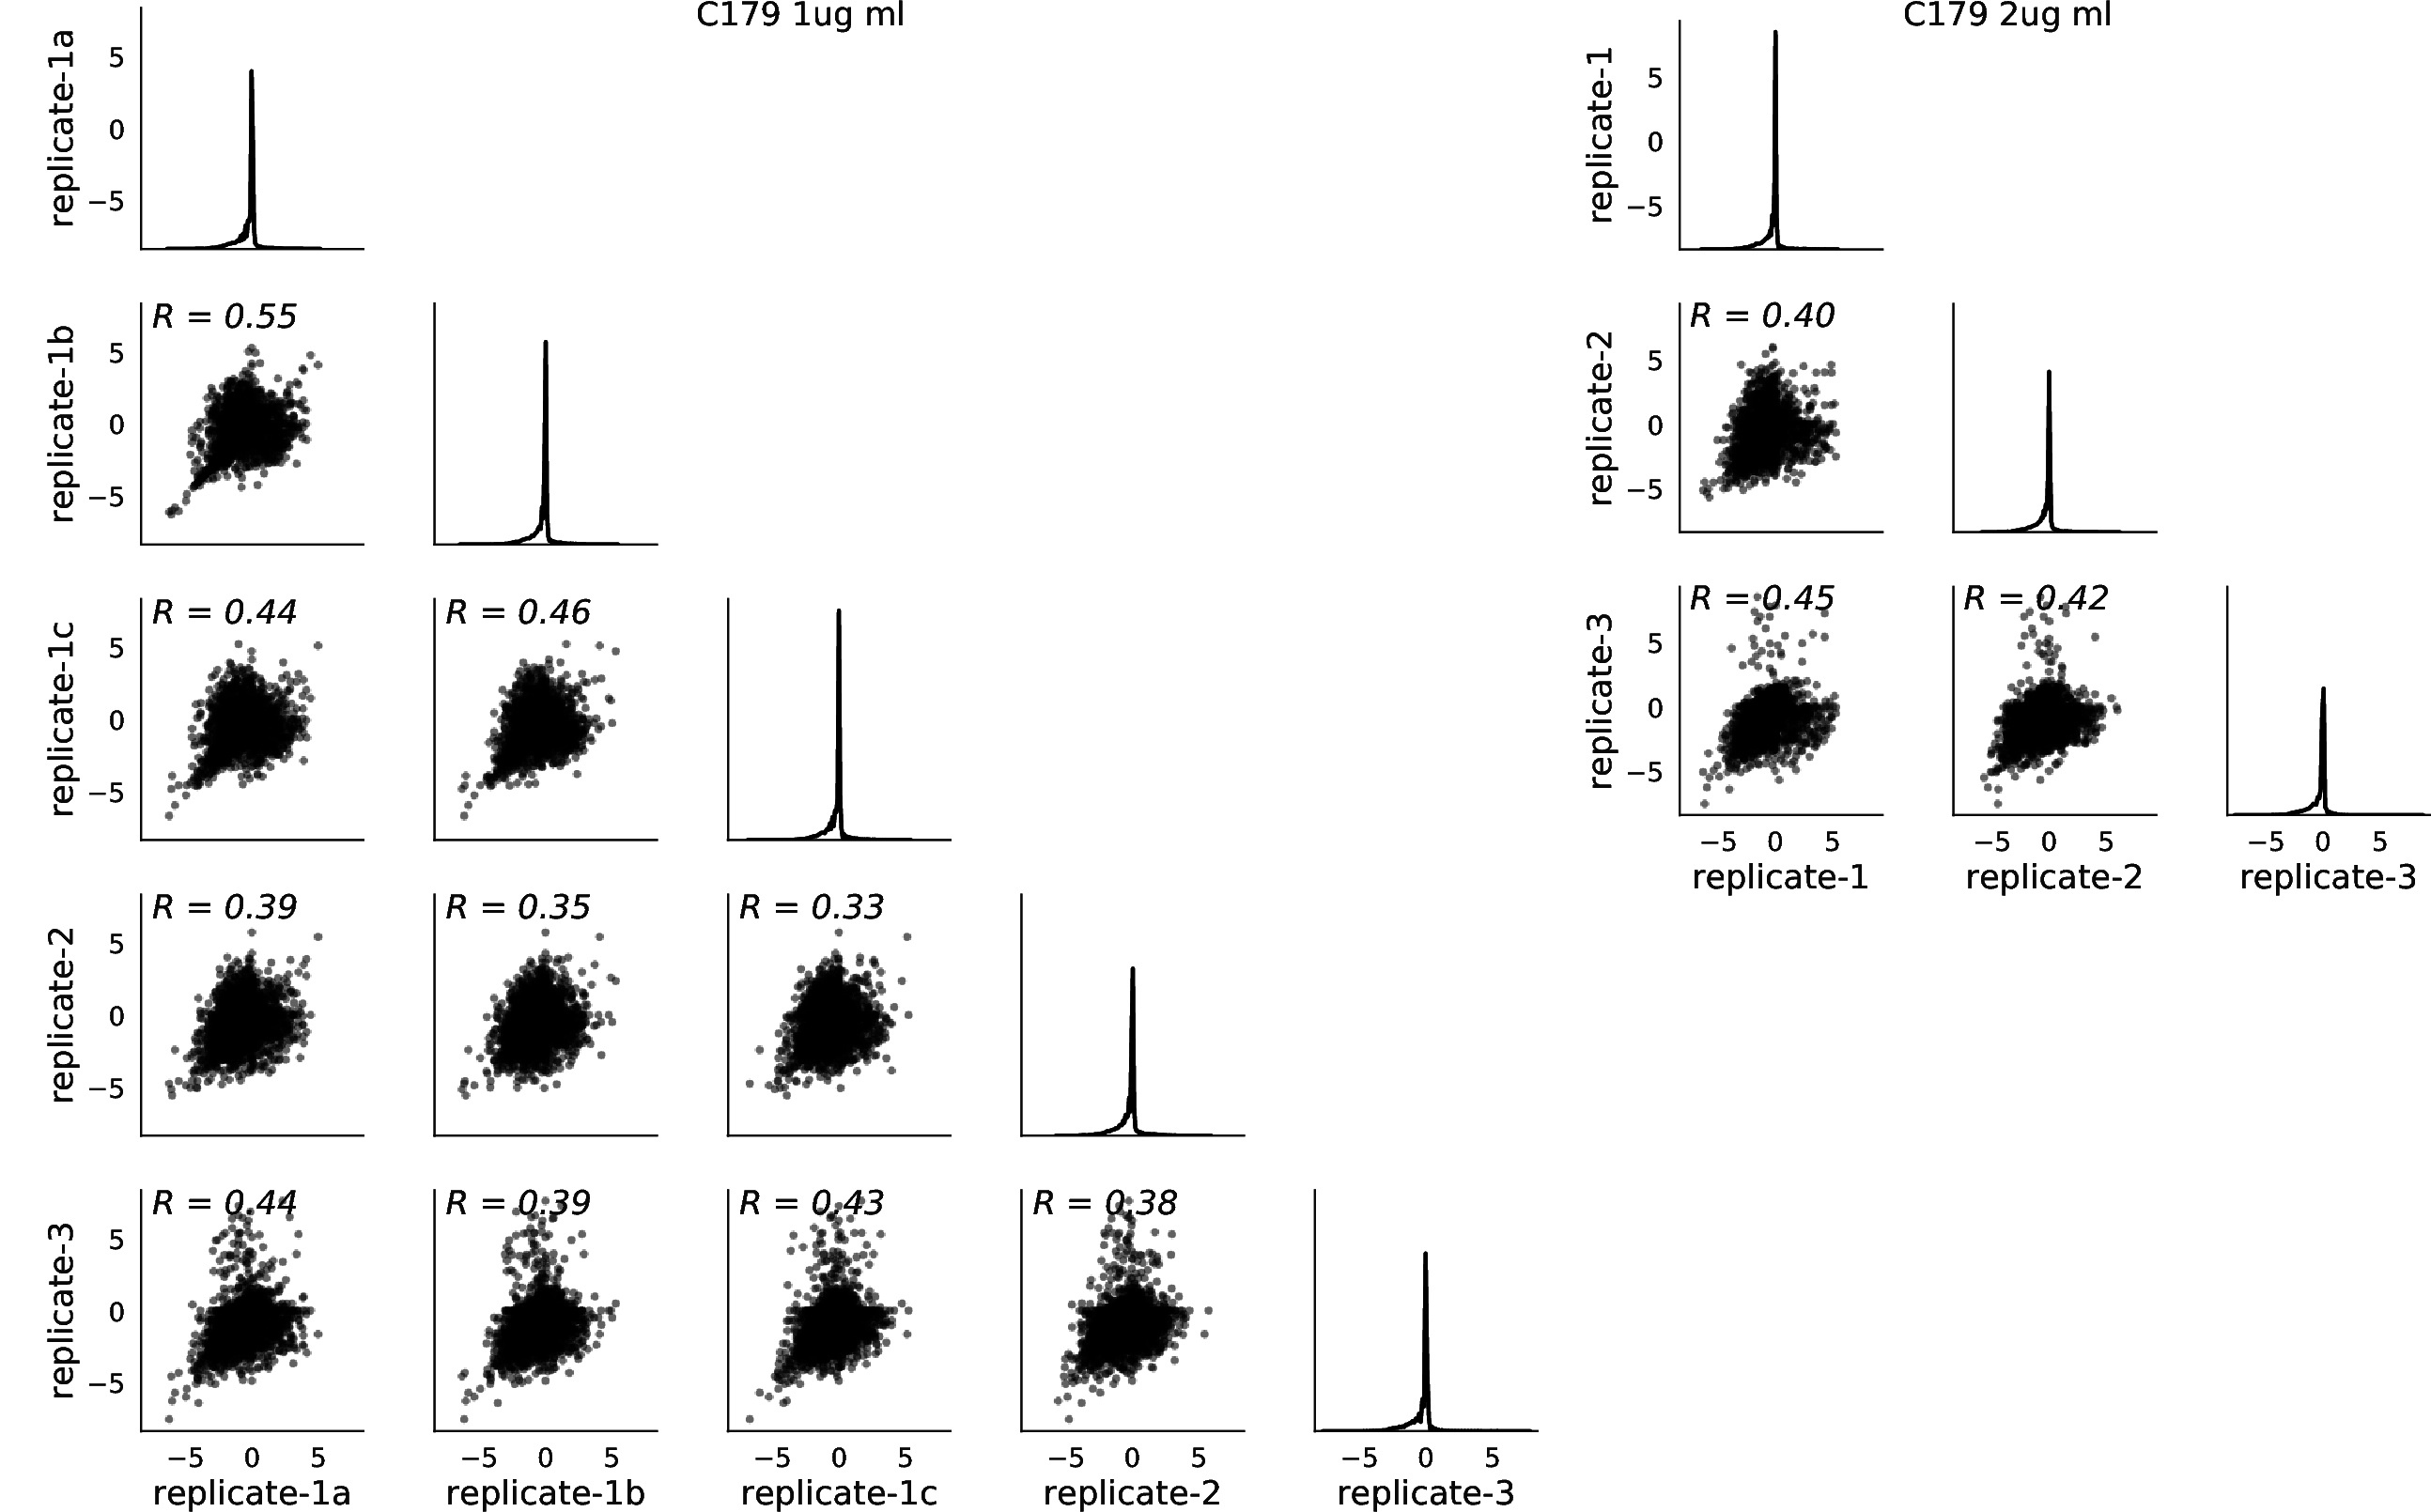

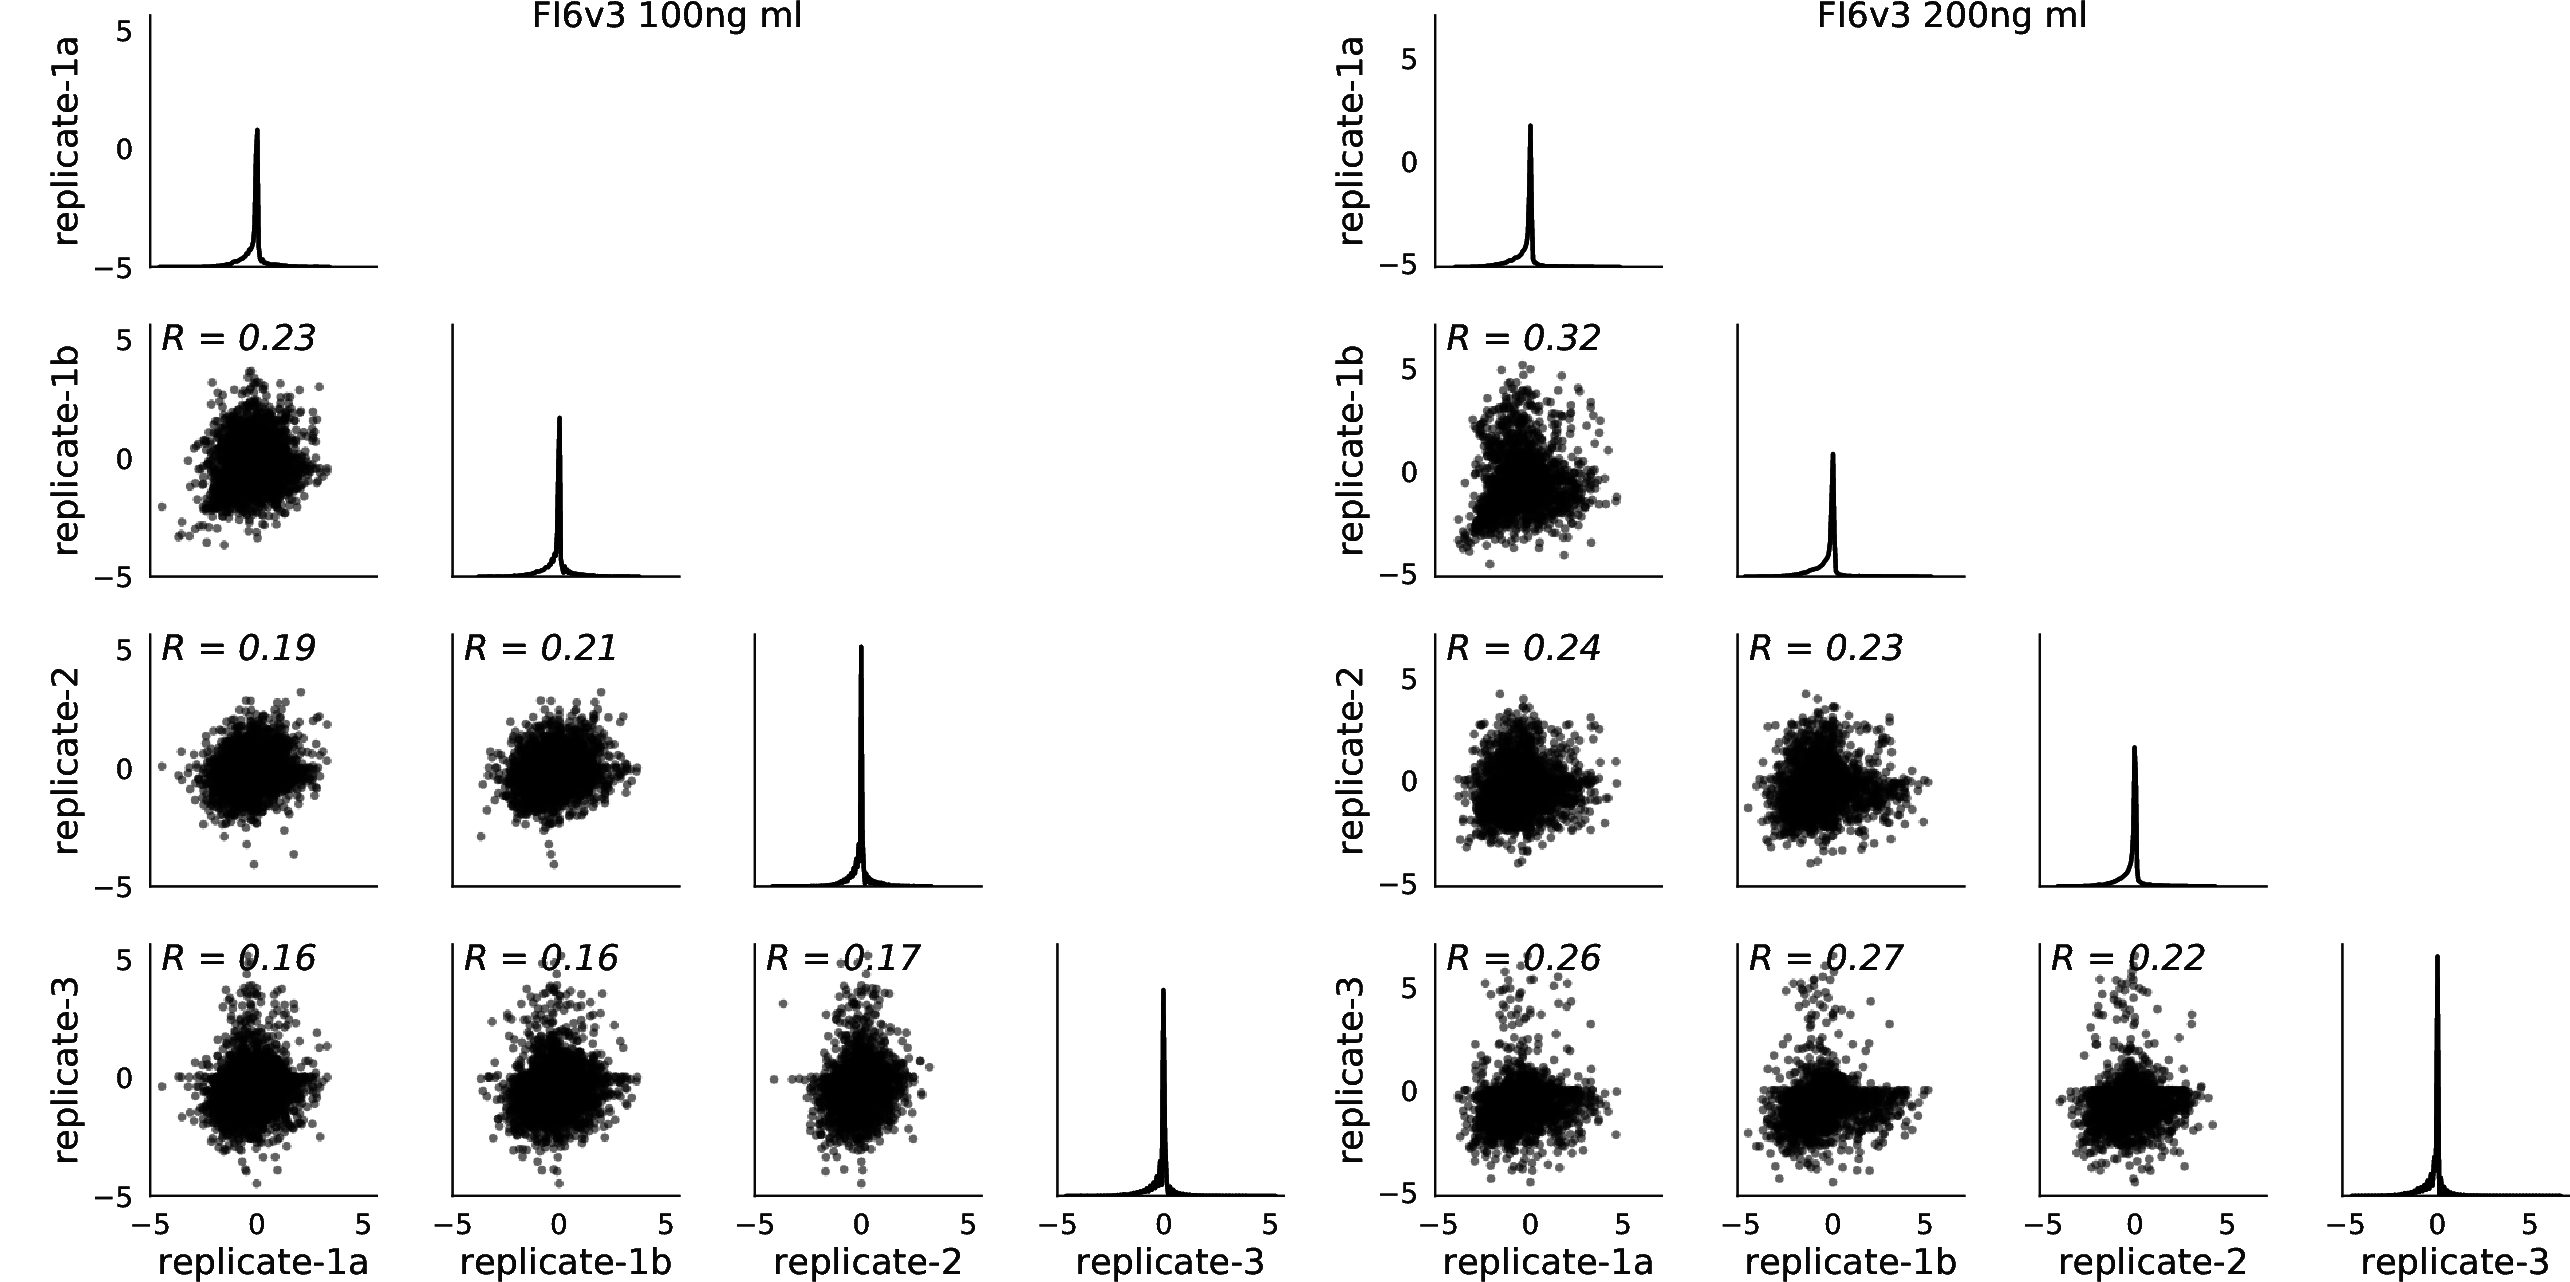

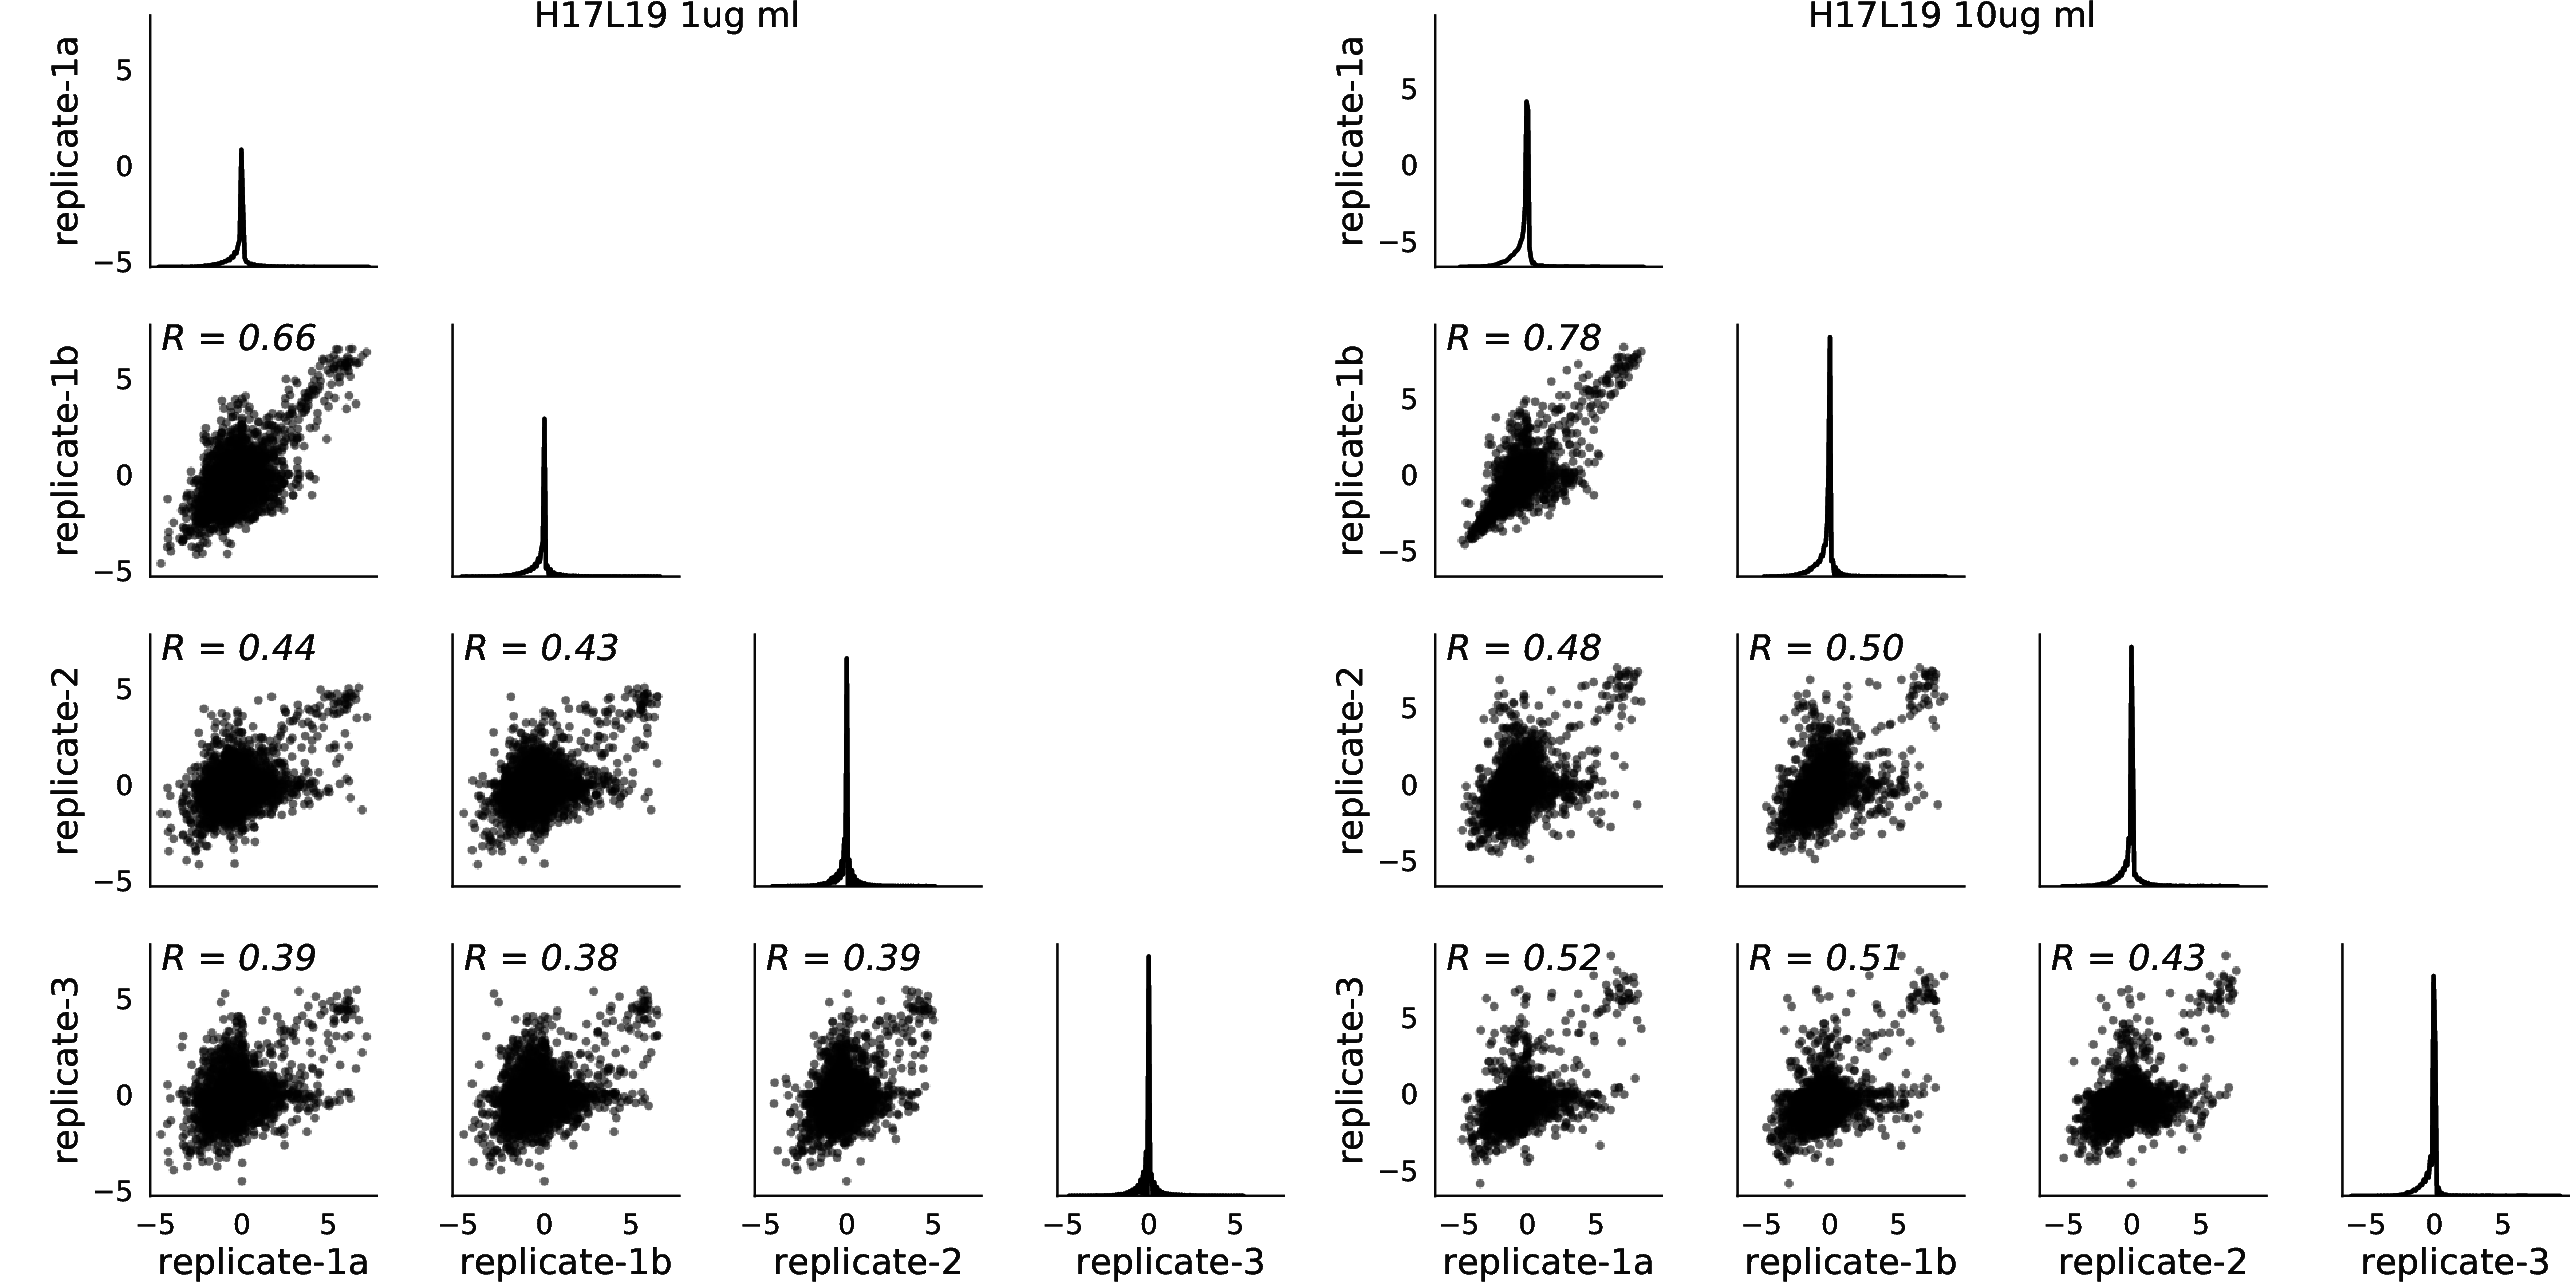


positivesitediffsel correlations:


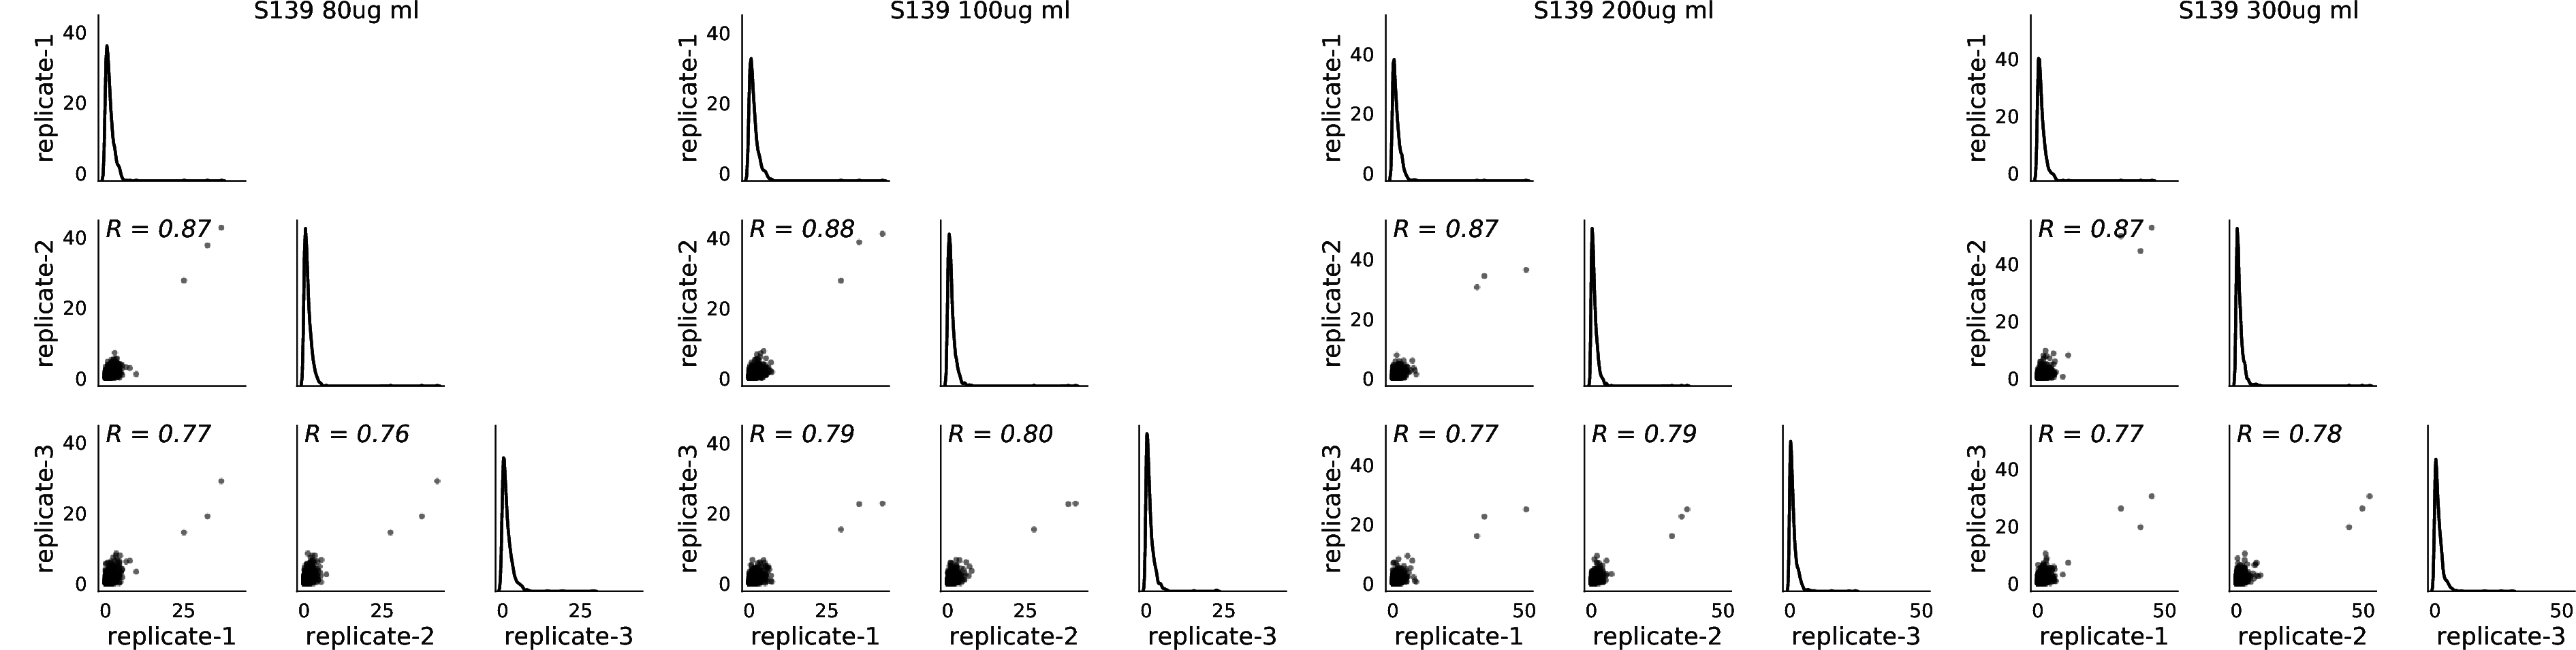

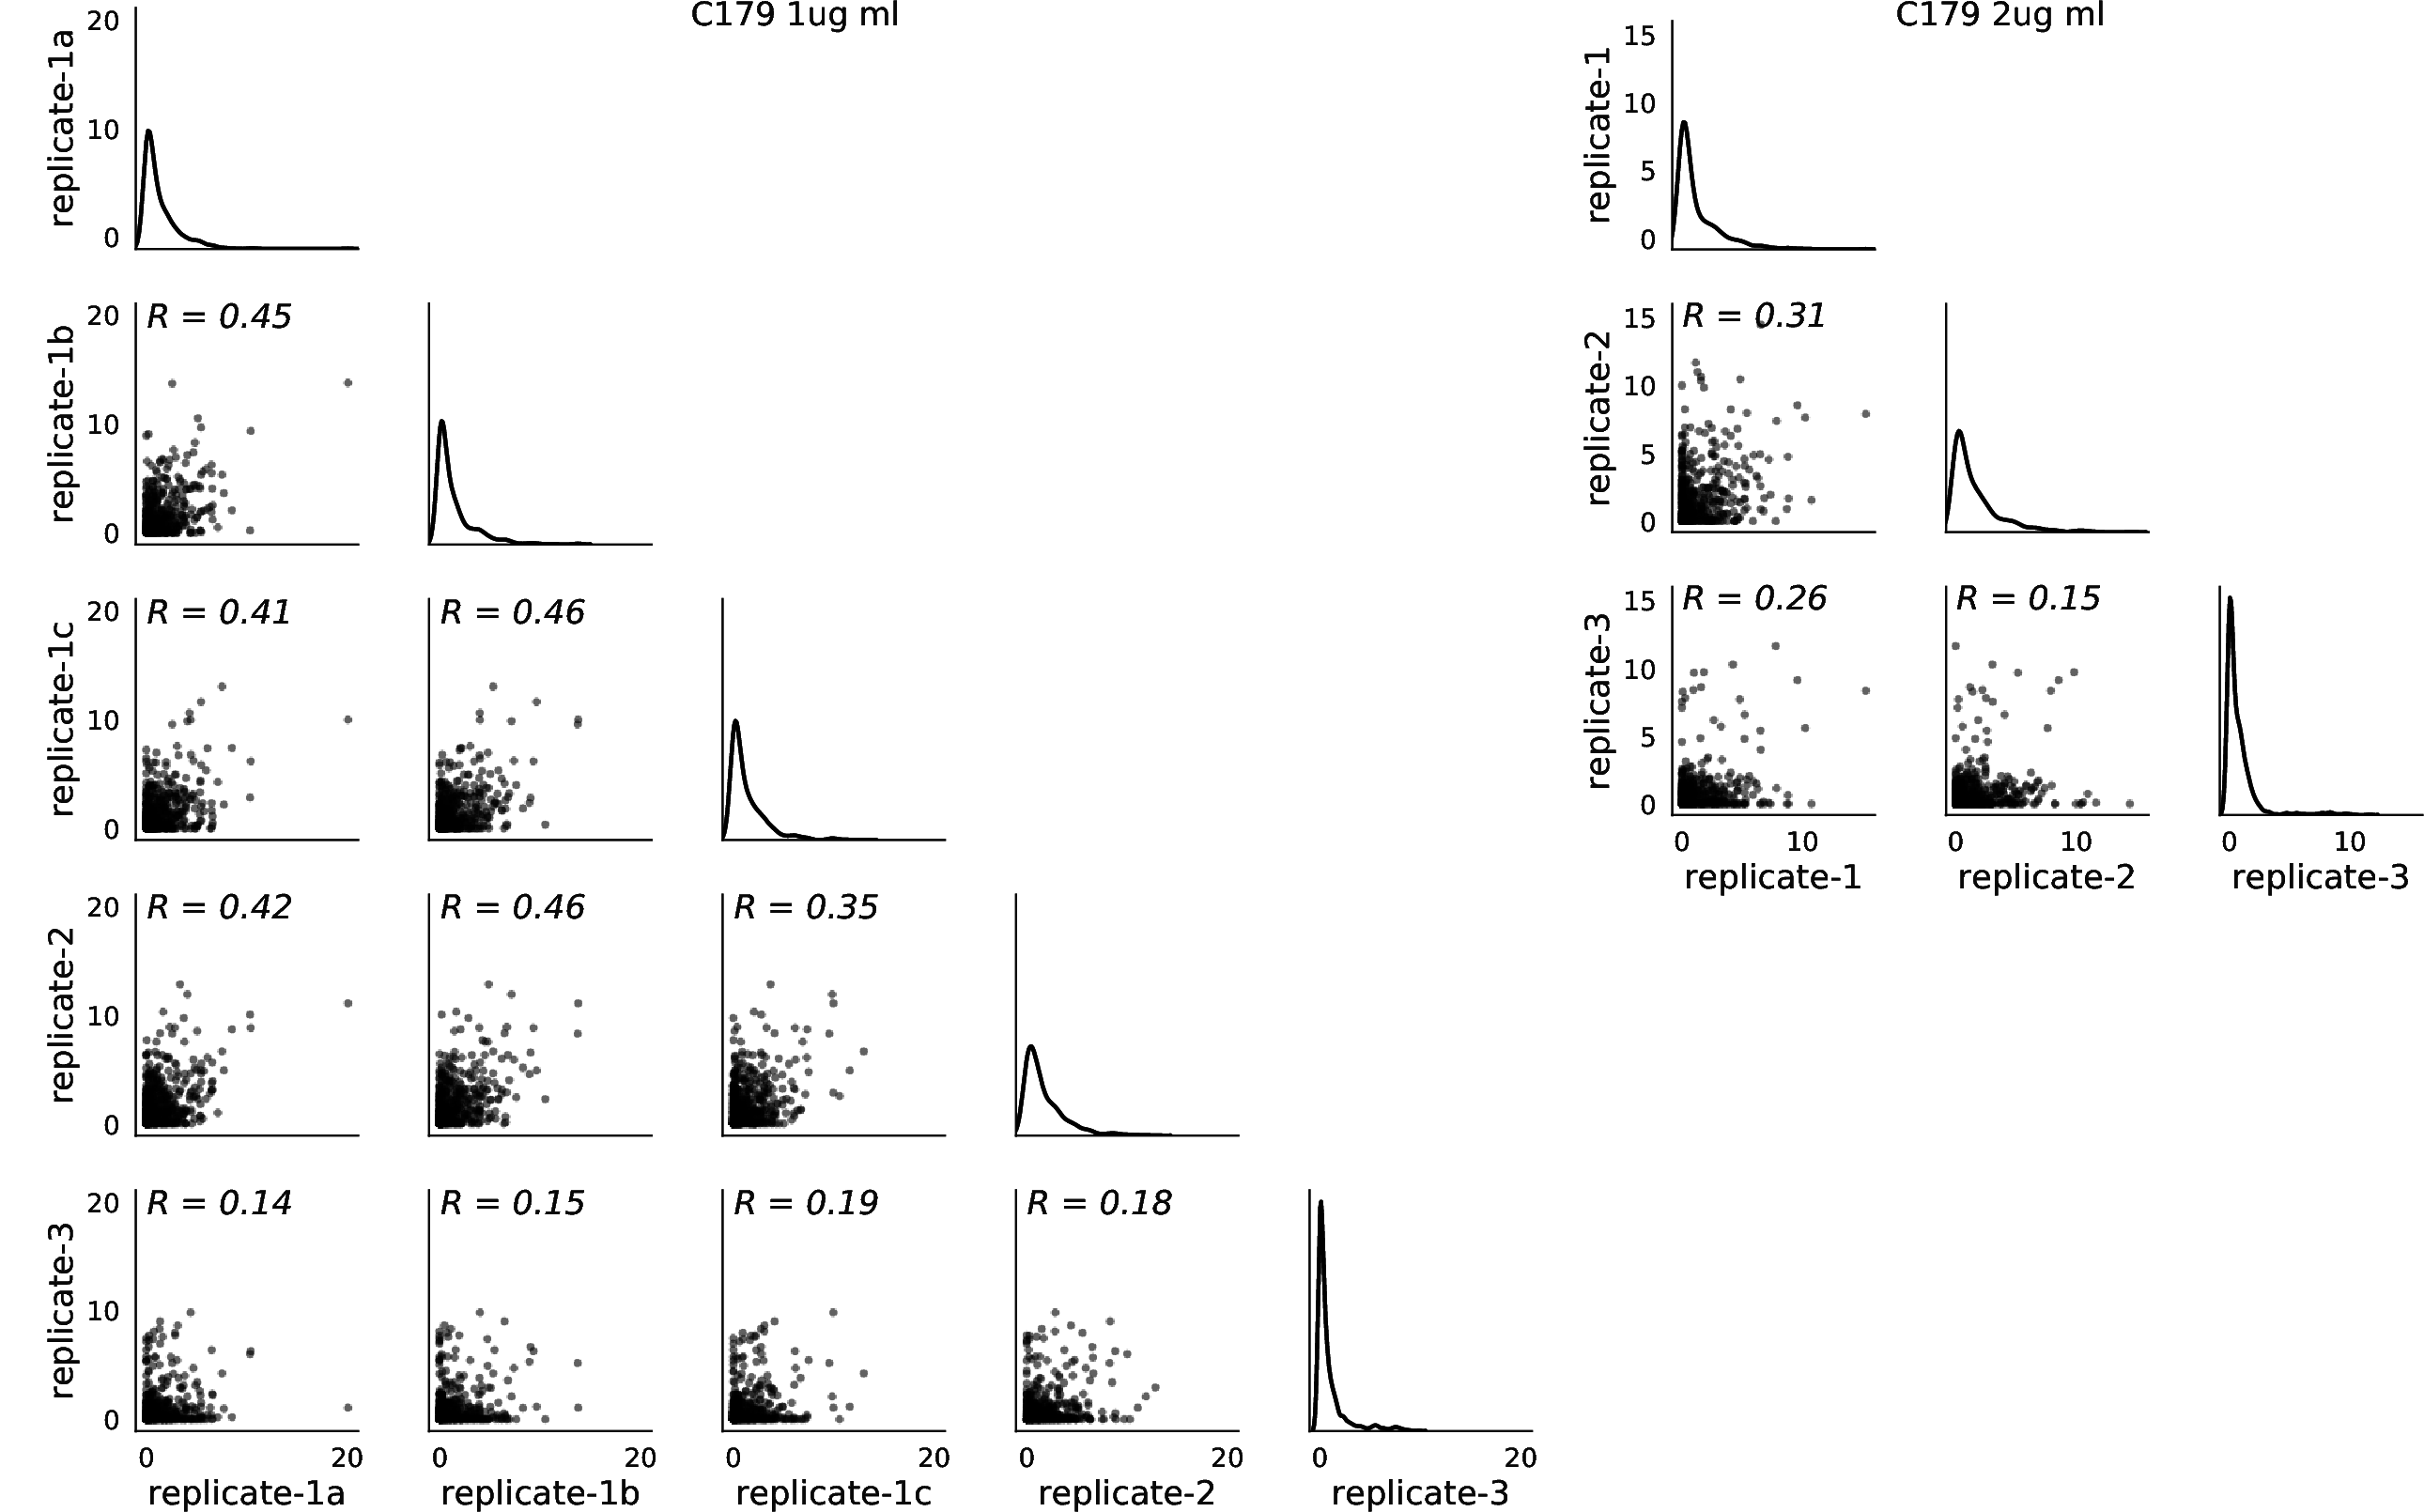

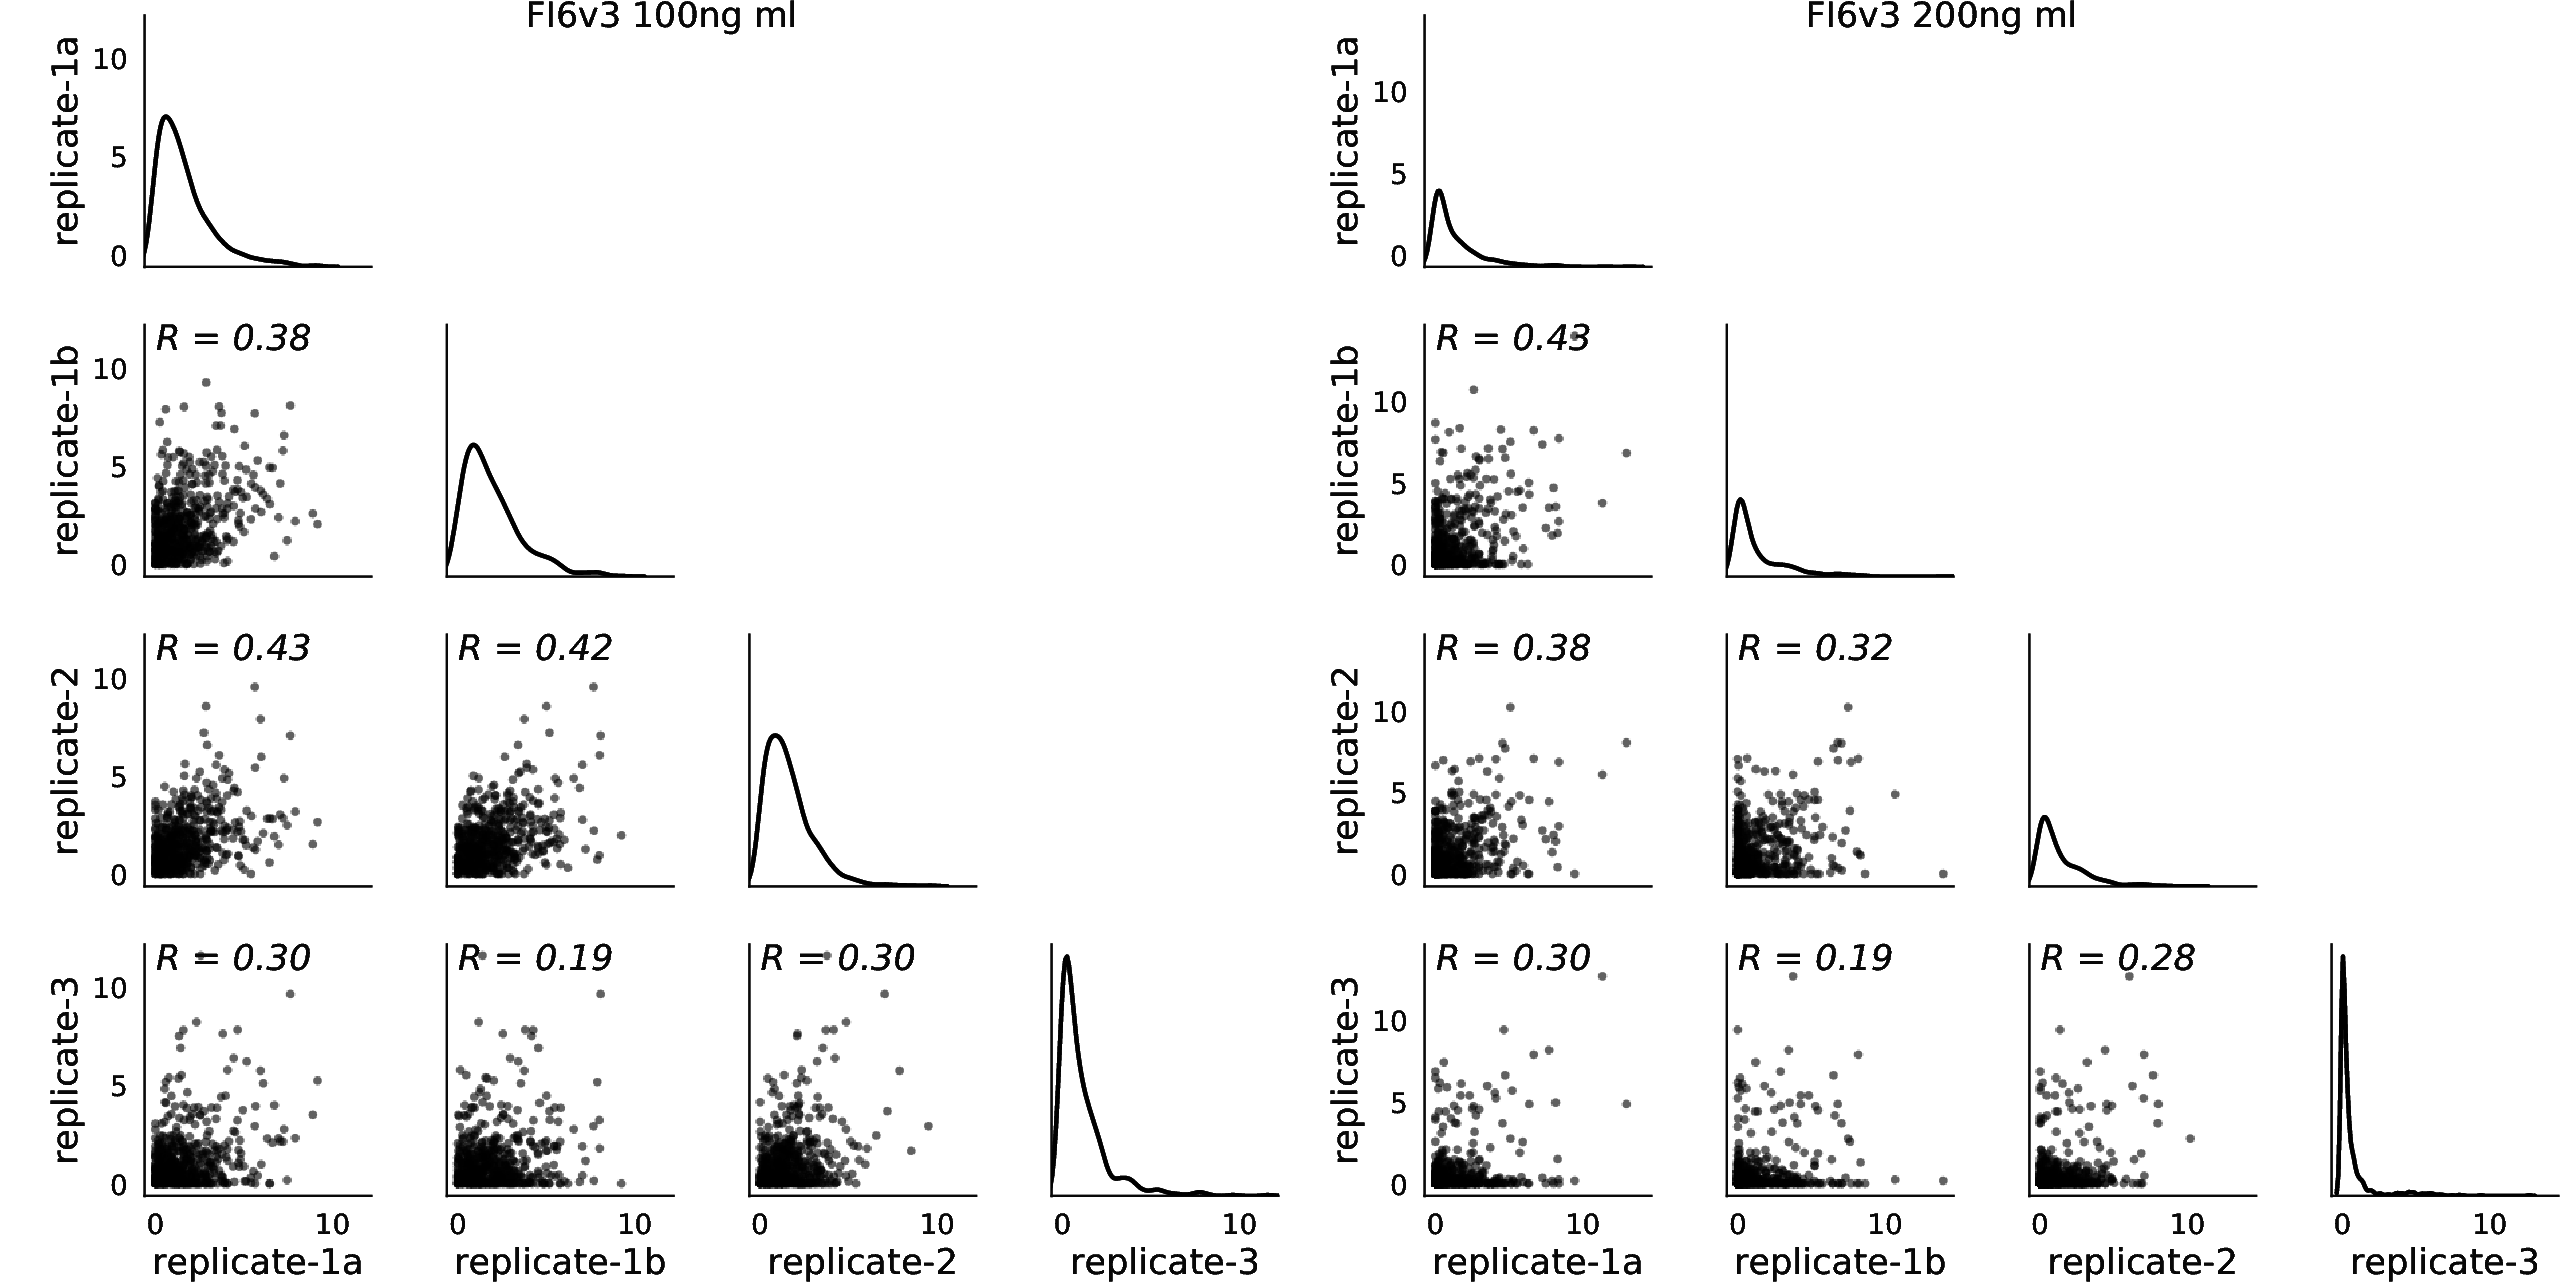

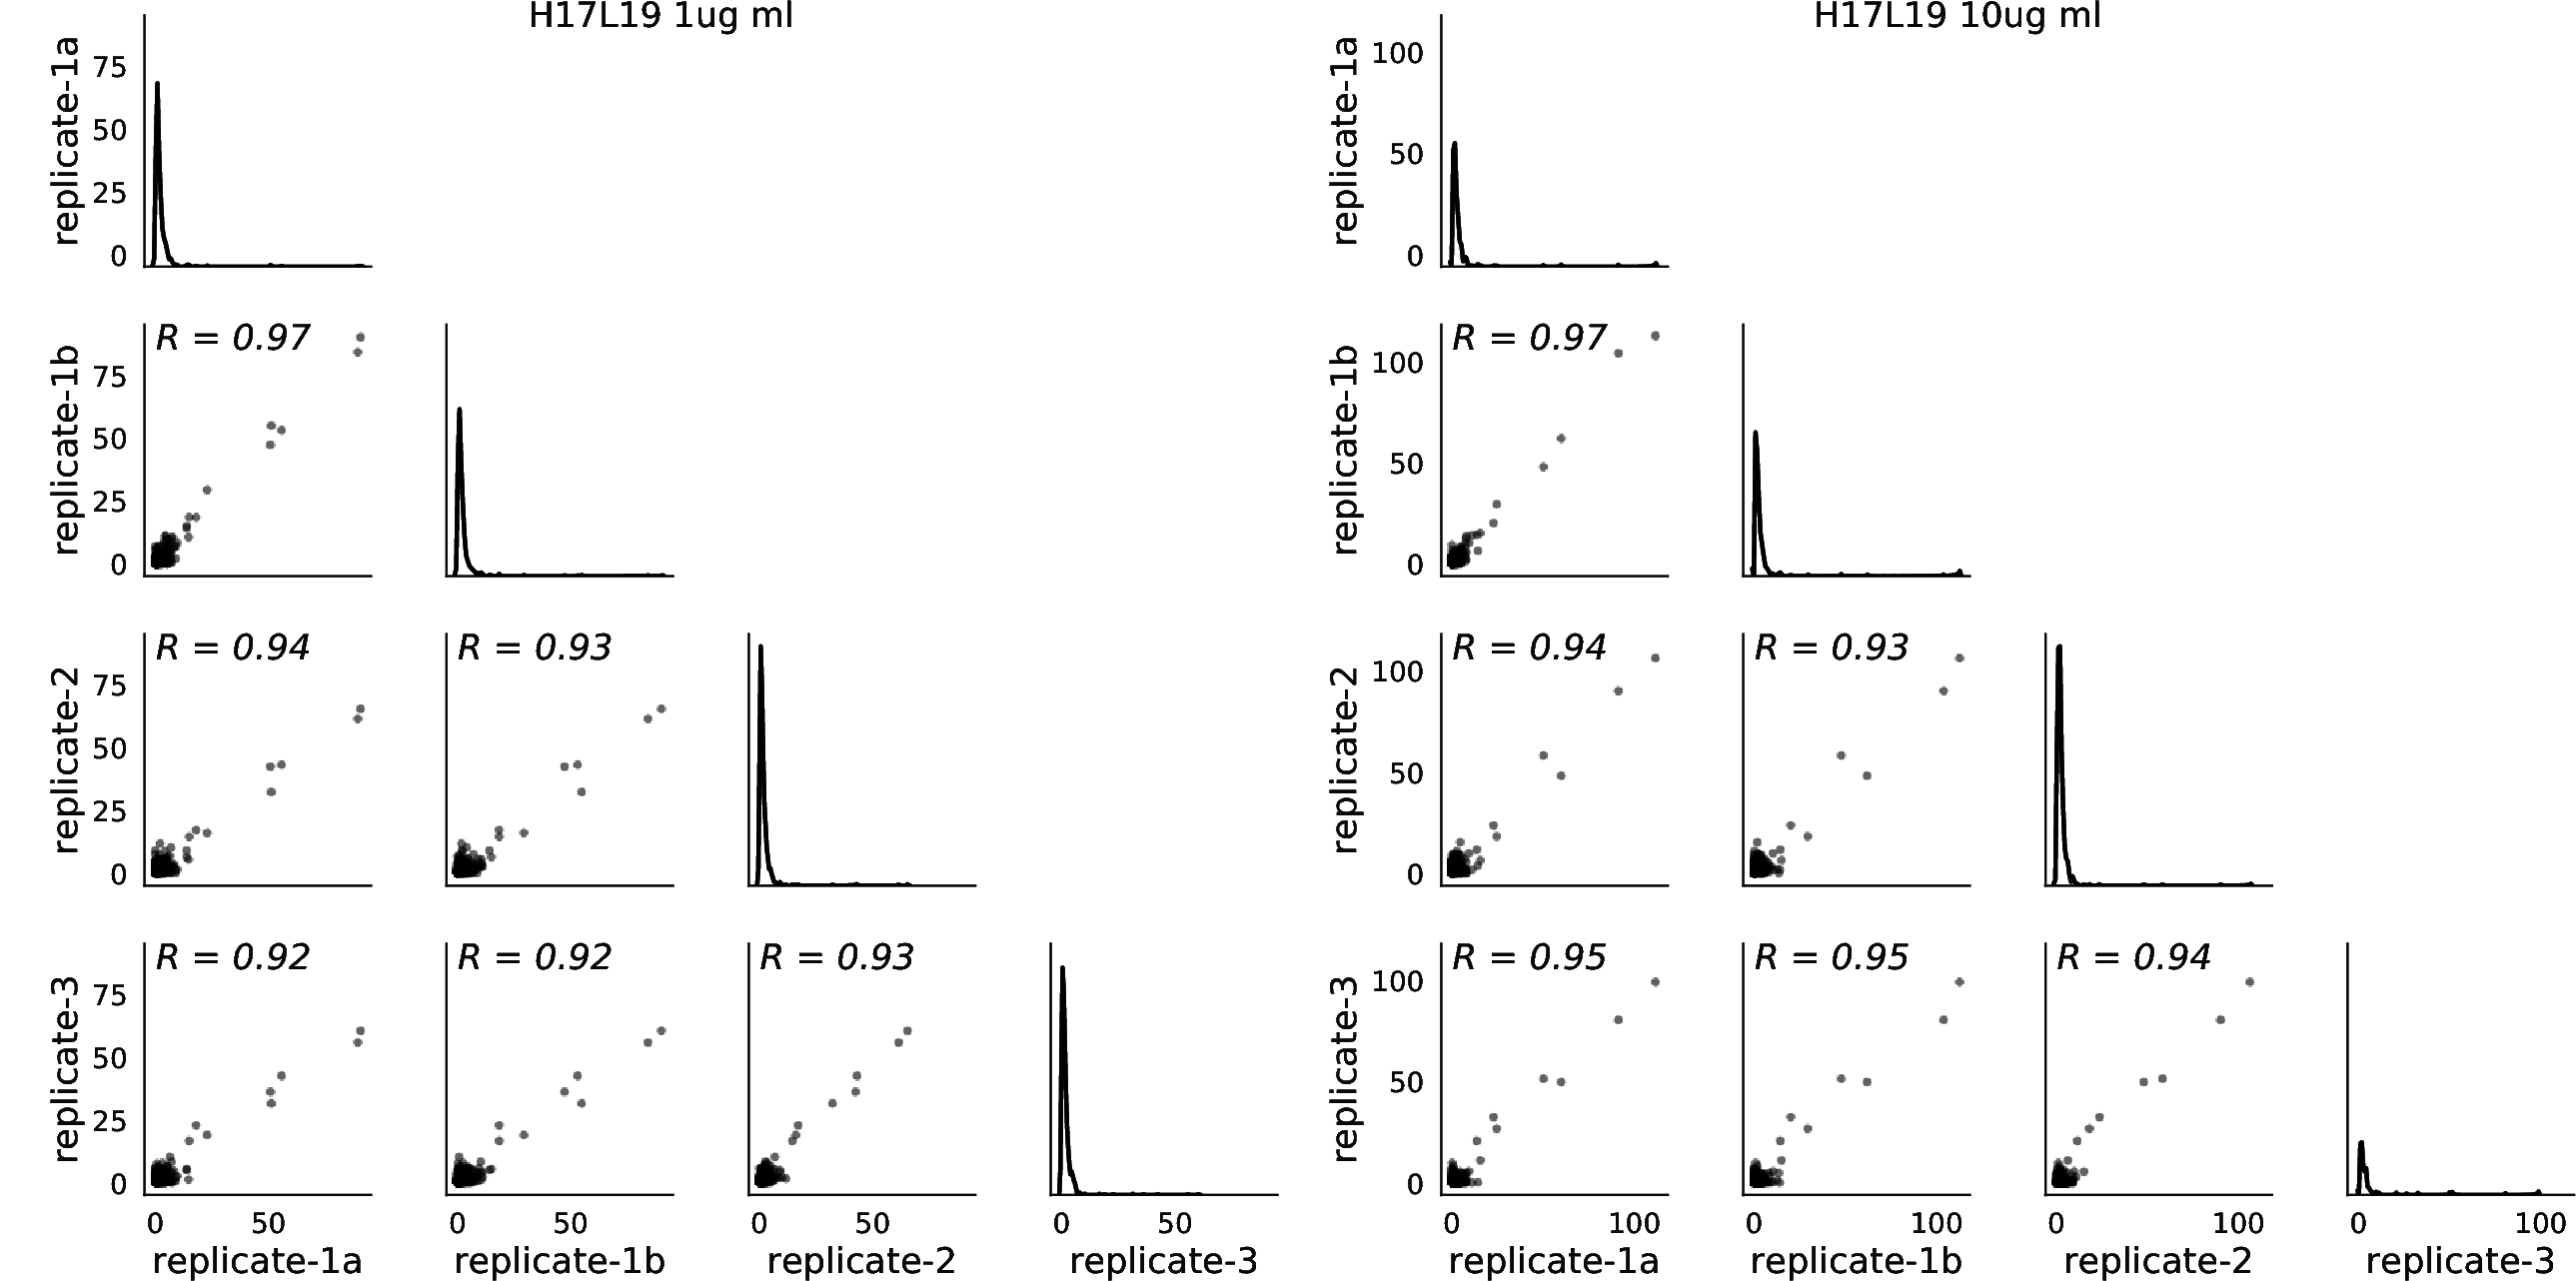

In [41]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots[ : 4]) # show S139/1 plots
    showPDF(plots[4 : 6]) # show C179 plots
    showPDF(plots[6 : 8], width=800) # show FI6v3 plots
    showPDF(plots[8 : ], width=800) # show H17L19 plots

The antibodies that are relatively 'easy to escape' from (namely S139/1 and H17L19), show good correlation for positive site differential selection between the various replicates.
However, the two stalk-targeting antibodies, FI6v3 and C179, show weak correlation between replicates for site differential selection. Mutations in these selection conditions likely have smaller effect sizes and therefore enrichment of these mutations is subject to more noise compared to enrichment of mutations after selection with S139/1 or H17L19. 

### Show correlation between the different concentrations

/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/tight_layout.py:226: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


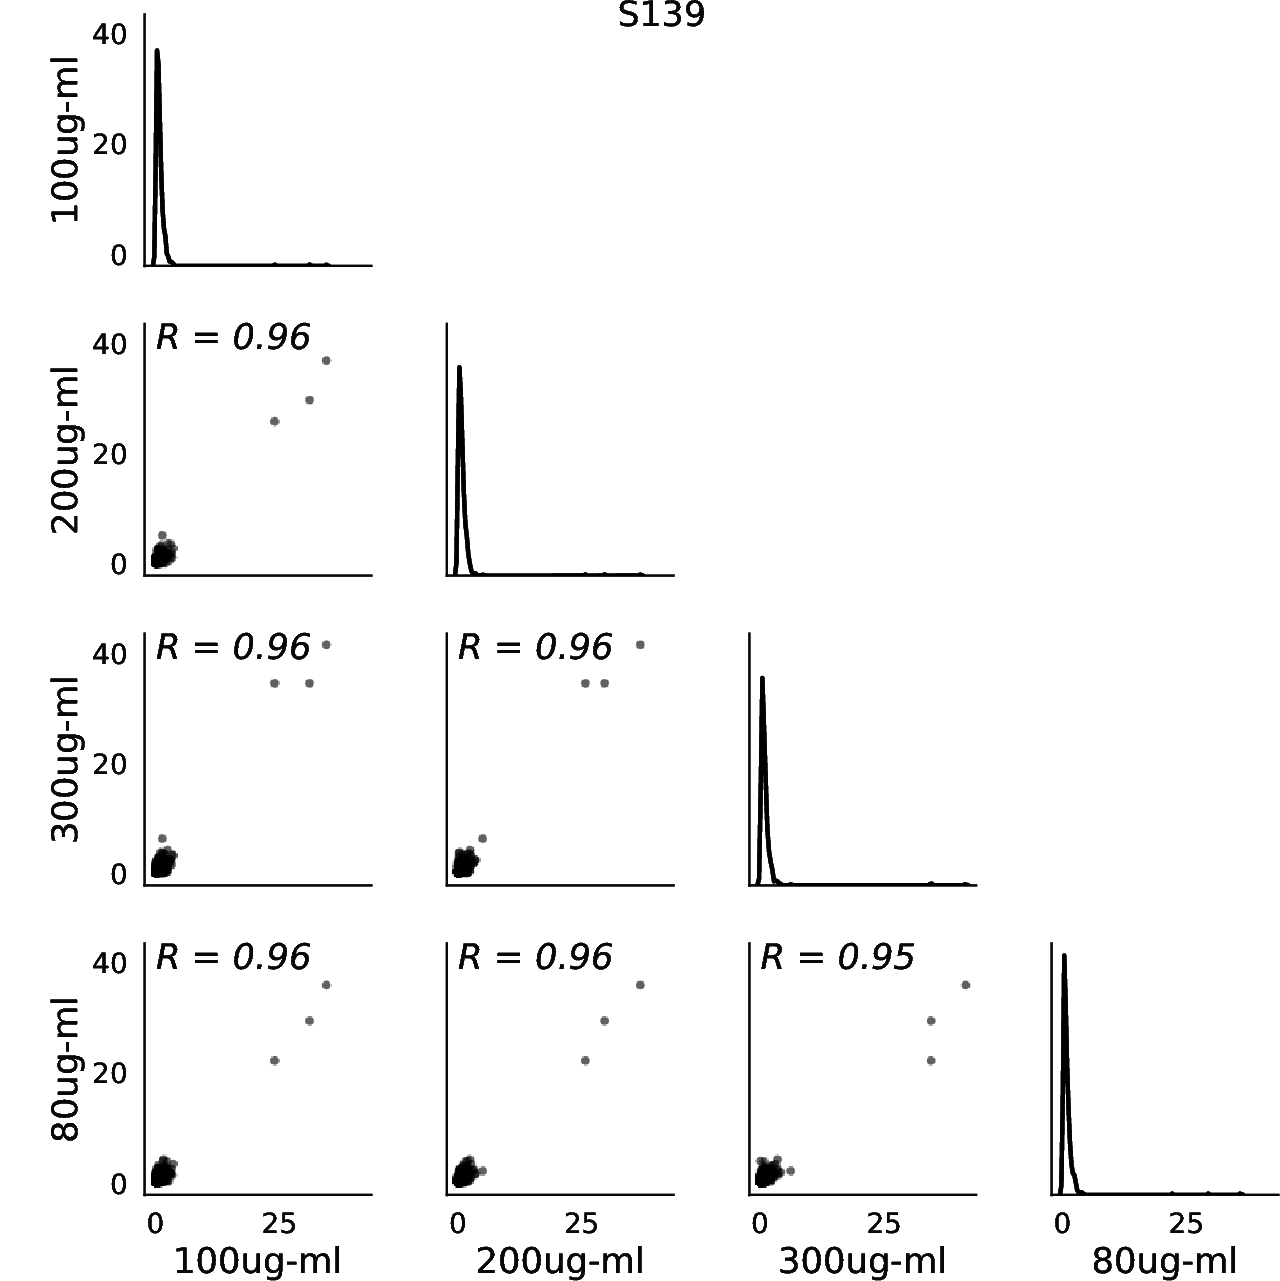

In [42]:
# S139/1 concentrations
concs = ['80ug-ml', '100ug-ml', '200ug-ml', '300ug-ml']
plotfile = diffselprefix + 'conc_corr_S139.pdf'
dms_tools2.plot.plotCorrMatrix(
        concs,
        [diffselprefix + 'S139-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='S139')
showPDF(plotfile)

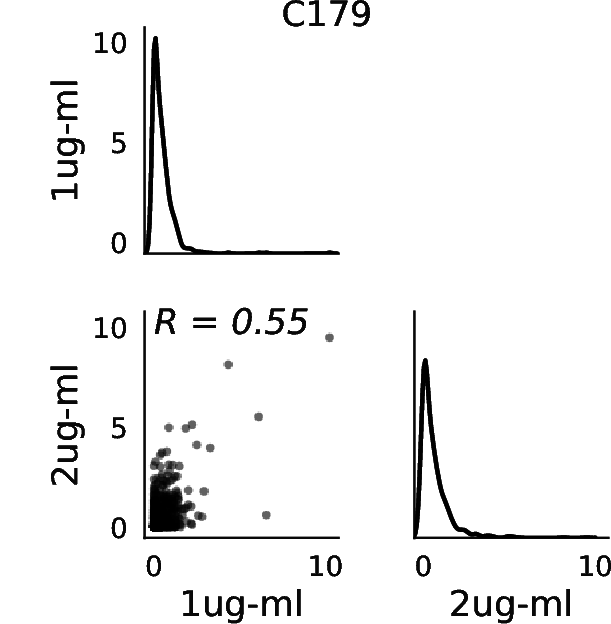

In [43]:
# C179 concentrations
concs = ['1ug-ml', '2ug-ml']
plotfile = diffselprefix + 'conc_corr_C179.pdf'
dms_tools2.plot.plotCorrMatrix(
        concs,
        [diffselprefix + 'C179-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='C179')
showPDF(plotfile)

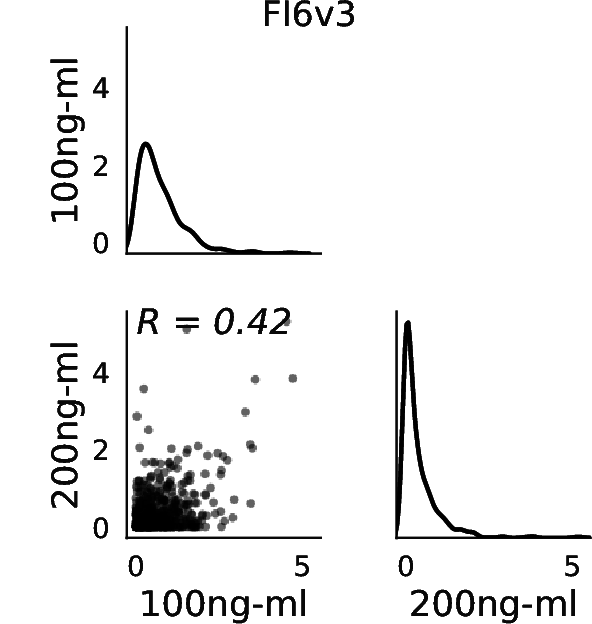

In [44]:
# FI6v3 concentrations
concs = ['100ng-ml', '200ng-ml']
plotfile = diffselprefix + 'conc_corr_FI6v3.pdf'
dms_tools2.plot.plotCorrMatrix(
        concs,
        [diffselprefix + 'FI6v3-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='FI6v3')
showPDF(plotfile)

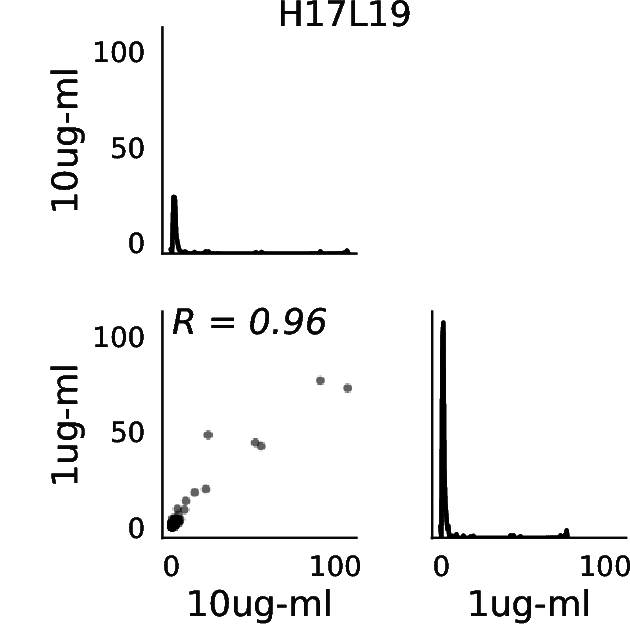

In [45]:
# H17L19 concentrations
concs = ['1ug-ml', '10ug-ml']
plotfile = diffselprefix + 'conc_corr_H17L19.pdf'
dms_tools2.plot.plotCorrMatrix(
        concs,
        [diffselprefix + 'H17L19-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='H17L19')
showPDF(plotfile)

In [46]:
!ls {diffseldir}/*diffsel.pdf

./results/differential_selections//summary_meanmaxdiffsel.pdf
./results/differential_selections//summary_meanminmaxdiffsel.pdf
./results/differential_selections//summary_meanpositivediffsel.pdf
./results/differential_selections//summary_meantotaldiffsel.pdf
./results/differential_selections//summary_medianmaxdiffsel.pdf
./results/differential_selections//summary_medianminmaxdiffsel.pdf
./results/differential_selections//summary_medianpositivediffsel.pdf
./results/differential_selections//summary_mediantotaldiffsel.pdf


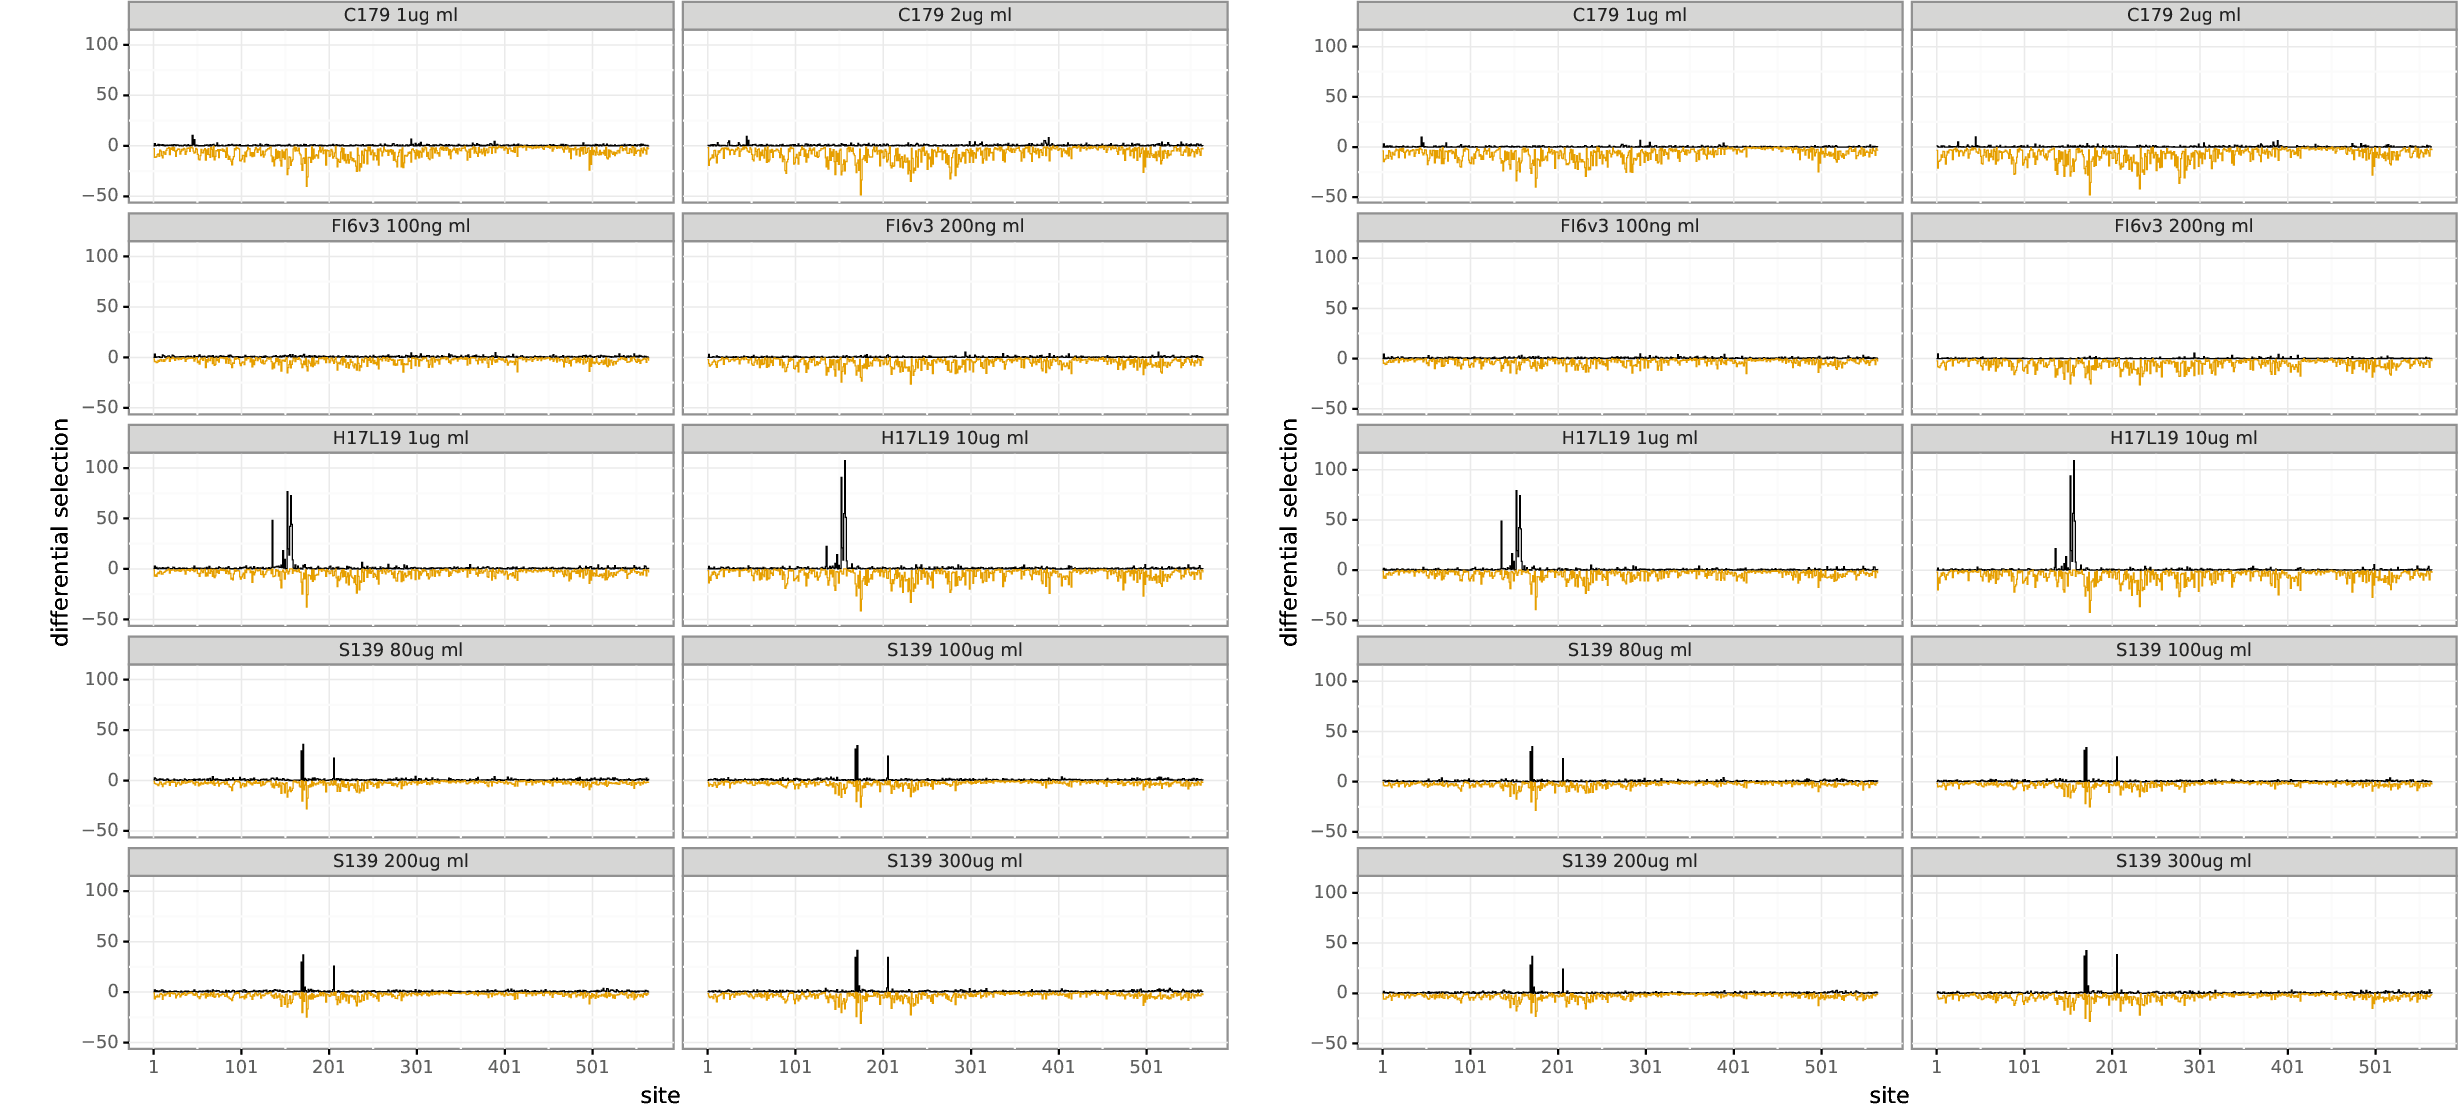

In [47]:
showPDF([diffselprefix + 'meantotaldiffsel.pdf', diffselprefix + 'mediantotaldiffsel.pdf'])

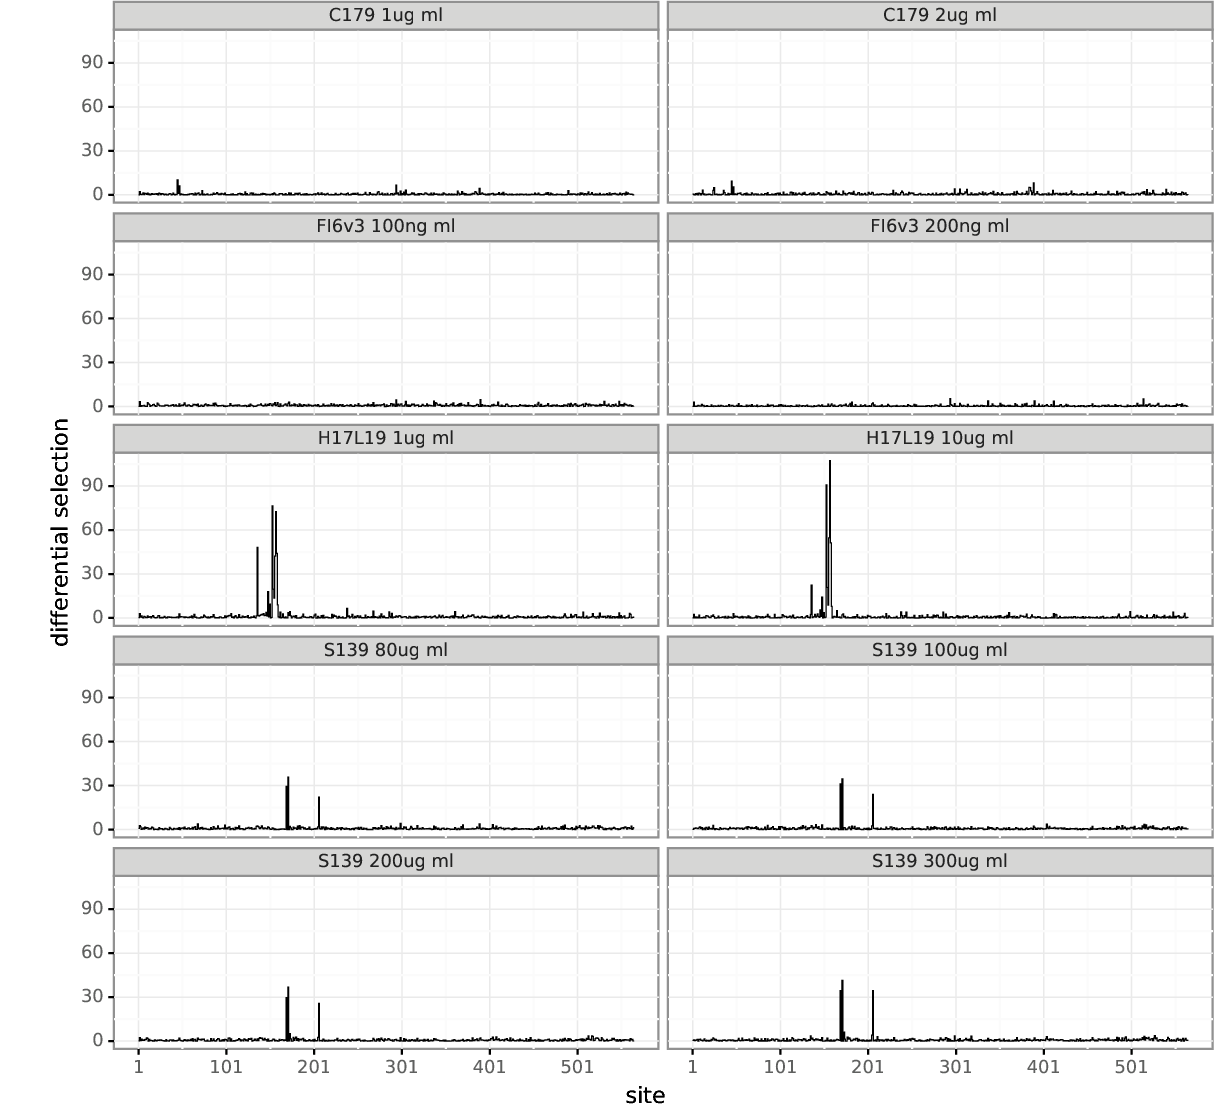

In [48]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

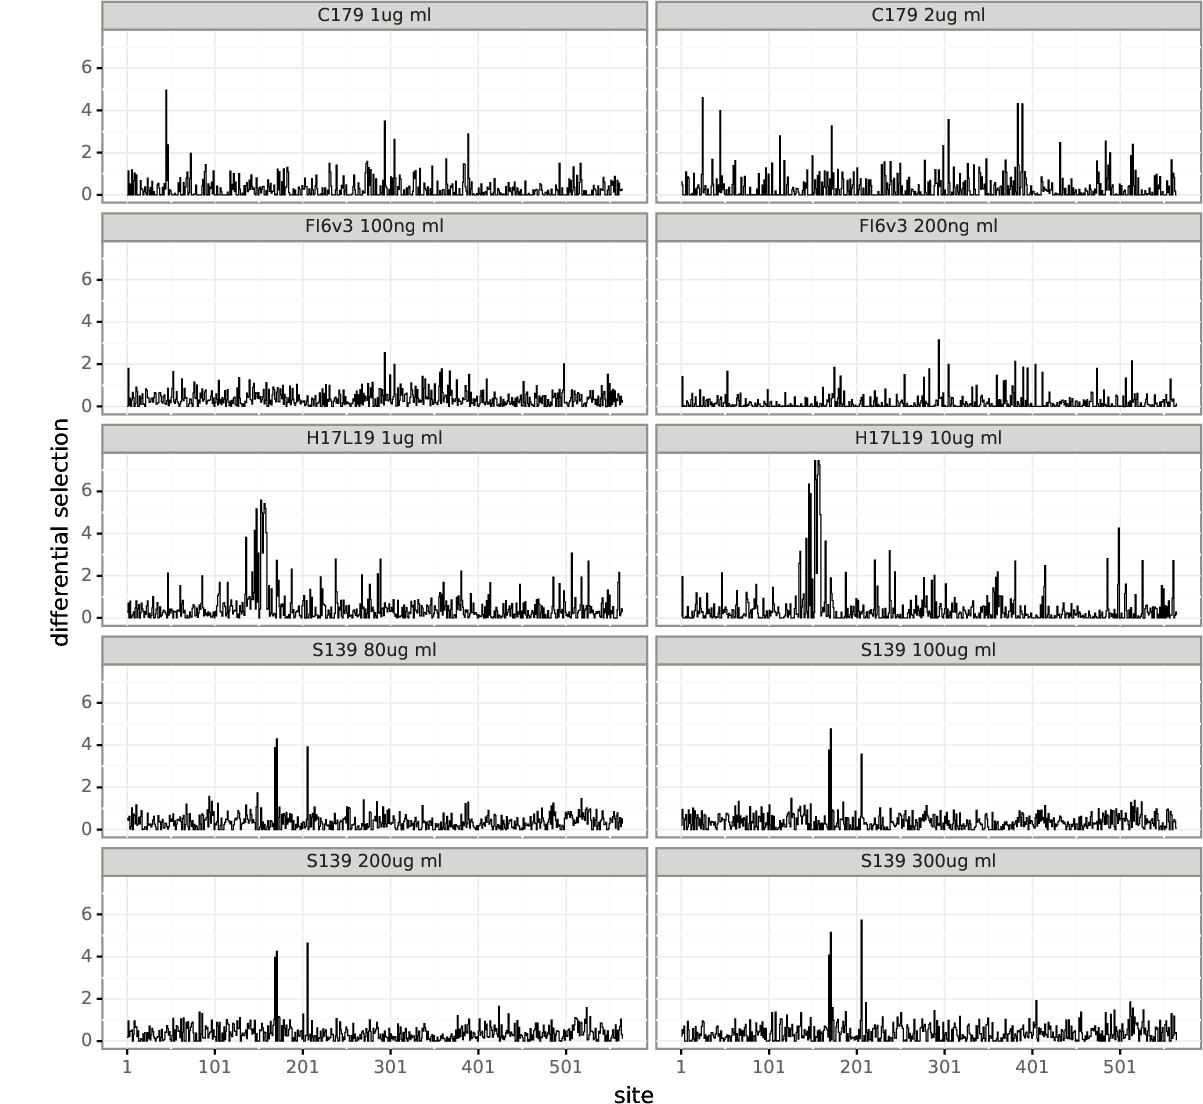

In [49]:
showPDF(diffselprefix + 'medianmaxdiffsel.pdf', width=800)

In [50]:
!head -9 {diffseldir}/summary_C179-2ug-ml-medianmutdiffsel.csv

site,wildtype,mutation,mutdiffsel
25,H,V,4.6053426467176
384,T,S,4.3159613271757165
389,N,R,4.313719166254916
45,H,S,3.991585539854699
305,N,S,3.5625634722205297
172,D,P,3.262908811992676
113,I,F,2.7892964742426116
484,Y,H,2.542420293660709


In [51]:
!head -9 {diffseldir}/summary_FI6v3-200ng-ml-medianmutdiffsel.csv

site,wildtype,mutation,mutdiffsel
294,K,S,3.1463069652441478
294,K,T,2.3478990494125638
514,E,K,2.1621874283468703
381,Q,V,2.13538804586721
305,N,S,1.9959267425193787
404,T,R,1.994879051997886
390,G,R,1.8609866730772975
175,P,L,1.846561638990654


Calculate the median for C179 and FI6v3 across the the two concentrations.

In [54]:
for ab in ['C179', 'FI6v3']:
    medianmutdiffsel_files = glob.glob('{0}/summary_{1}-*-ml-medianmutdiffsel.csv'.format(diffseldir, ab))
    mediandf = dms_tools2.diffsel.avgMutDiffSel(medianmutdiffsel_files, 'median')
    mediansitedf = dms_tools2.diffsel.mutToSiteDiffSel(mediandf)
    mediandf.to_csv('{0}/summary_{1}-medianmutdiffsel.csv'.format(diffseldir, ab), index = False)
    mediansitedf.to_csv('{0}/summary_{1}-mediansitediffsel.csv'.format(diffseldir, ab), index = False)

In [55]:
!head -9 {diffseldir}/summary_C179-medianmutdiffsel.csv

site,wildtype,mutation,mutdiffsel
45,H,S,4.478589457460674
389,N,R,3.5998367508240072
305,N,S,3.094255866053377
384,T,S,2.889080909932859
25,H,V,2.40126780959801
294,K,S,2.3368332091411315
172,D,P,2.238311407366867
45,H,G,1.9061324610126116


## Create logoplots of differential selection


Creating logo plot for S139-300ug-ml from ./results/differential_selections/summary_S139-300ug-ml-medianmutdiffsel.csv


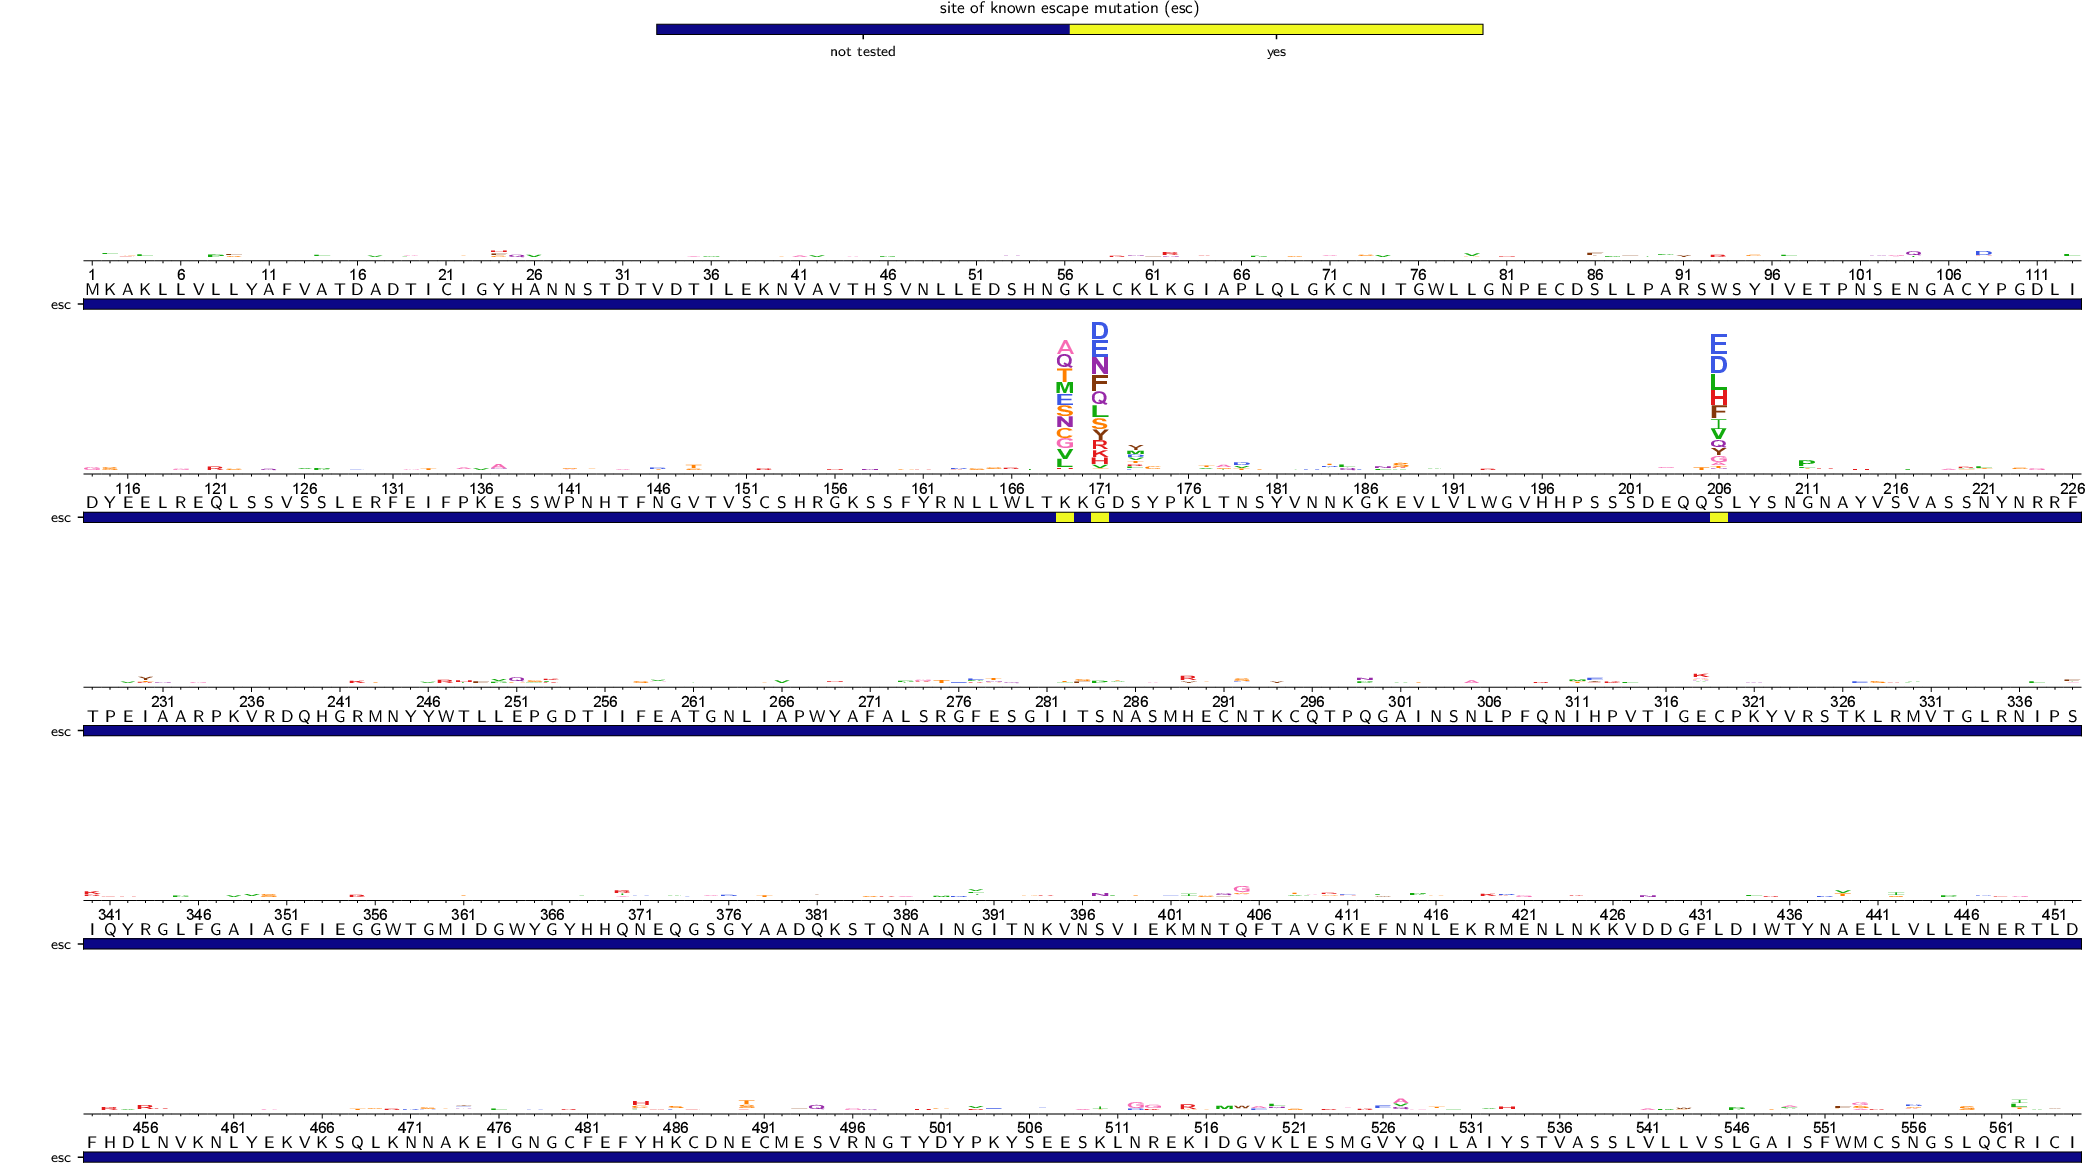


Creating logo plot for S139-200ug-ml from ./results/differential_selections/summary_S139-200ug-ml-medianmutdiffsel.csv


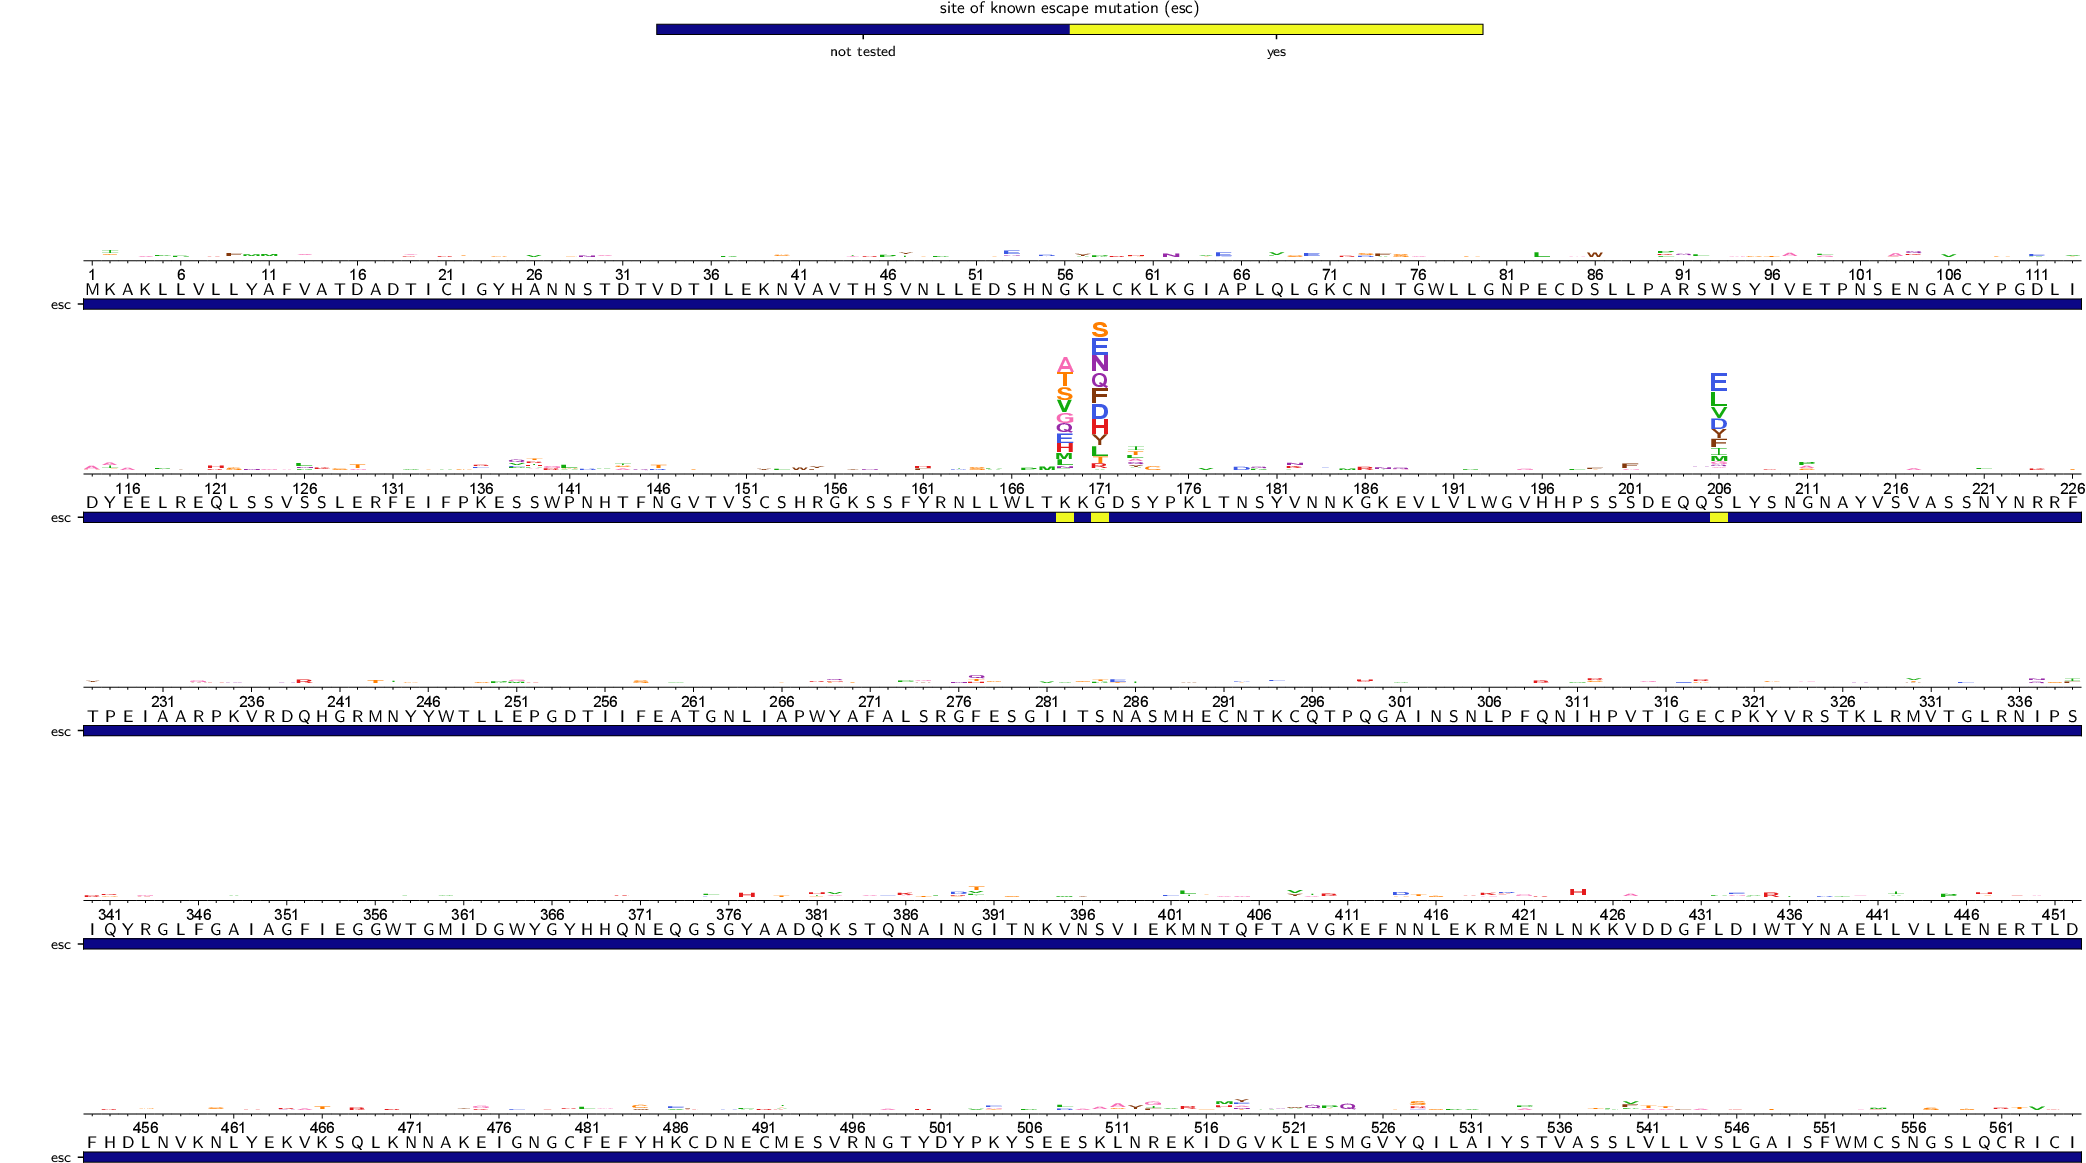

In [57]:
known = pd.read_csv('./data/known_escape.csv', index_col='site')

for antibody in ['S139-300ug-ml', 'S139-200ug-ml']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # create known sites overlay file to pass to dms2_logoplot
    sites = pd.read_csv(mutdiffsel)['site'].unique()
    antibodyname = antibody.split('-')[0]
    knownsites = diffselprefix + '{0}_known_escape.csv'.format(antibodyname)
    (known.query('antibody == @antibodyname')
          .assign(esc='yes')
          .reindex(sites) # add entry for sites NOT known to mediate escape
          .reset_index()
          .drop_duplicates('site')
          .fillna('not tested')
          .to_csv(knownsites, index=False)
          )
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(plotsdir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {plotsdir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 5 \
            --nperline 113 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {knownsites} esc "site of known escape mutation" \
            --underlay yes \
            --overlaycolormap plasma \
            --use_existing {use_existing}
    showPDF(logoplot)

These logoplots show strong differential selection at the three sites previously characterized as escape mutants by [Yoshida et al (2009)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1000350) (see Figure 5): 156, 158, 193 in H3 numbering. These three sites are indicated in the underlay as known sites of escape. 


Creating logo plot for C179-2ug-ml from ./results/differential_selections/summary_C179-2ug-ml-medianmutdiffsel.csv


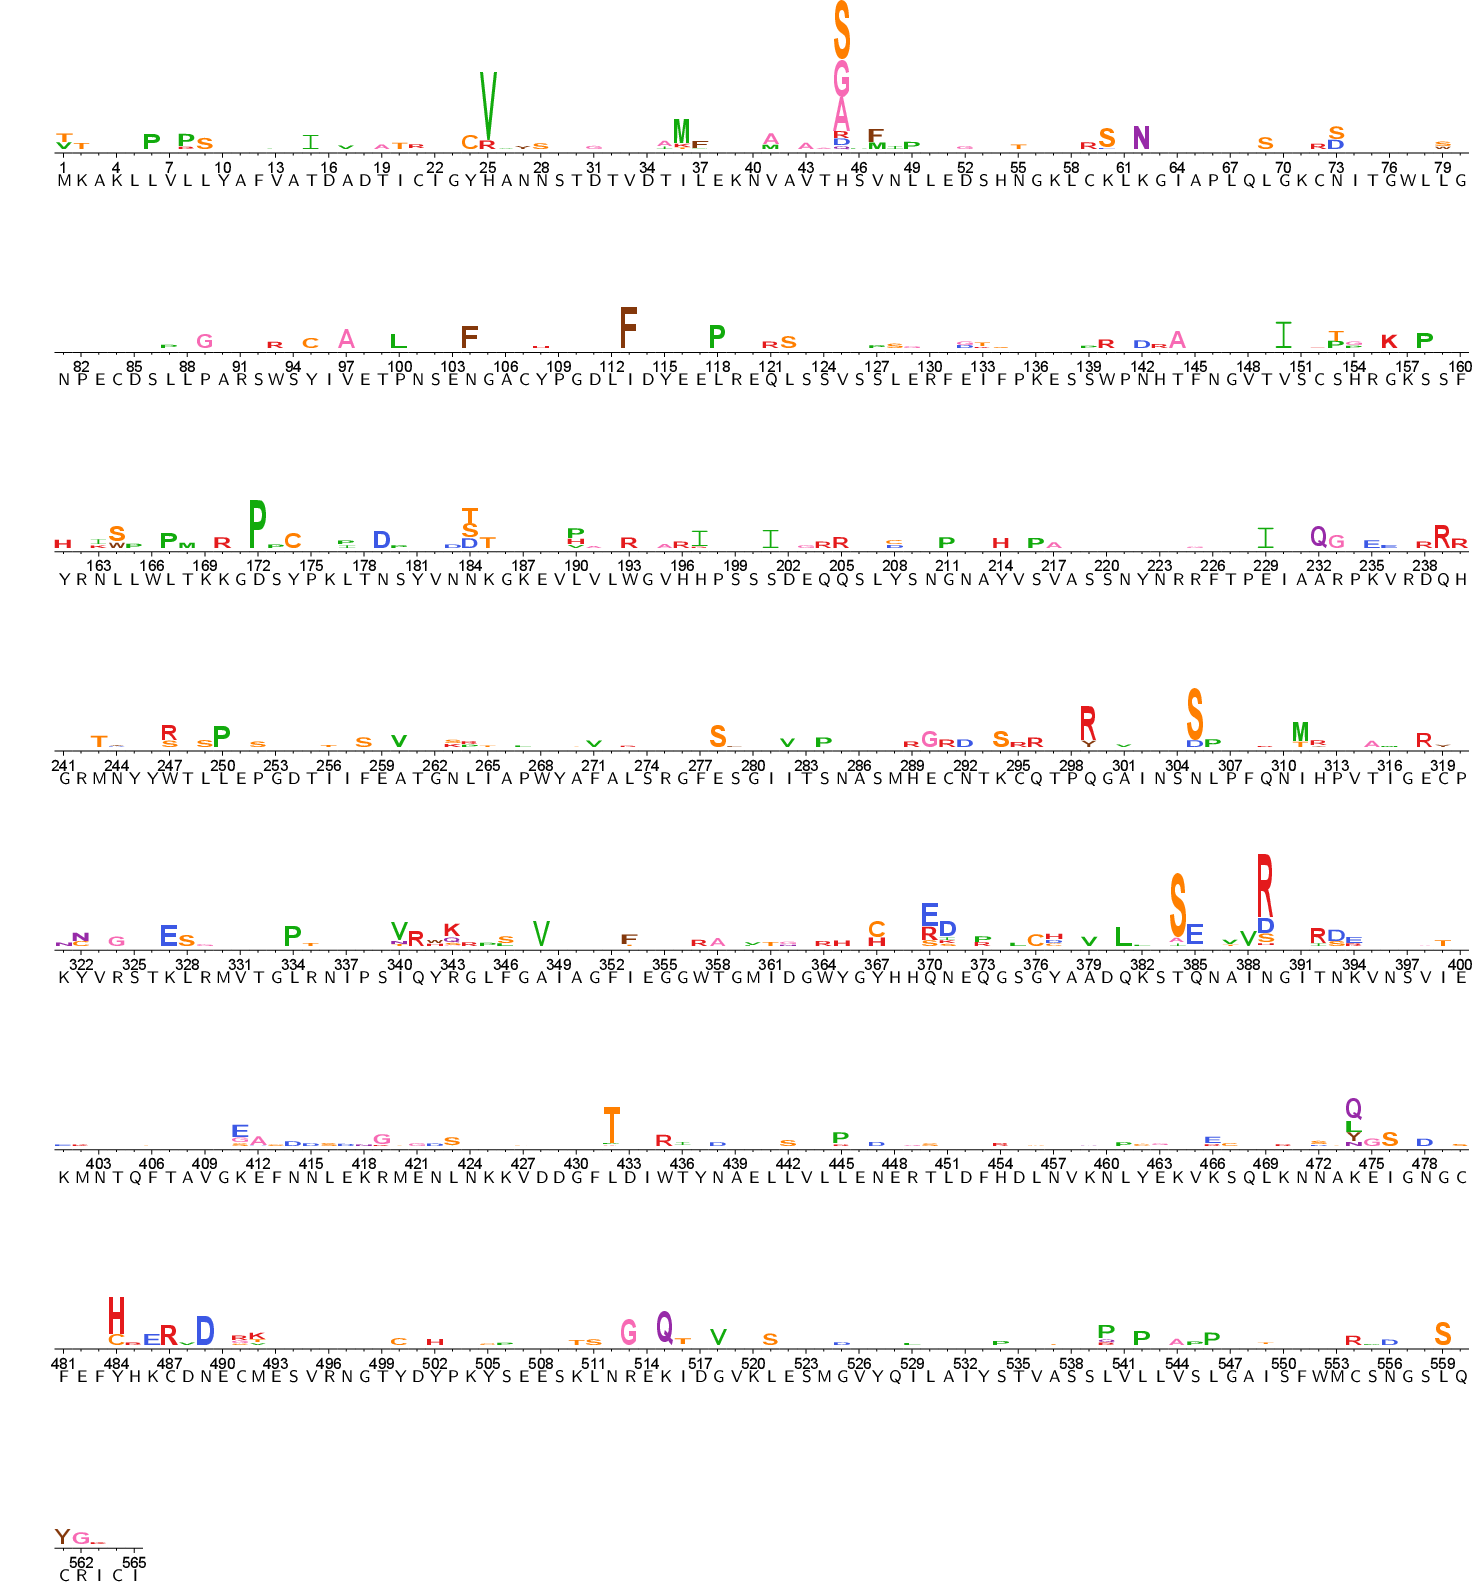


Creating logo plot for C179-1ug-ml from ./results/differential_selections/summary_C179-1ug-ml-medianmutdiffsel.csv


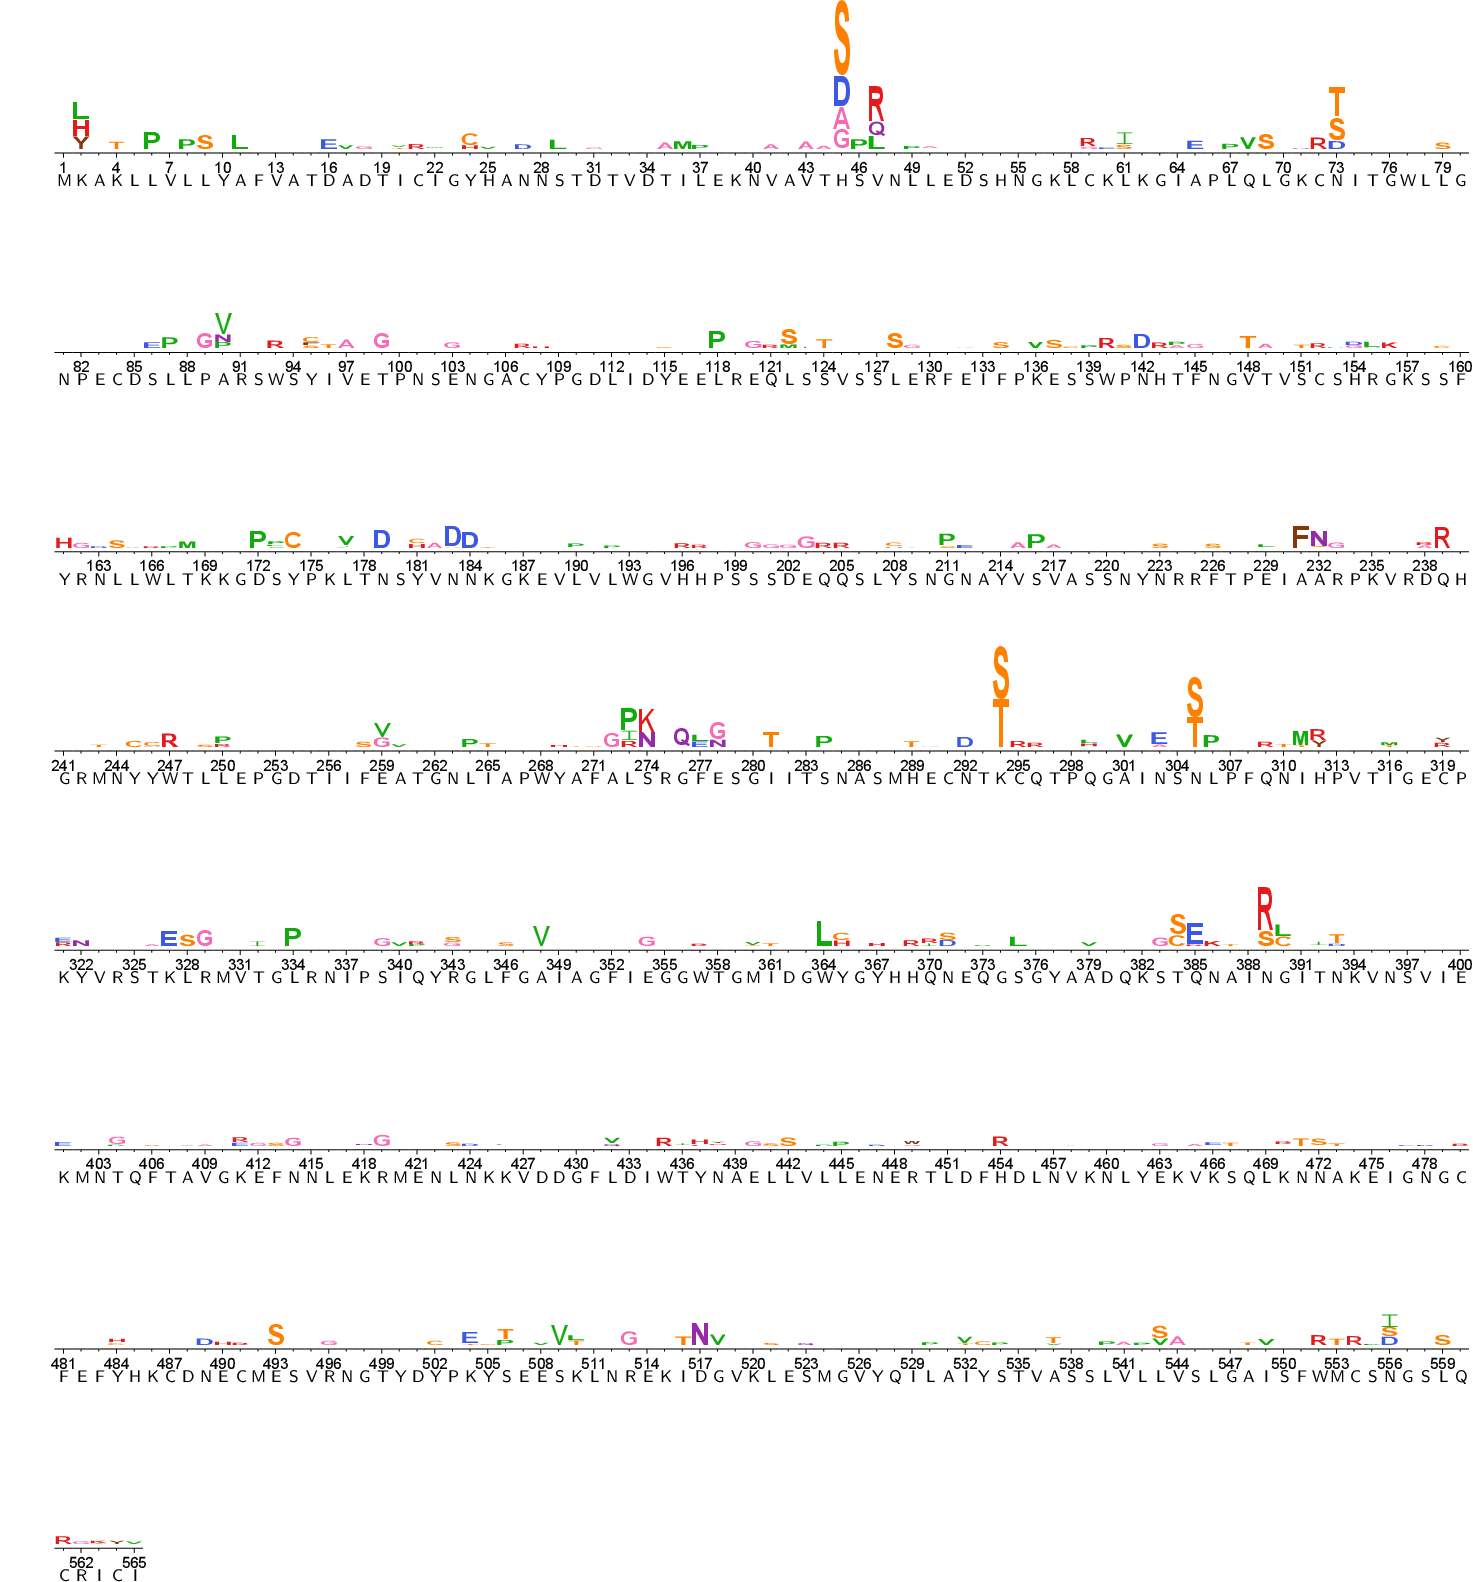


Creating logo plot for FI6v3-200ng-ml from ./results/differential_selections/summary_FI6v3-200ng-ml-medianmutdiffsel.csv


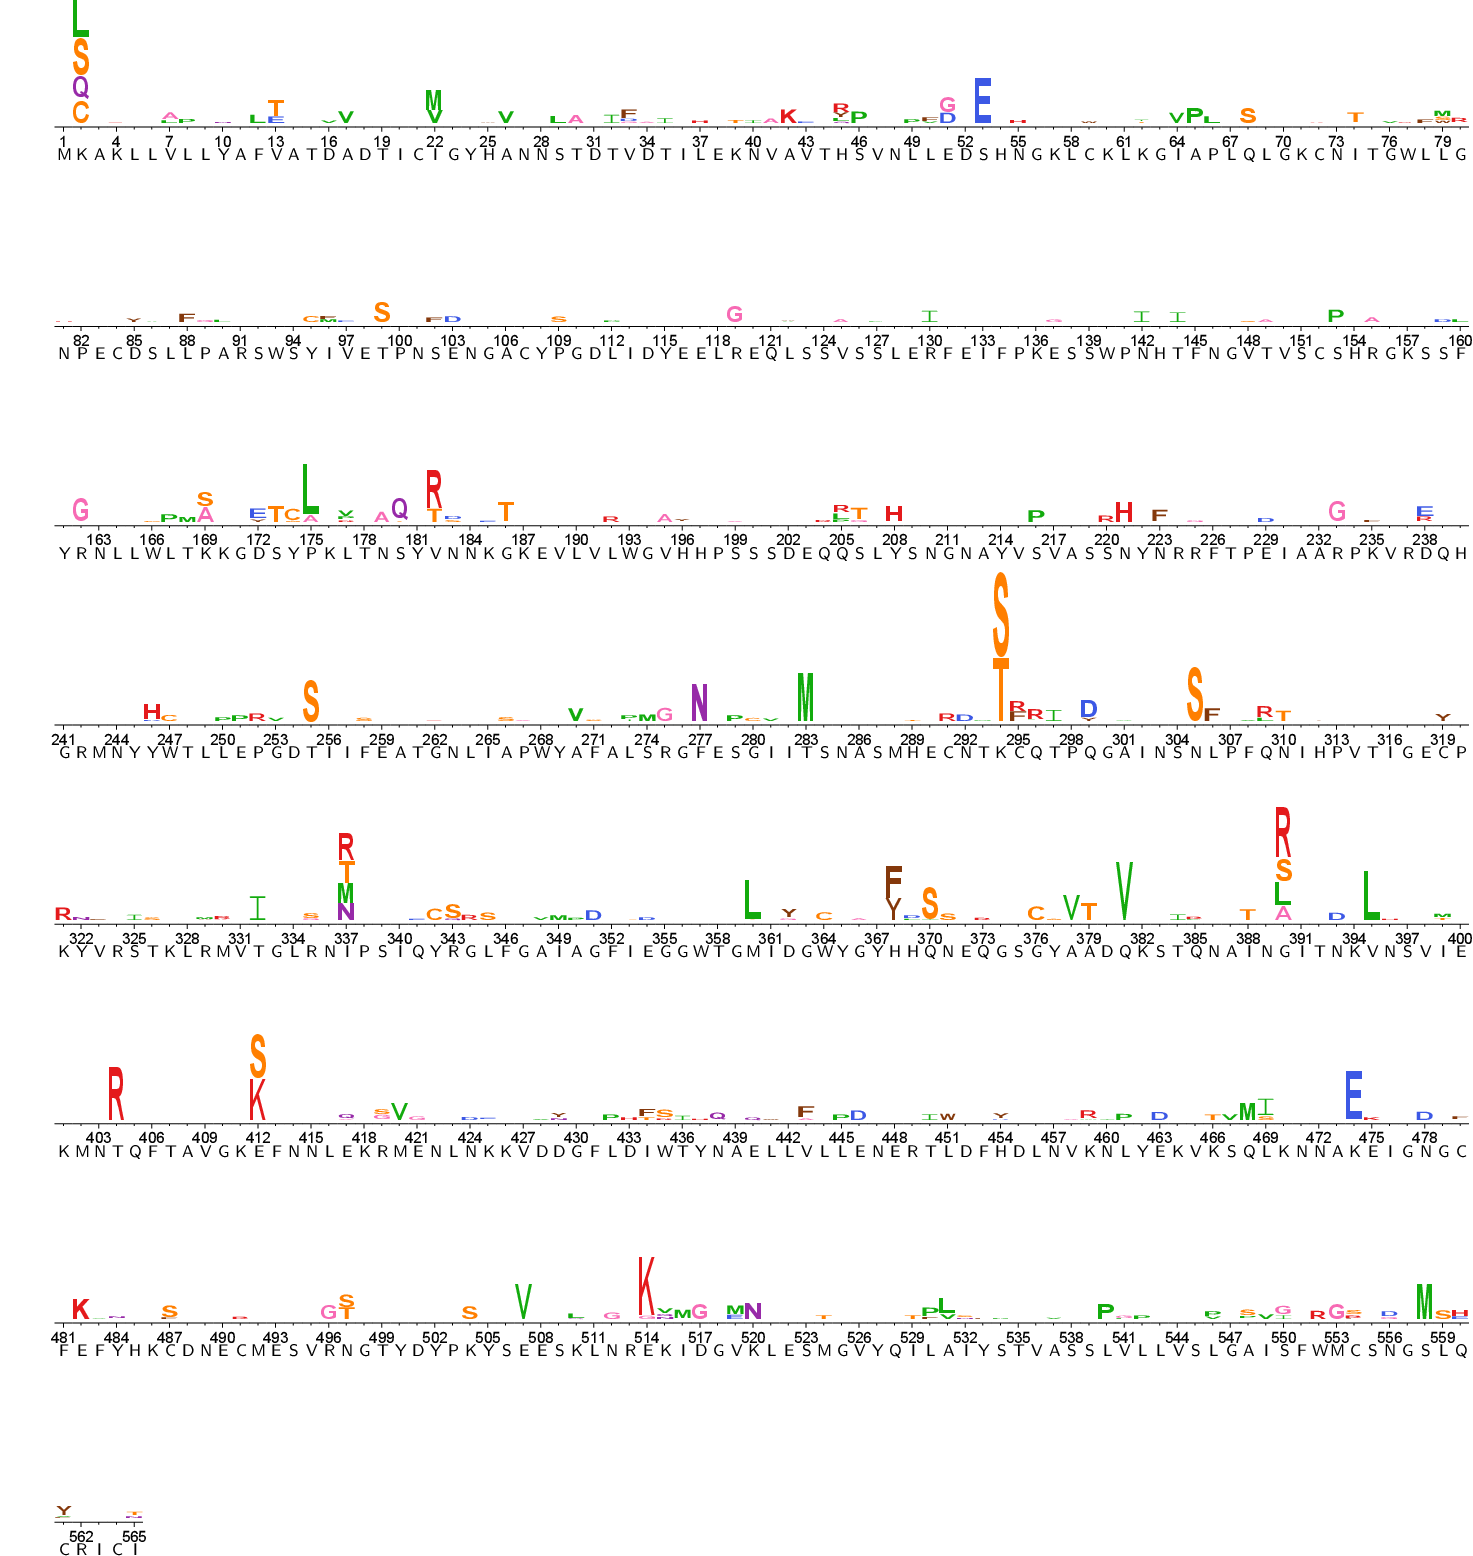


Creating logo plot for FI6v3-100ng-ml from ./results/differential_selections/summary_FI6v3-100ng-ml-medianmutdiffsel.csv


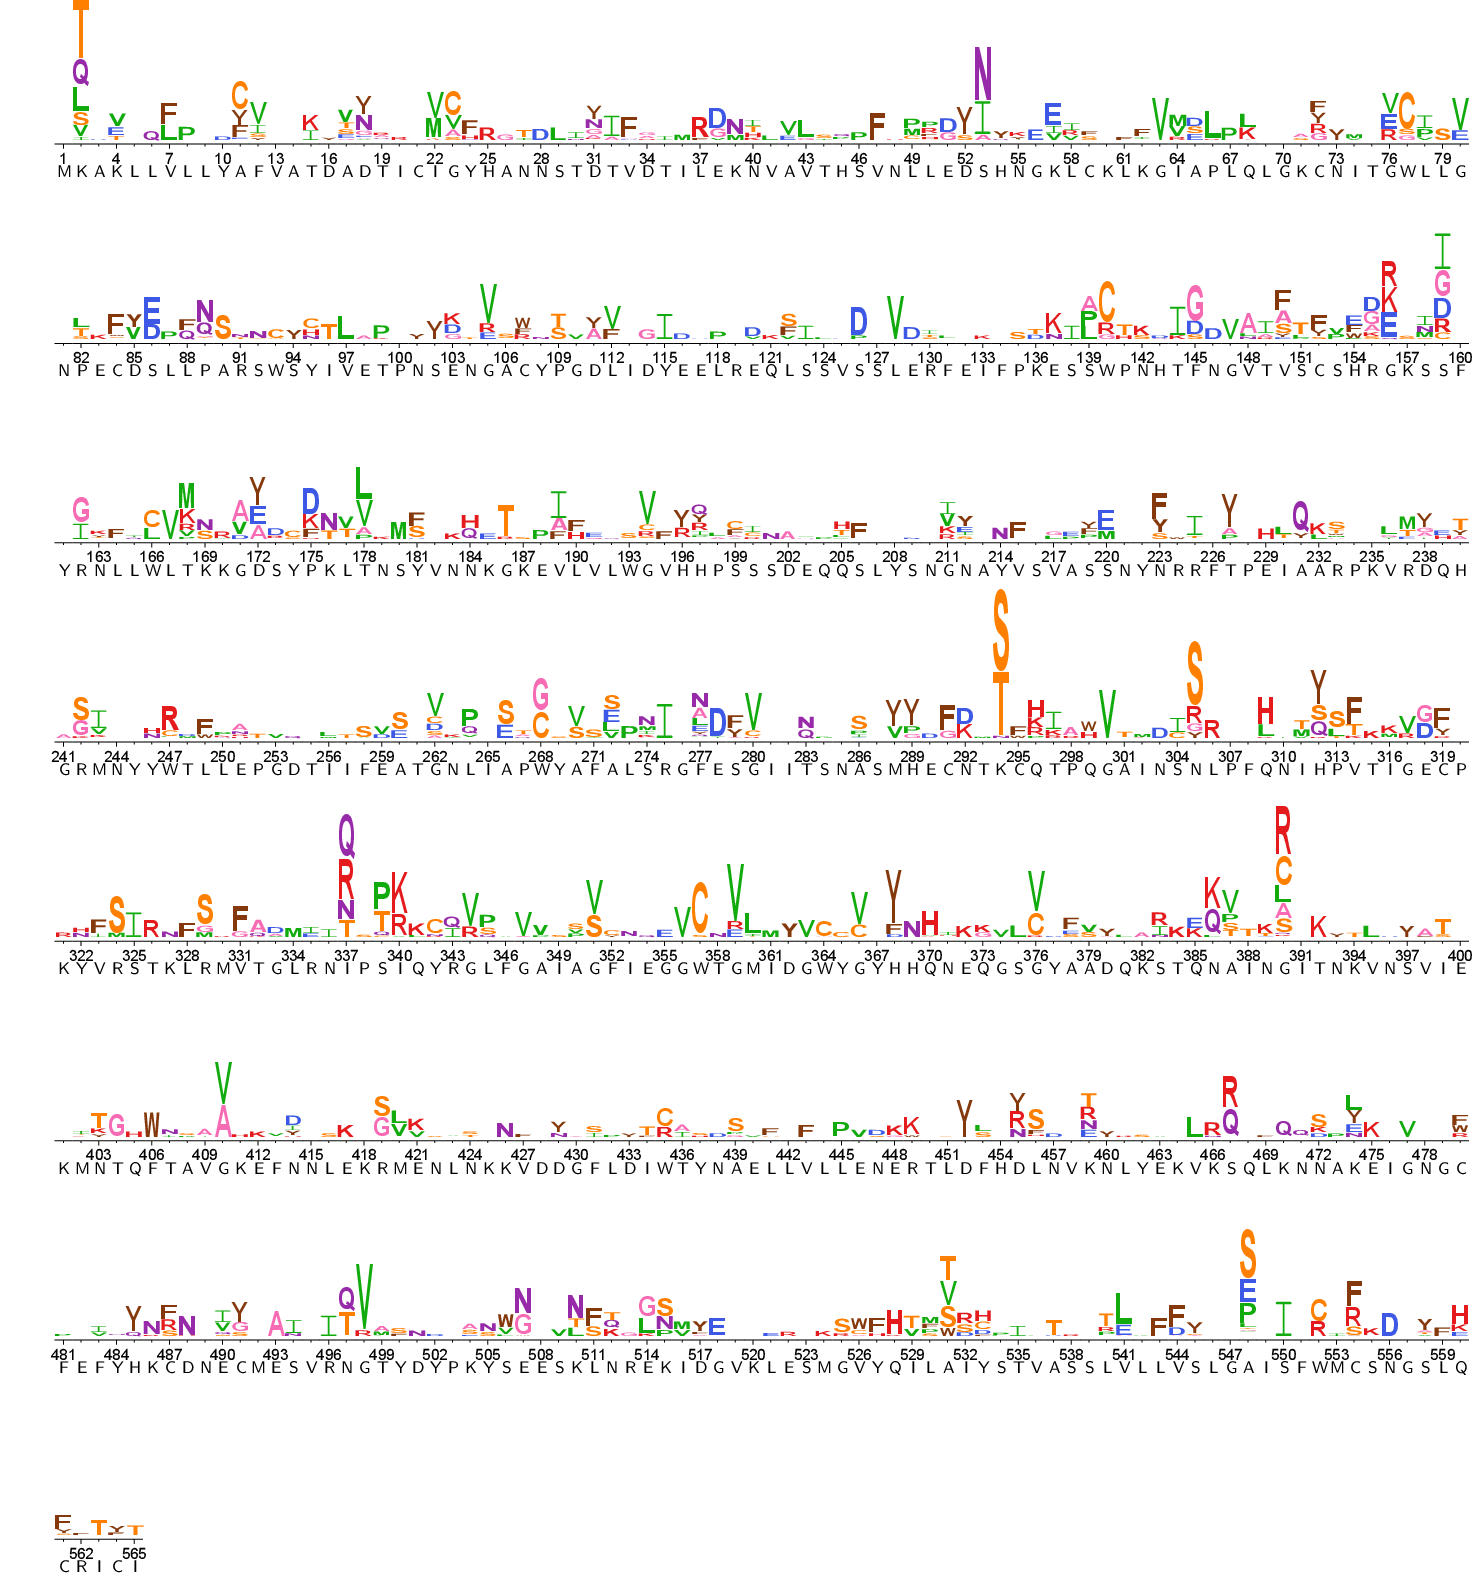


Creating logo plot for H17L19-10ug-ml from ./results/differential_selections/summary_H17L19-10ug-ml-medianmutdiffsel.csv


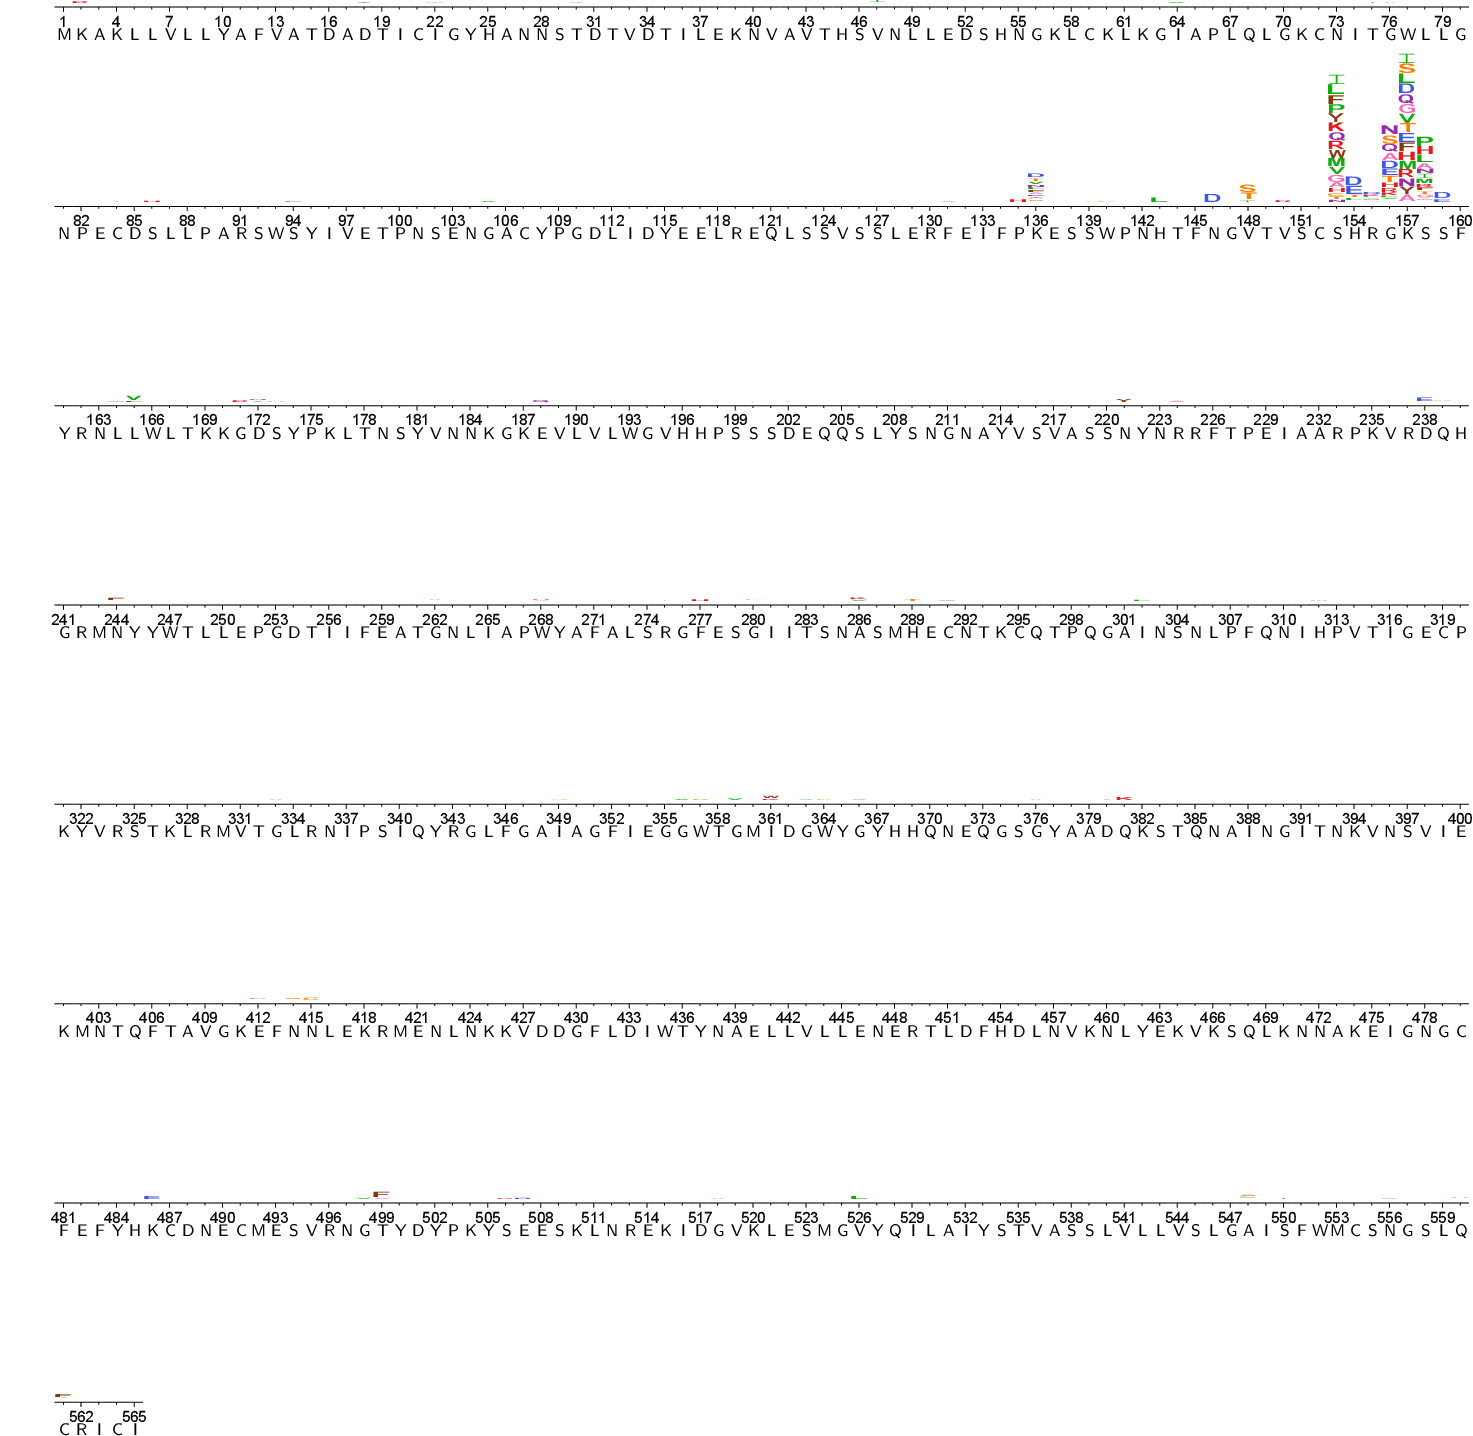

In [58]:
# Logoplots for individual concentrations
for antibody in ['C179-2ug-ml', 'C179-1ug-ml', 'FI6v3-200ng-ml', 'FI6v3-100ng-ml', 'H17L19-10ug-ml']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(plotsdir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {plotsdir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 3 \
            --nperline 80 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)


Creating logo plot for C179 from ./results/differential_selections/summary_C179-medianmutdiffsel.csv


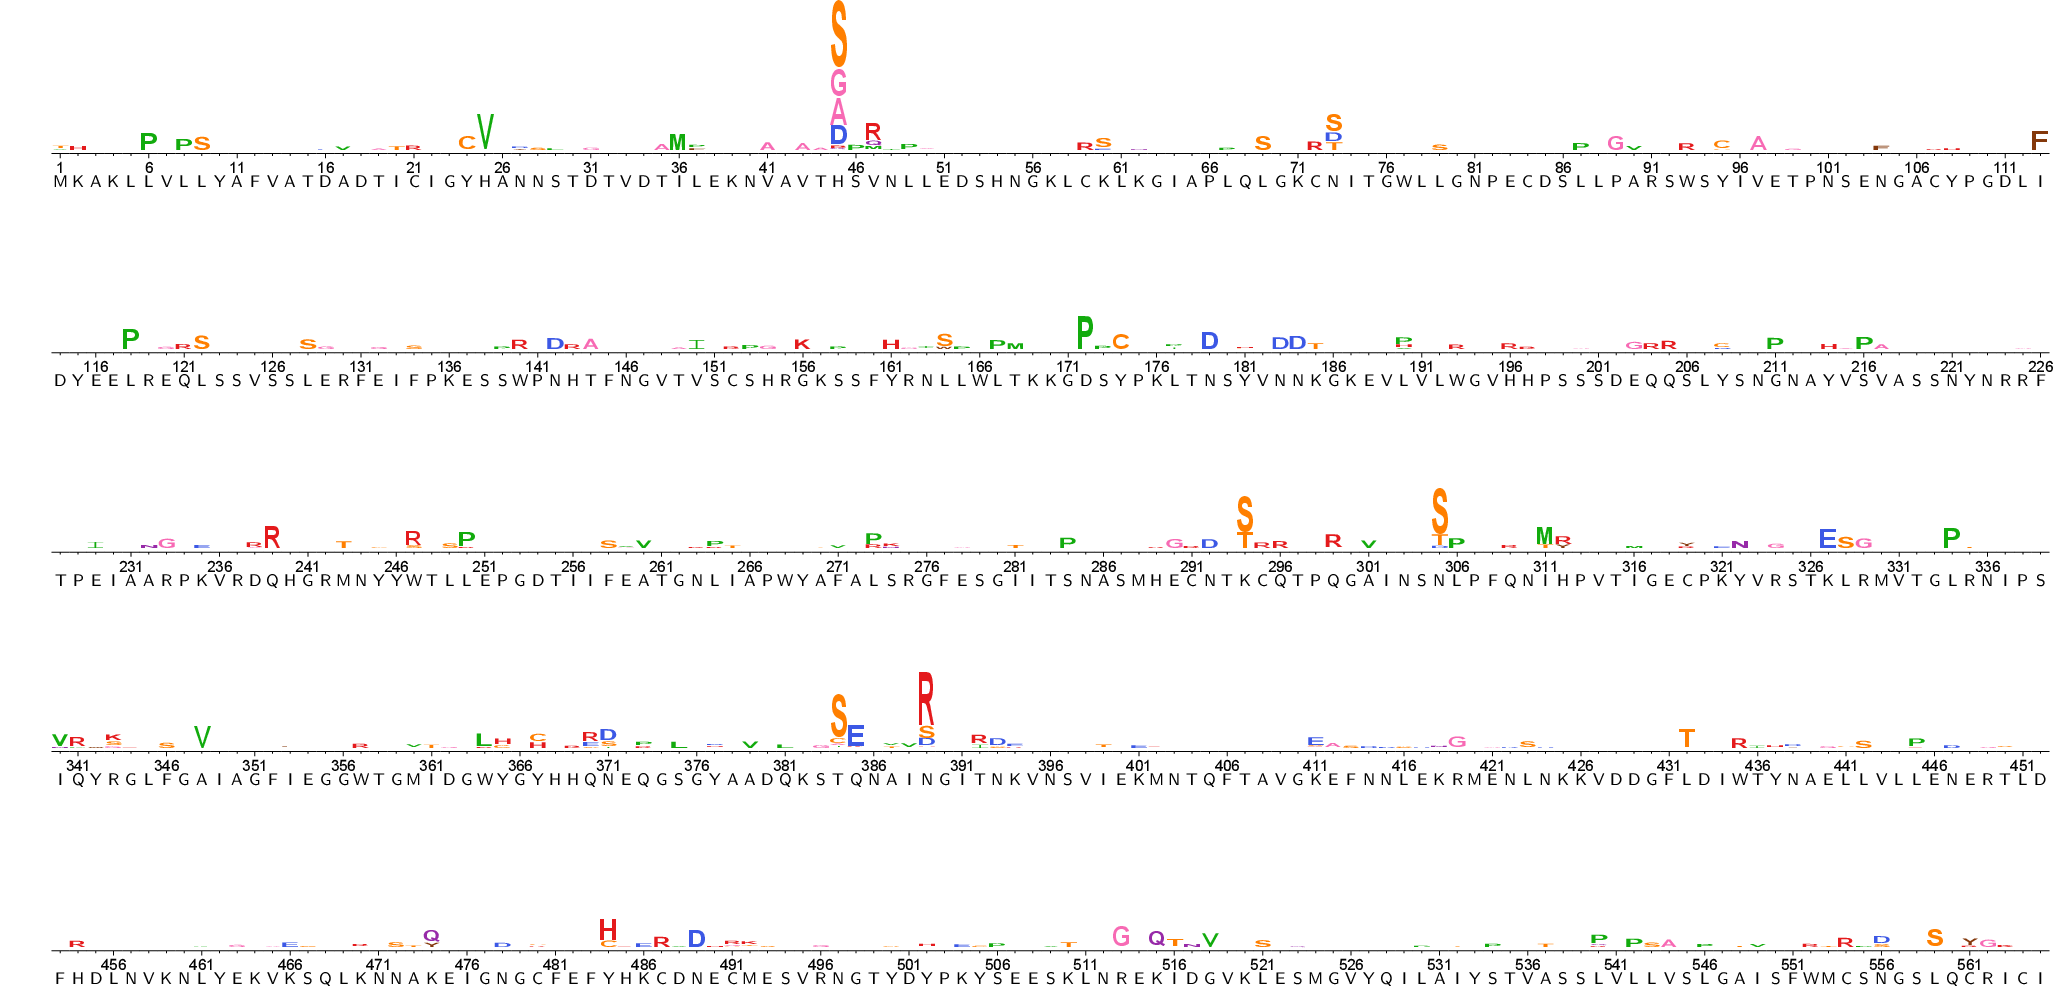


Creating logo plot for FI6v3 from ./results/differential_selections/summary_FI6v3-medianmutdiffsel.csv


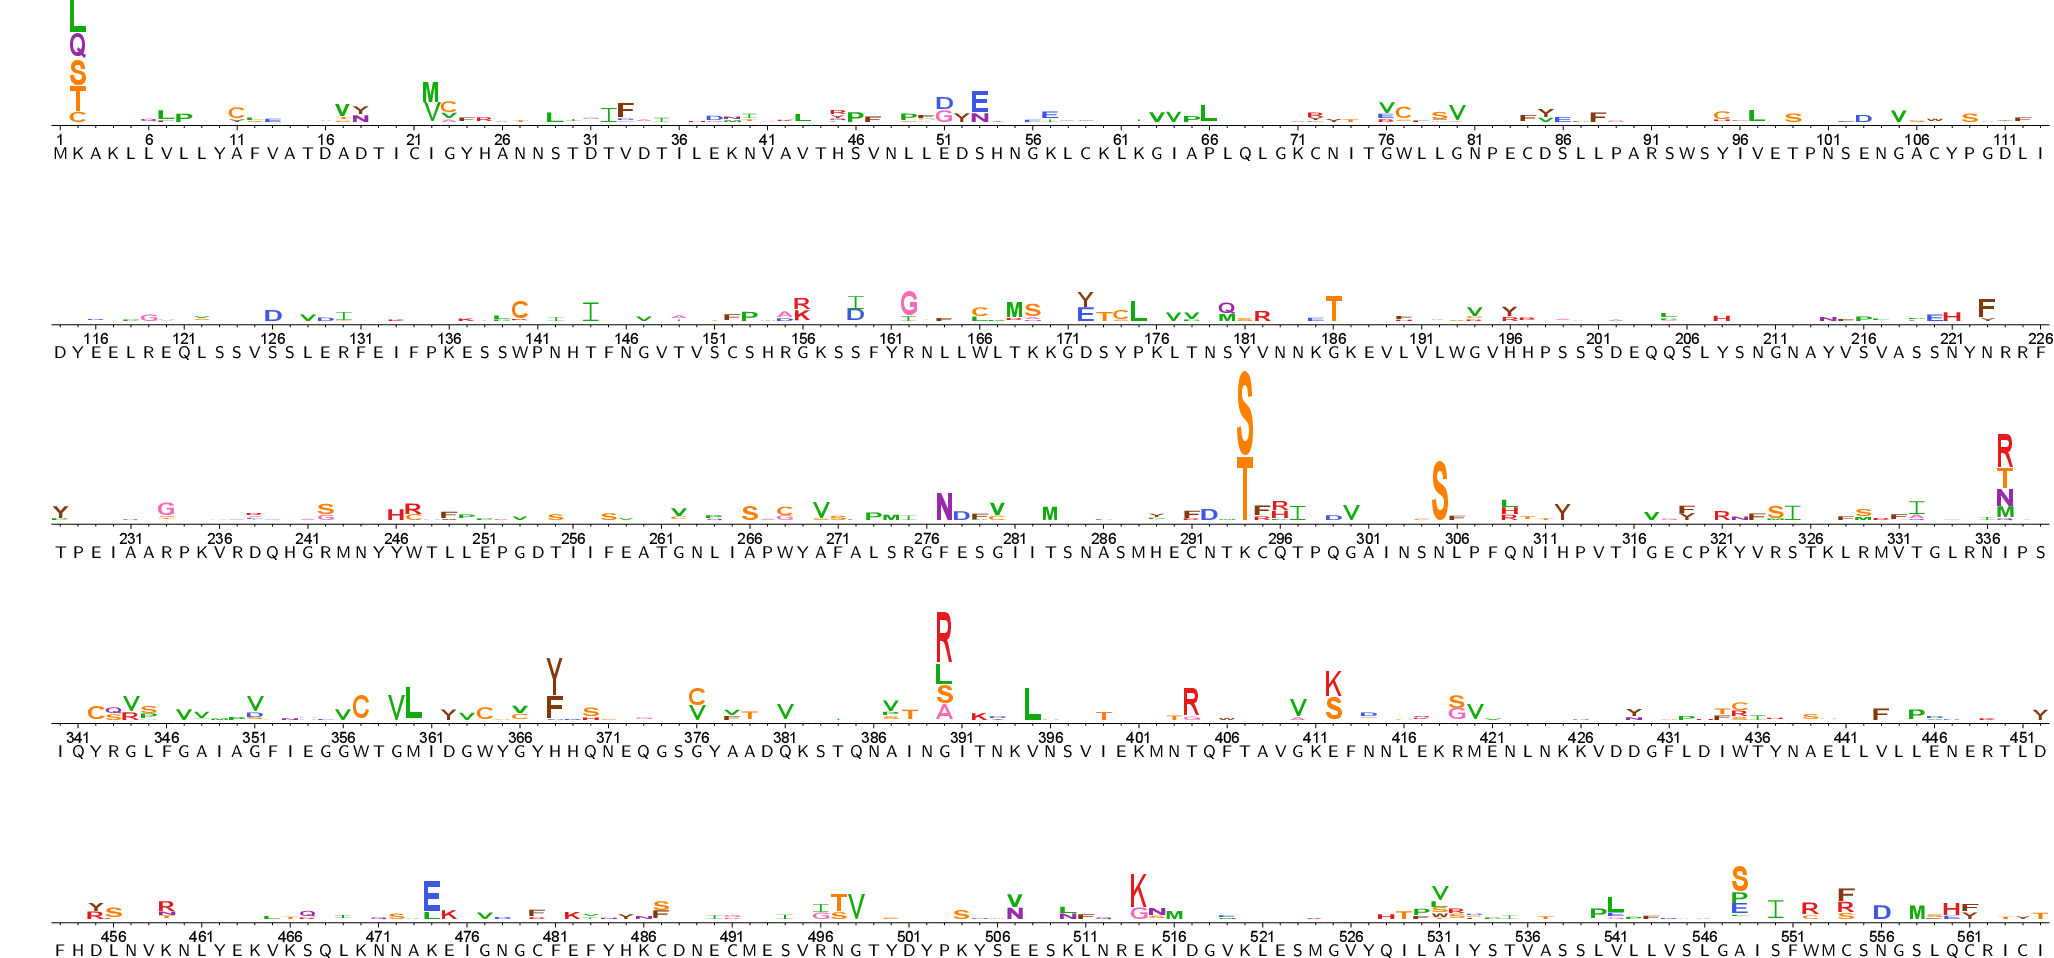

In [59]:
# Logoplots for C179 and FI6v3 averaged across concentrations
for antibody in ['C179', 'FI6v3']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(plotsdir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {plotsdir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 5 \
            --nperline 113 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing no
    showPDF(logoplot)

As can be seen in the logoplots above, differential selections for C179 and FI6v3 are noisier when only considering replicates within a single concentration. Averaging across all of the replicates reduces much of this noise.

# Quantifying the ease of escape from different antibodies

Here we will implement `dms2_batch_fracsurvive` to evaluate the ease of escape from different antibodies. This will give us an estimate of the fraction surviving for each mutation after antibody selection. Importantly, this metric can be used to compare escape across different antibodies and different concentrations of antibodies.

We used the `diffselbatch` dataframe (defined above) and added a `libfracsurvive` column that lists the fraction of the library remaining infectious after antibody selection. This quantity was determined by qRT-PCR of RNA extracted from infected cells after library neutralization.

In [79]:
fracsurvivebatchfile = os.path.join(fracsurvivedir, 'batch.csv')

fracsurvivebatch.to_csv(fracsurvivebatchfile, index=False)

In [78]:
log = !dms2_batch_fracsurvive \
        --summaryprefix summary \
        --batchfile {fracsurvivebatchfile} \
        --outdir {fracsurvivedir} \
        --indir {countsdir} \
        --use_existing {use_existing}

### Show the correlations between replicates of maximum fraction surviving and average fraction surviving


maxfracsurvive correlations:


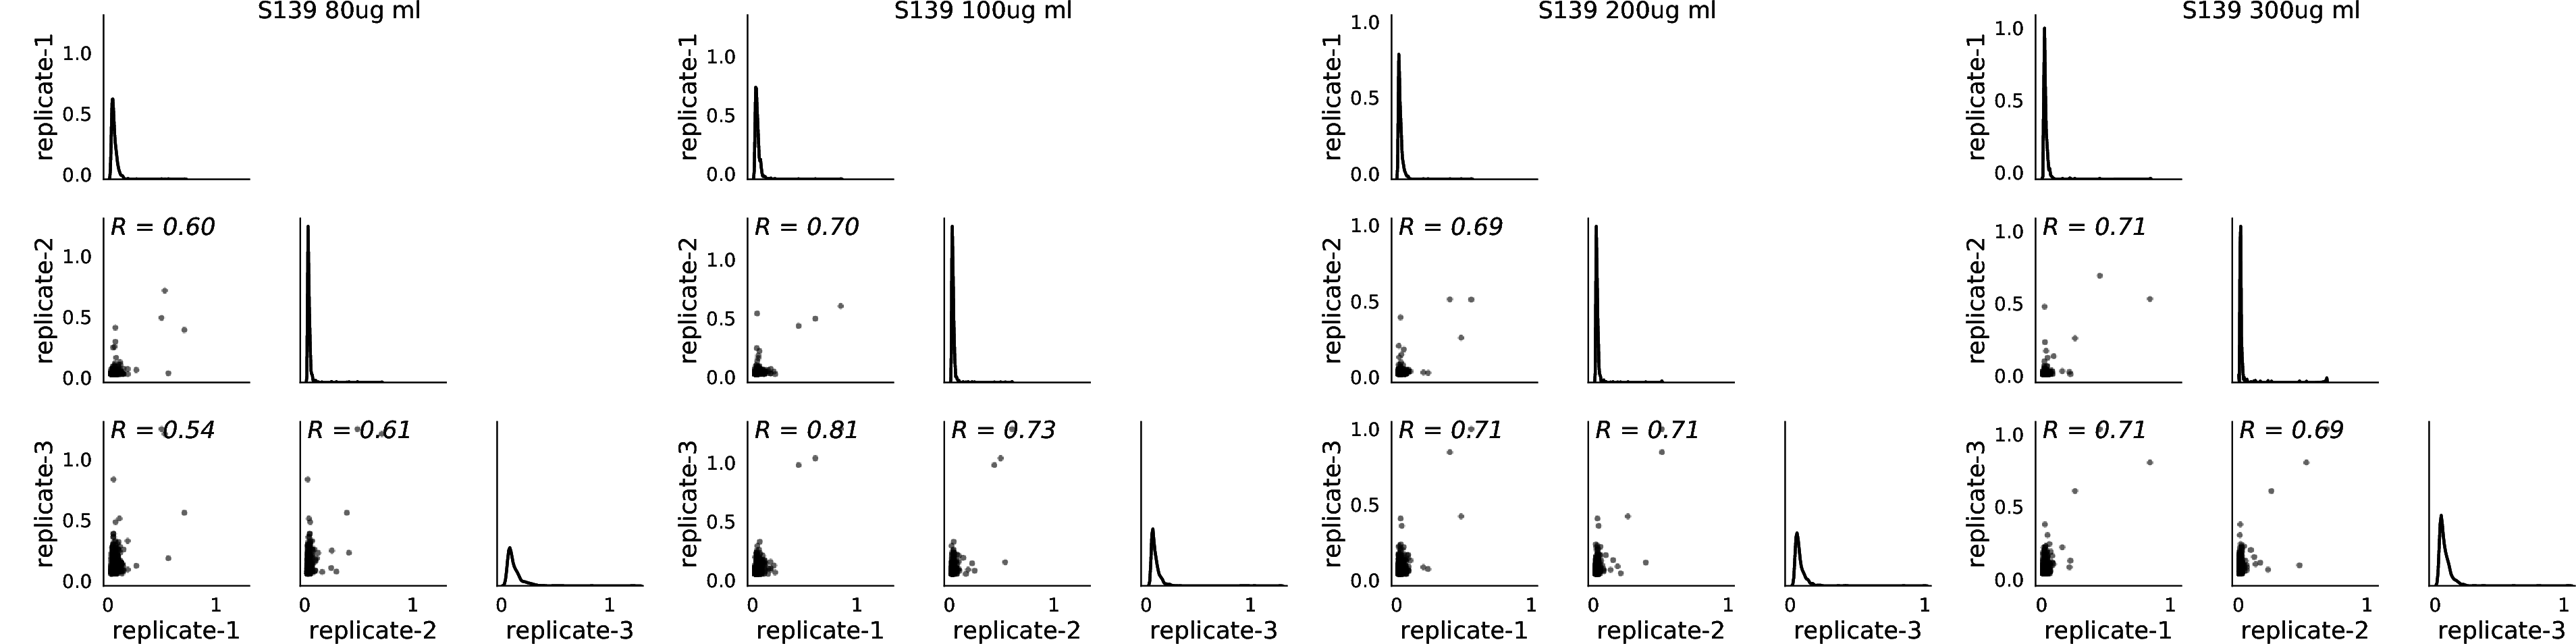

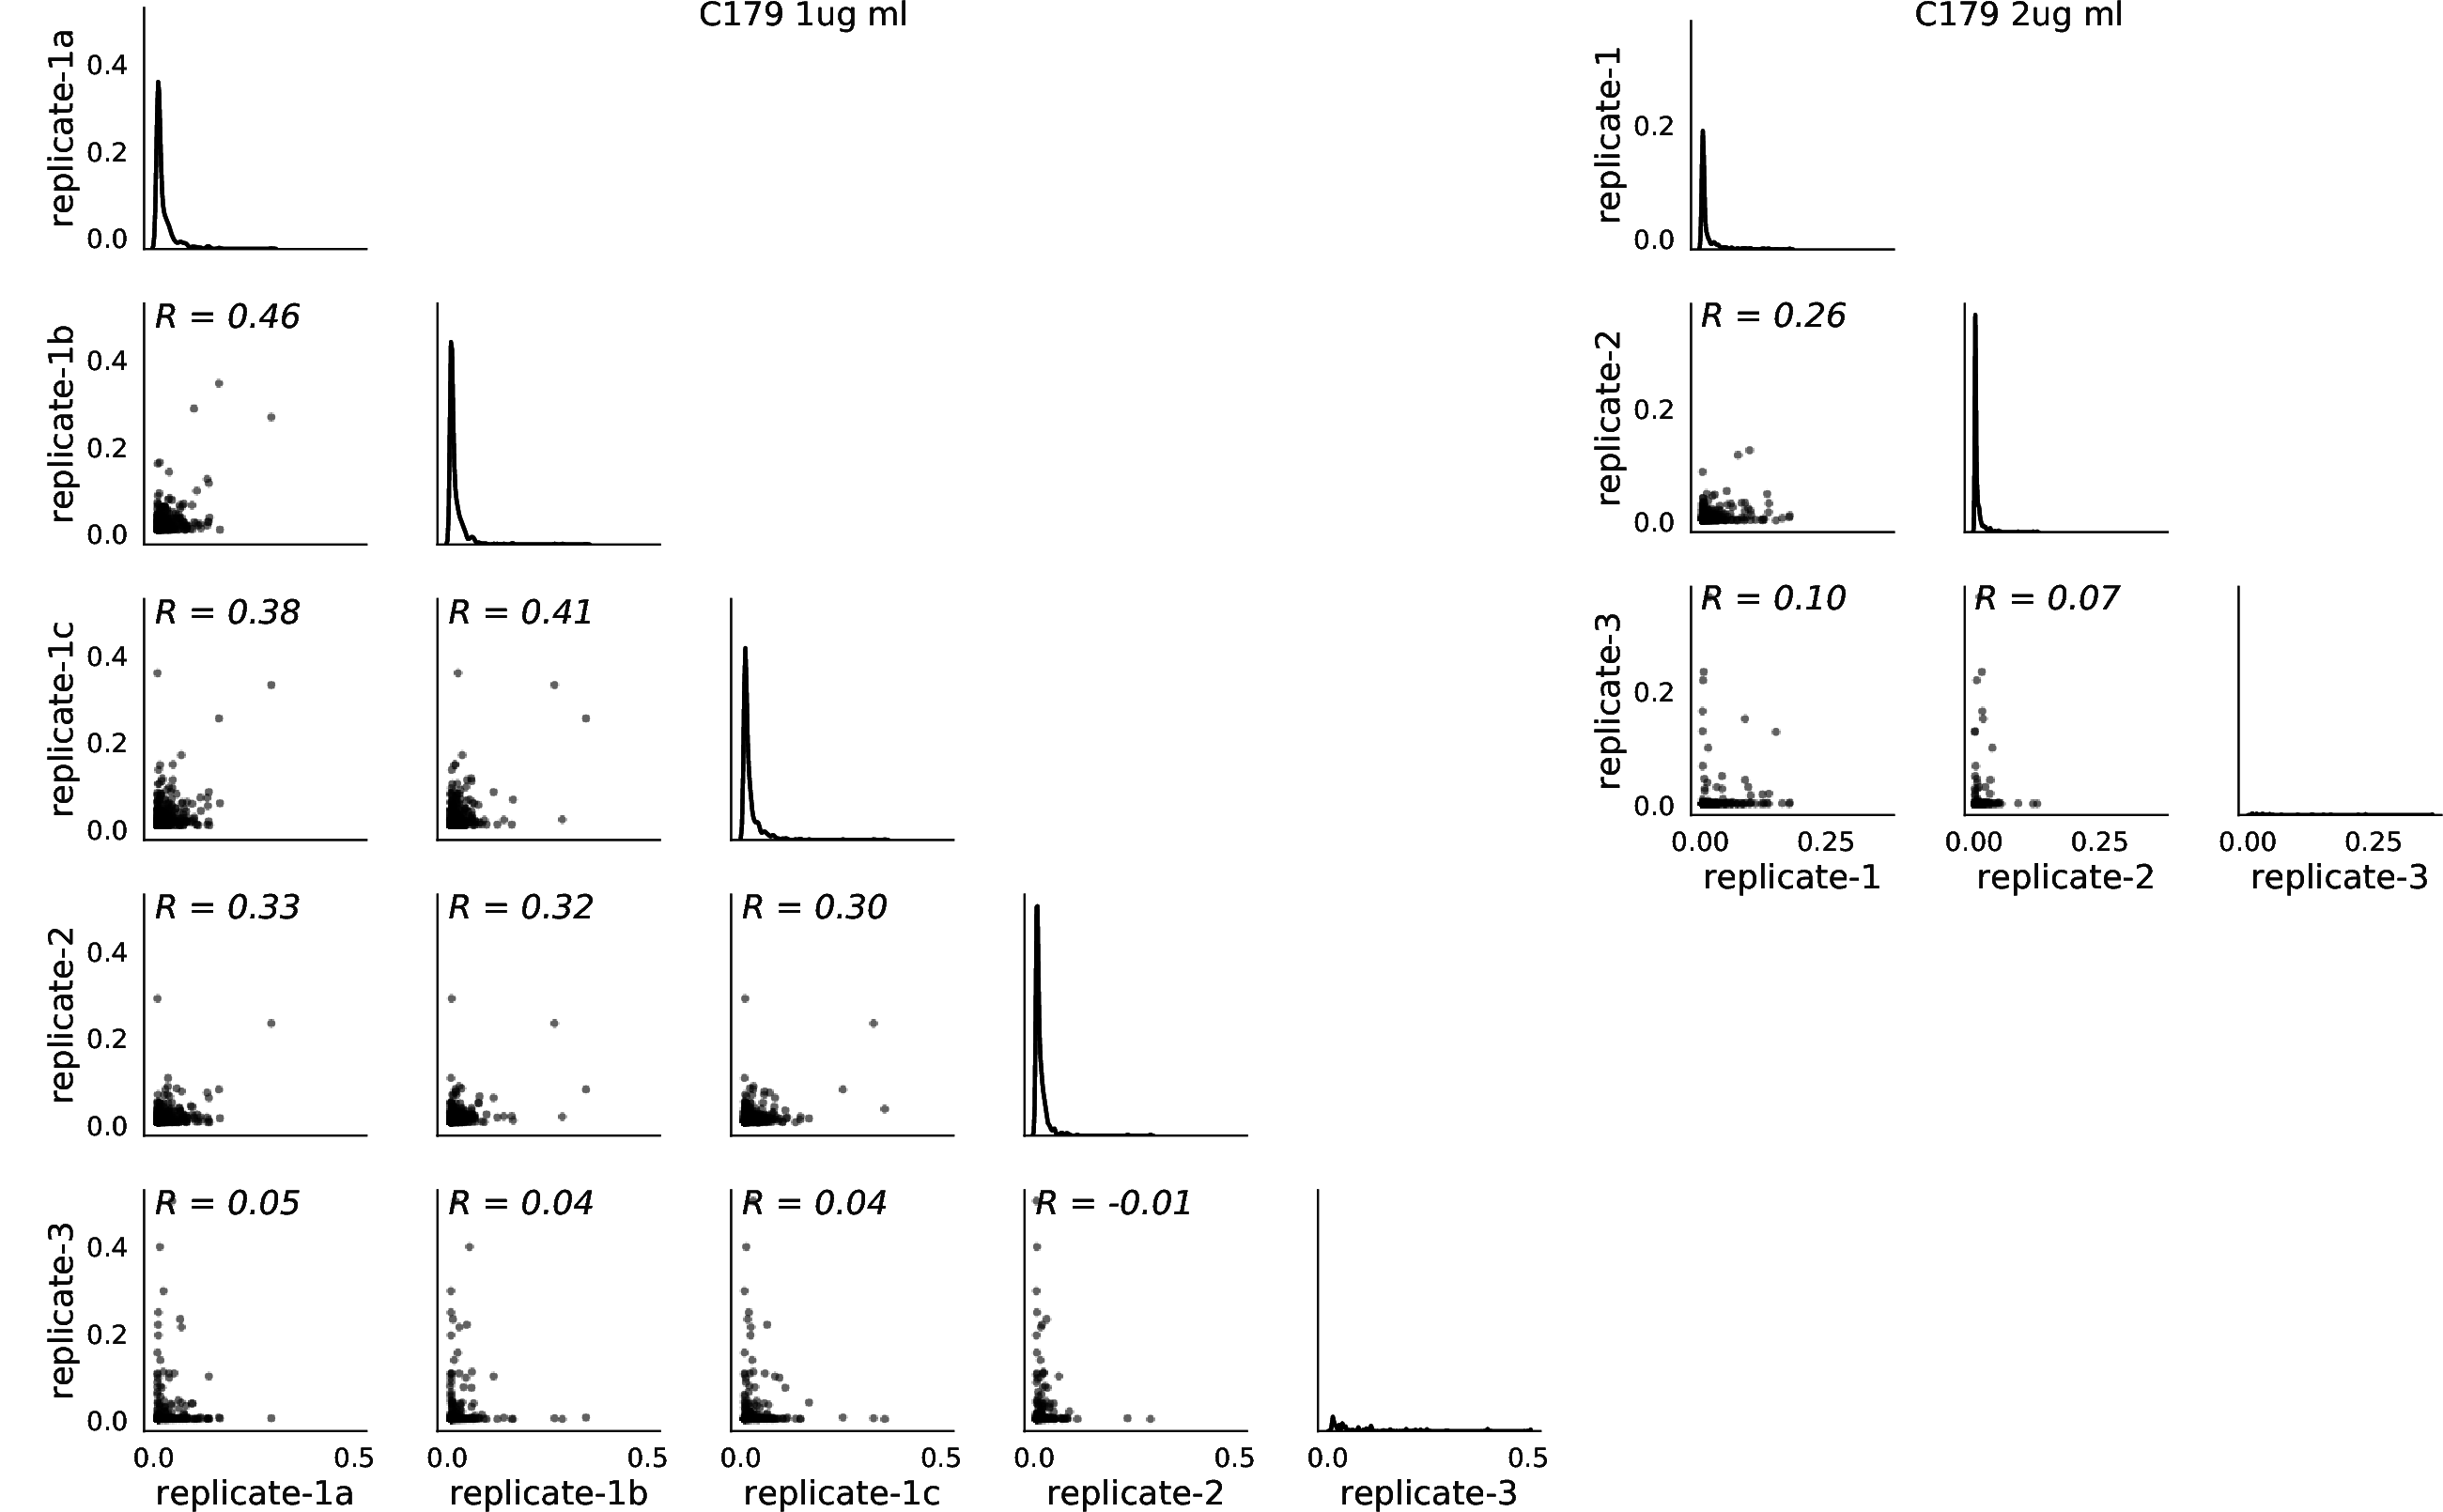

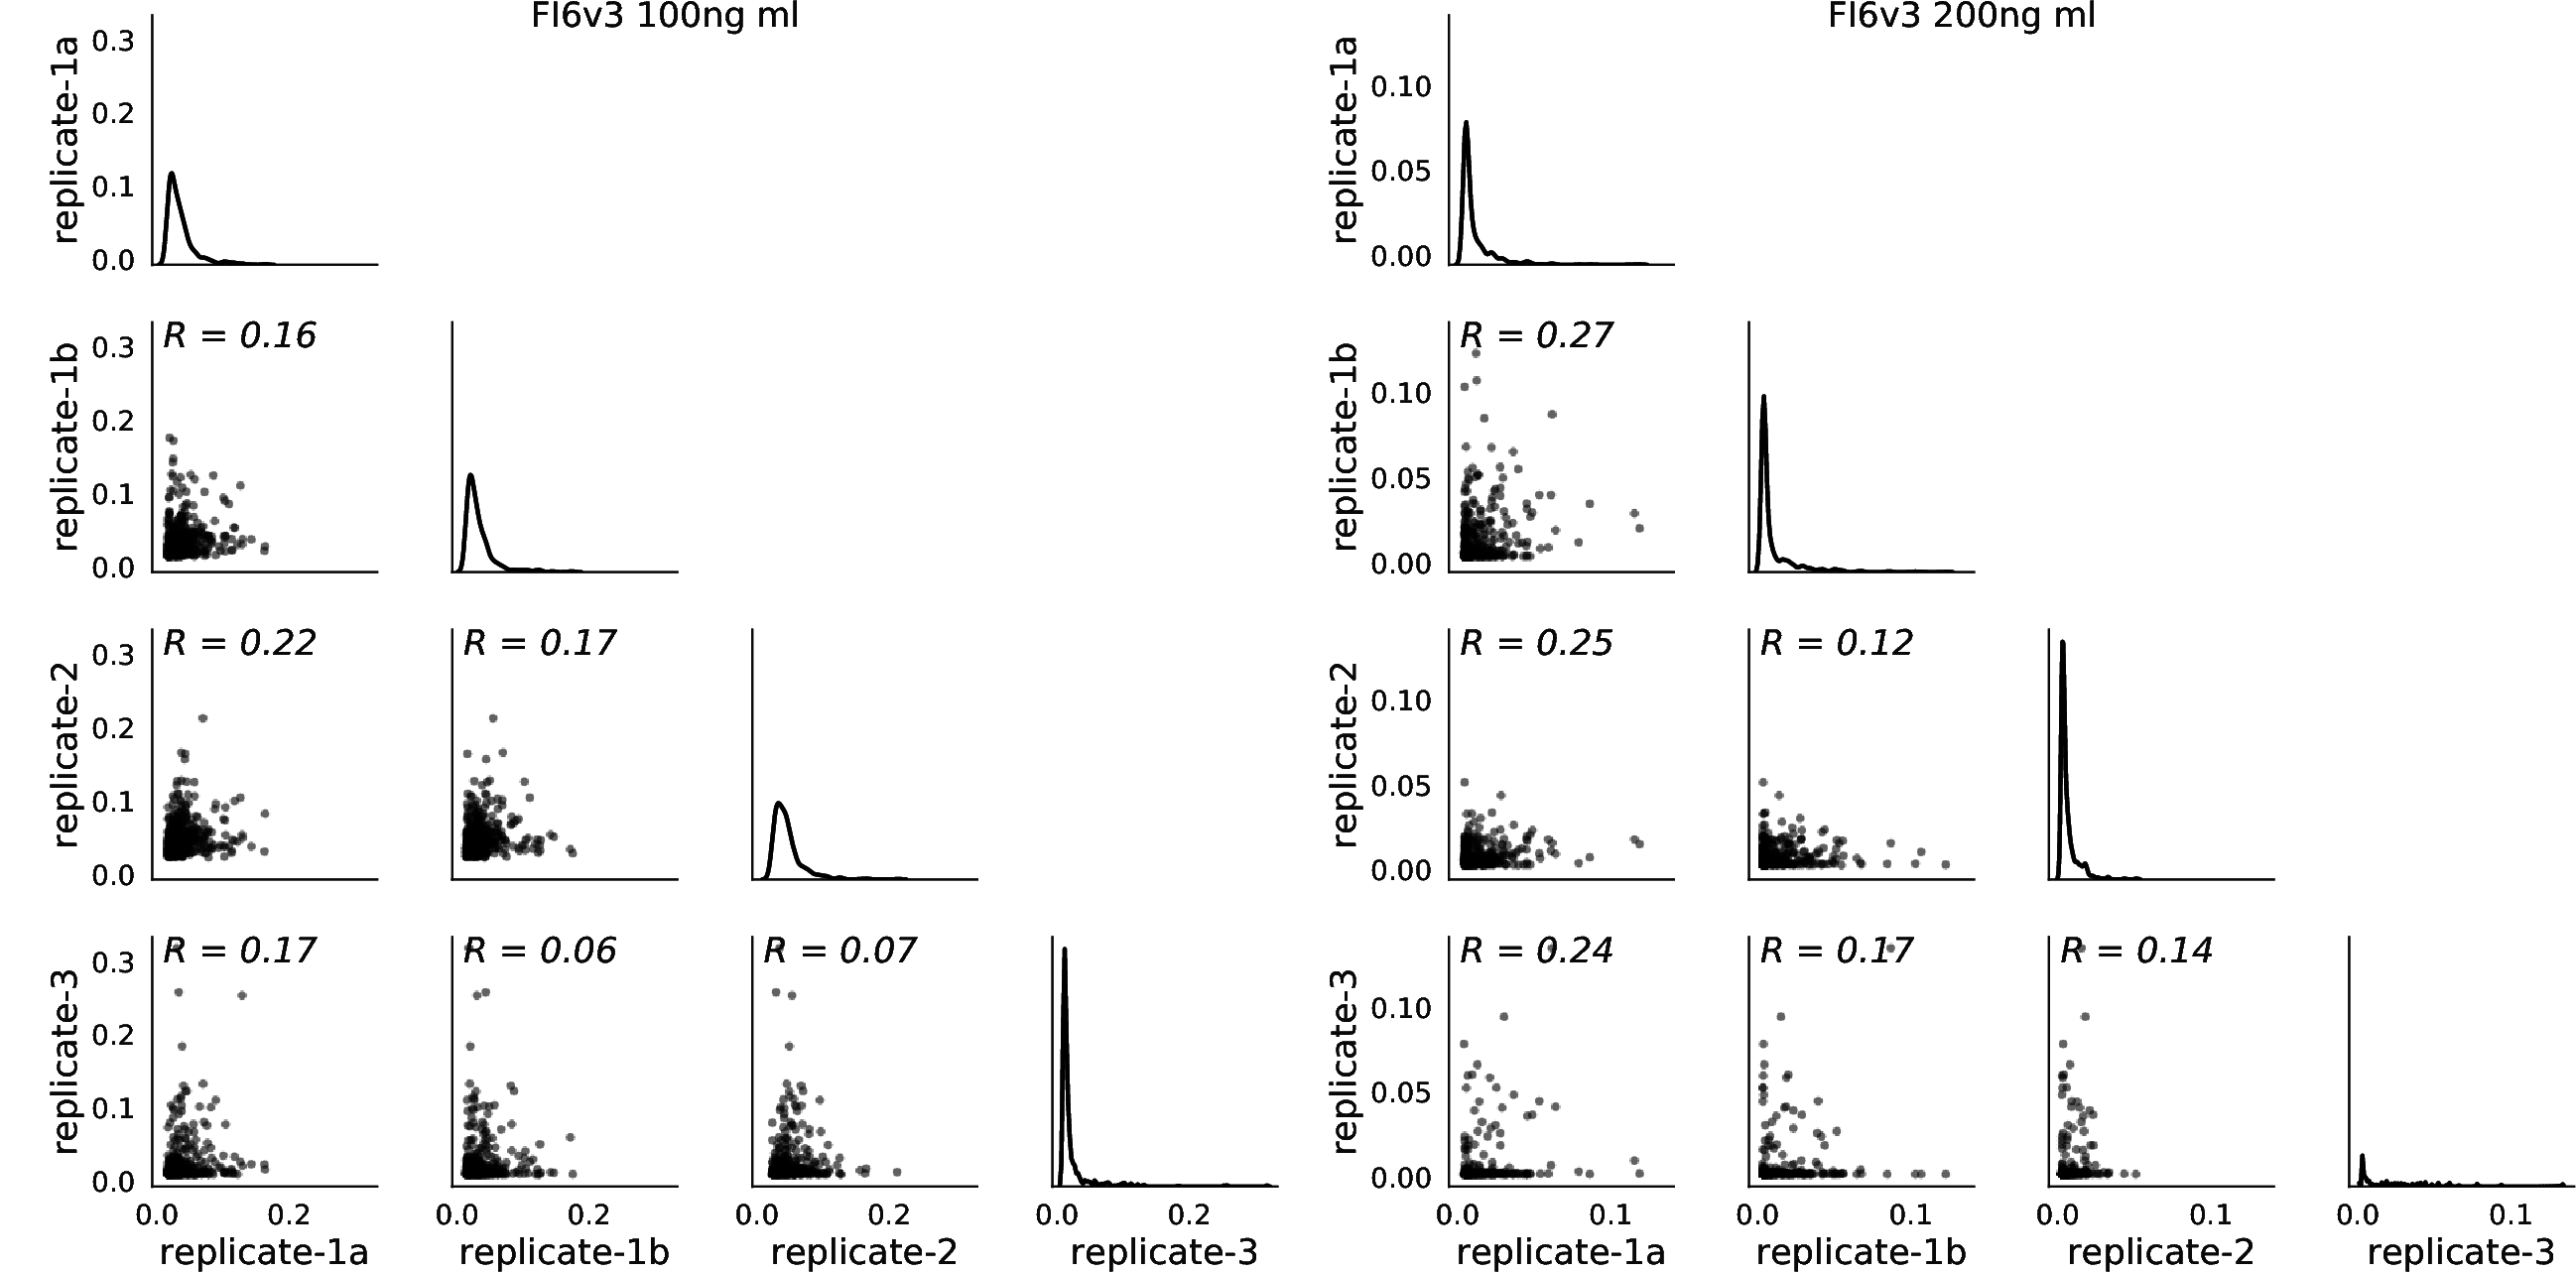

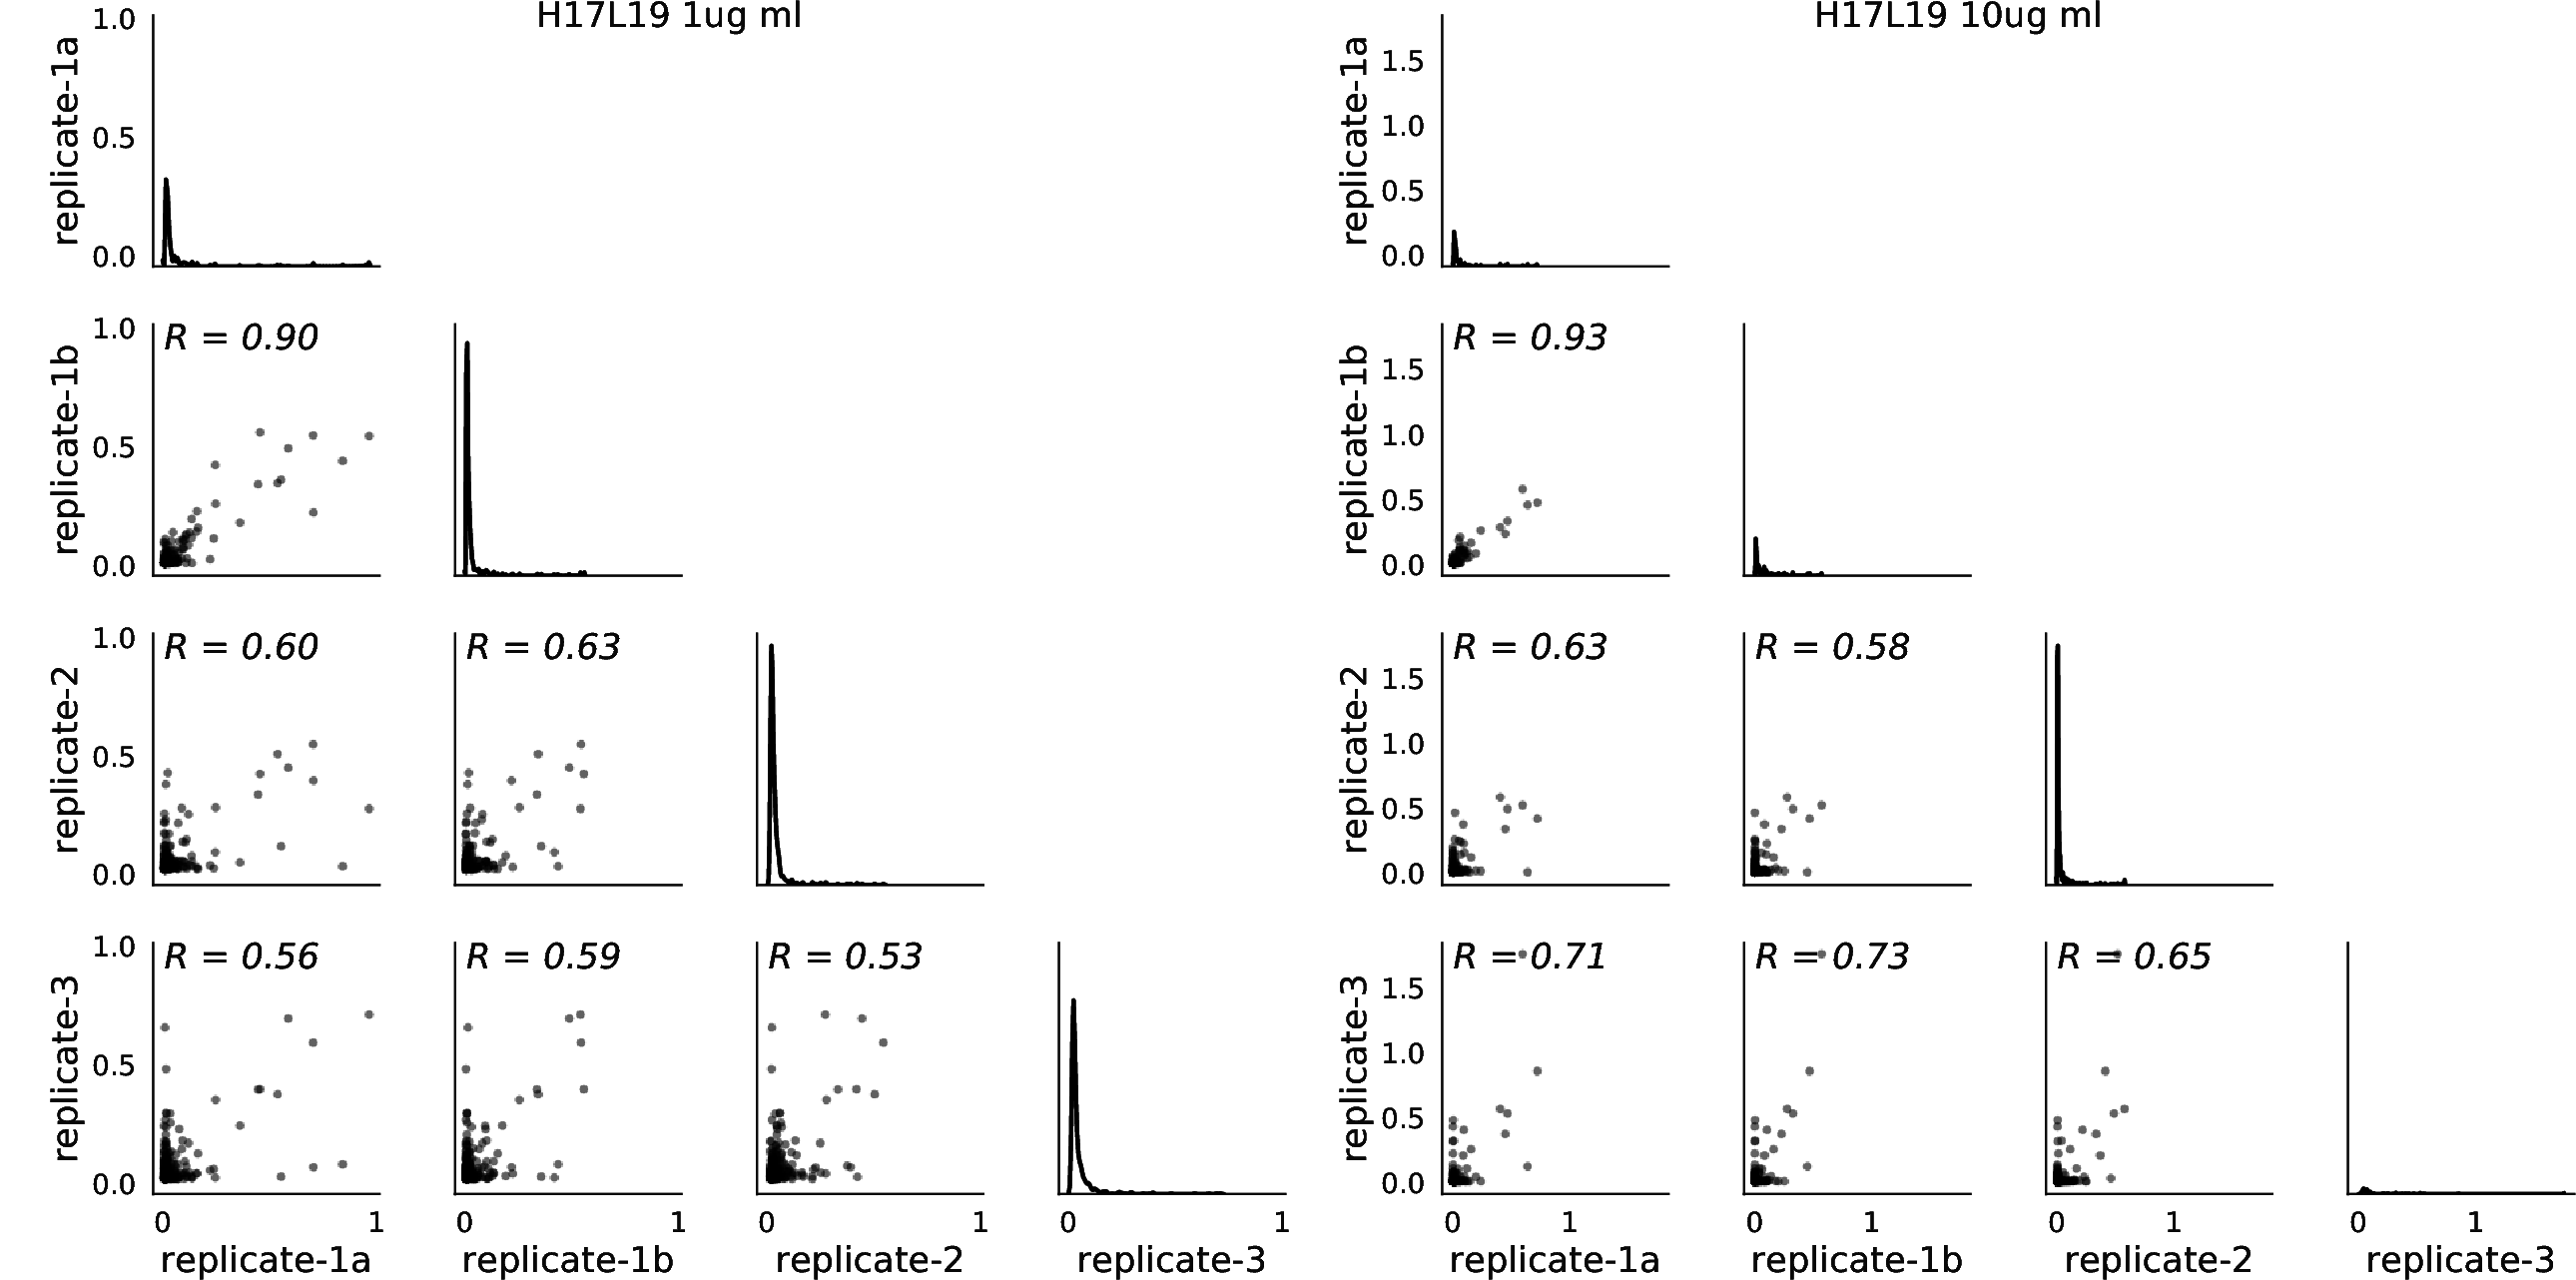


avgfracsurvive correlations:


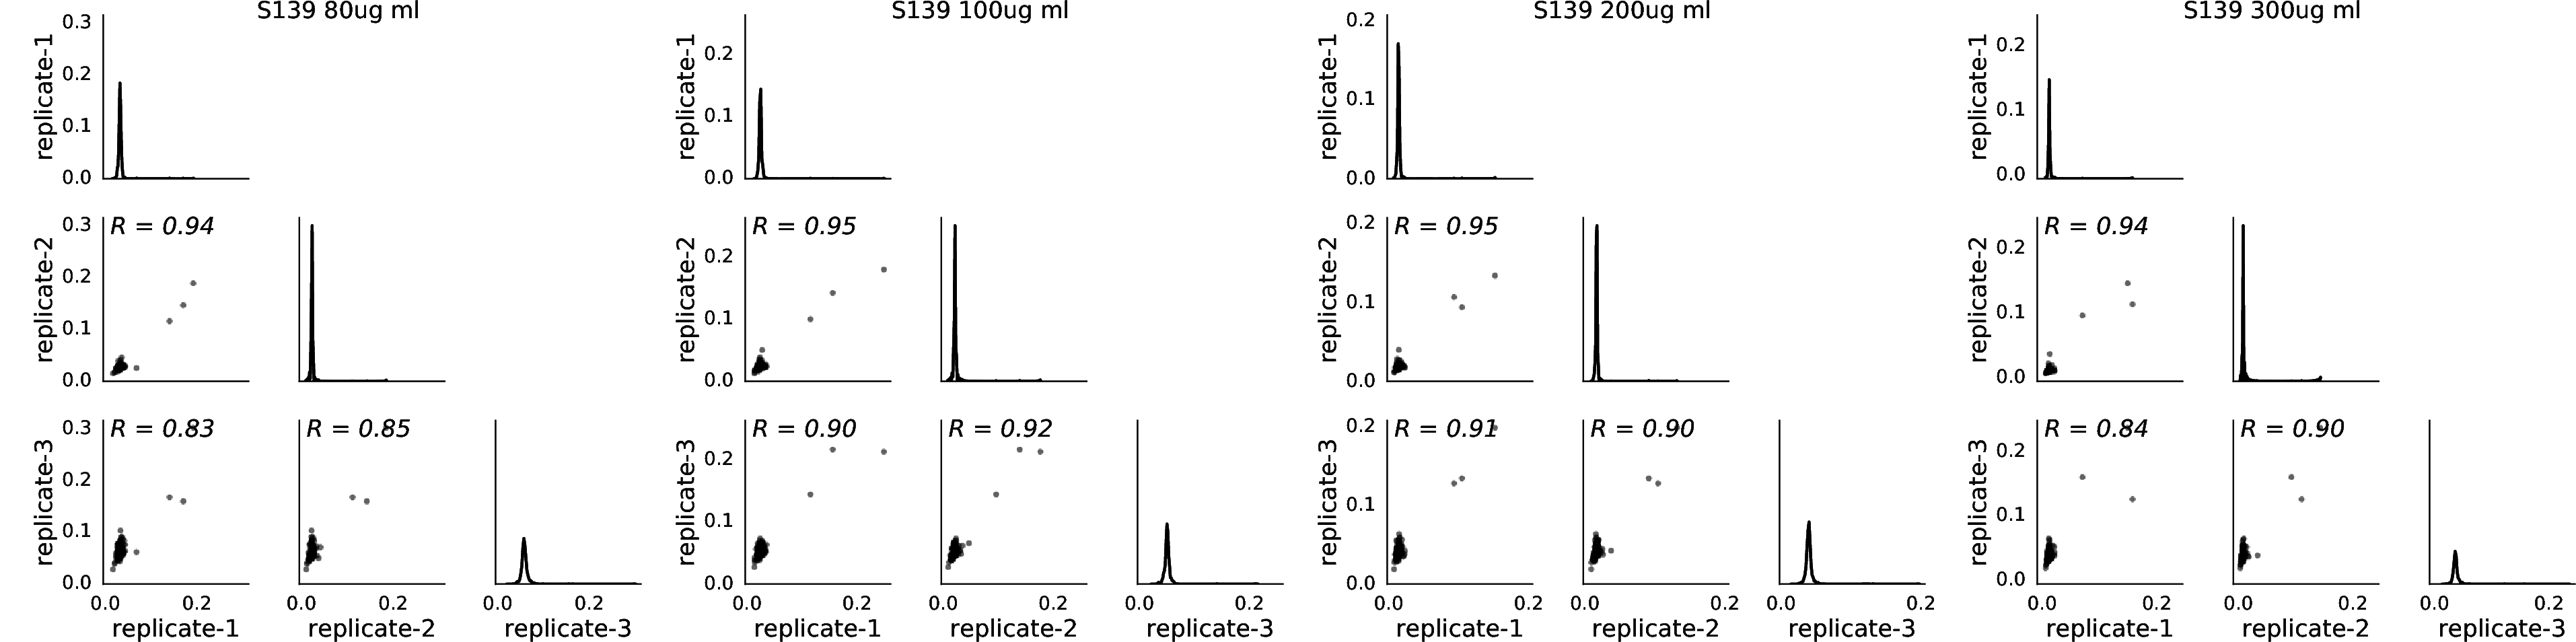

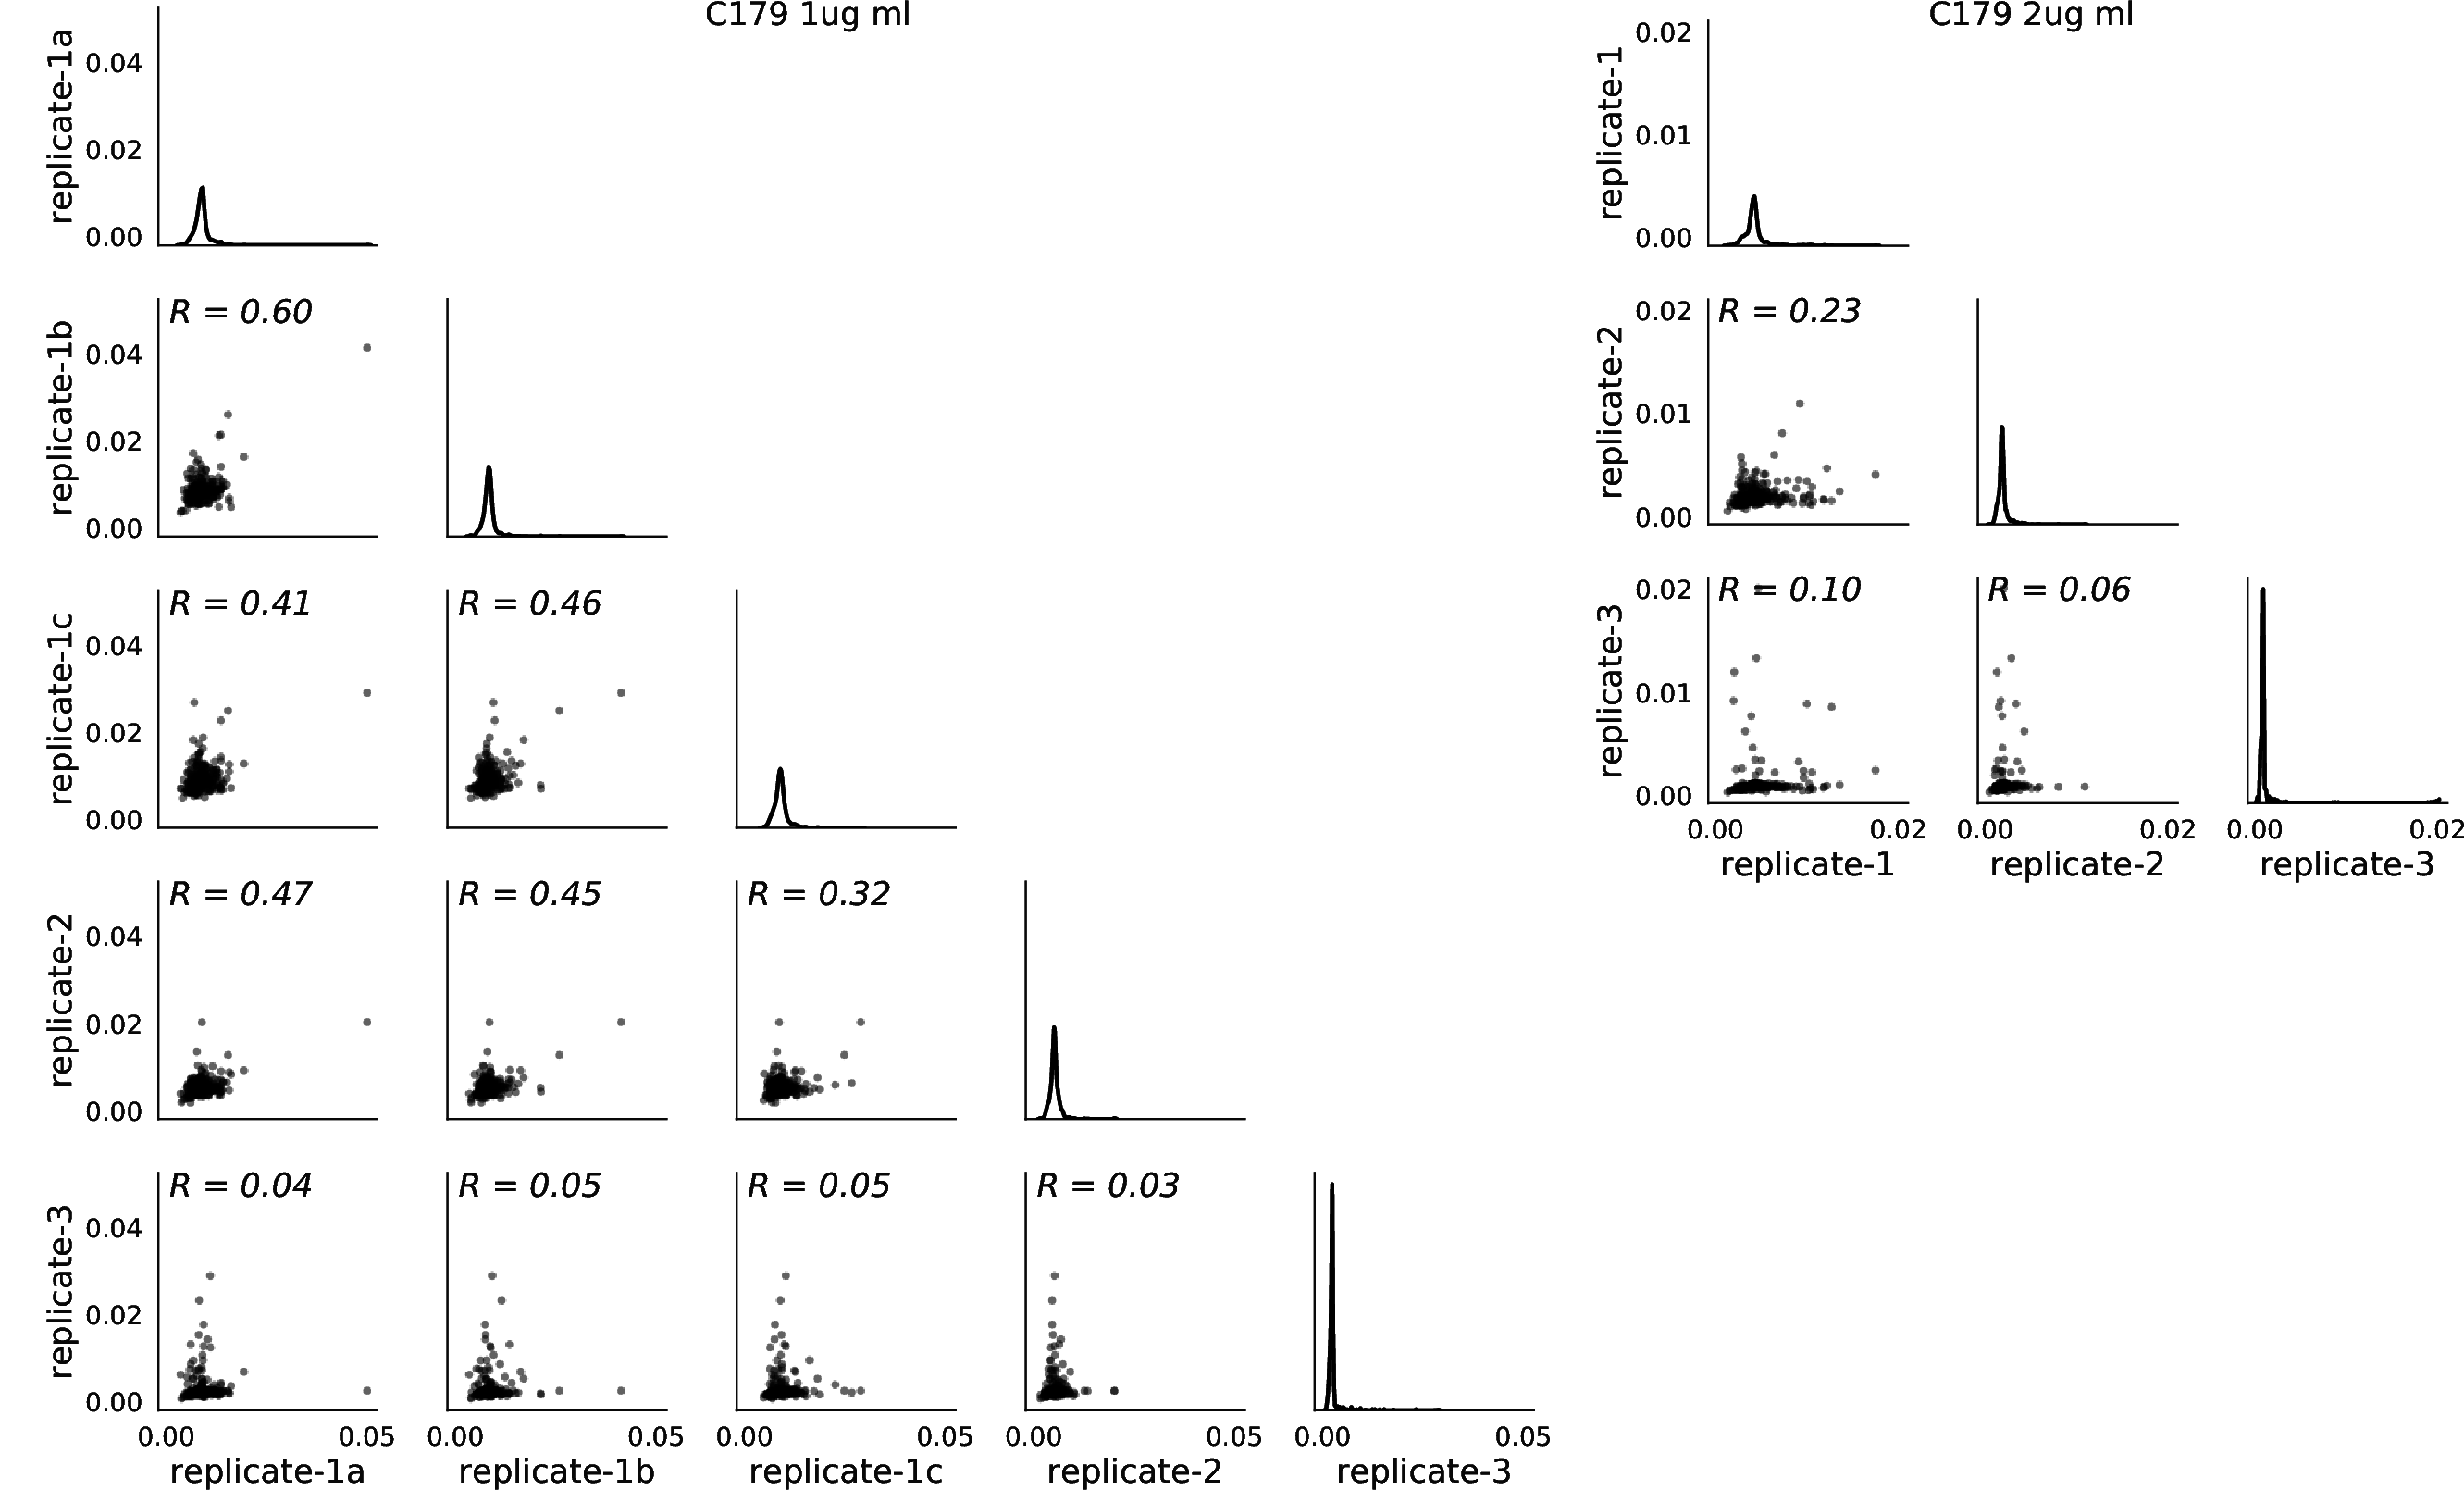

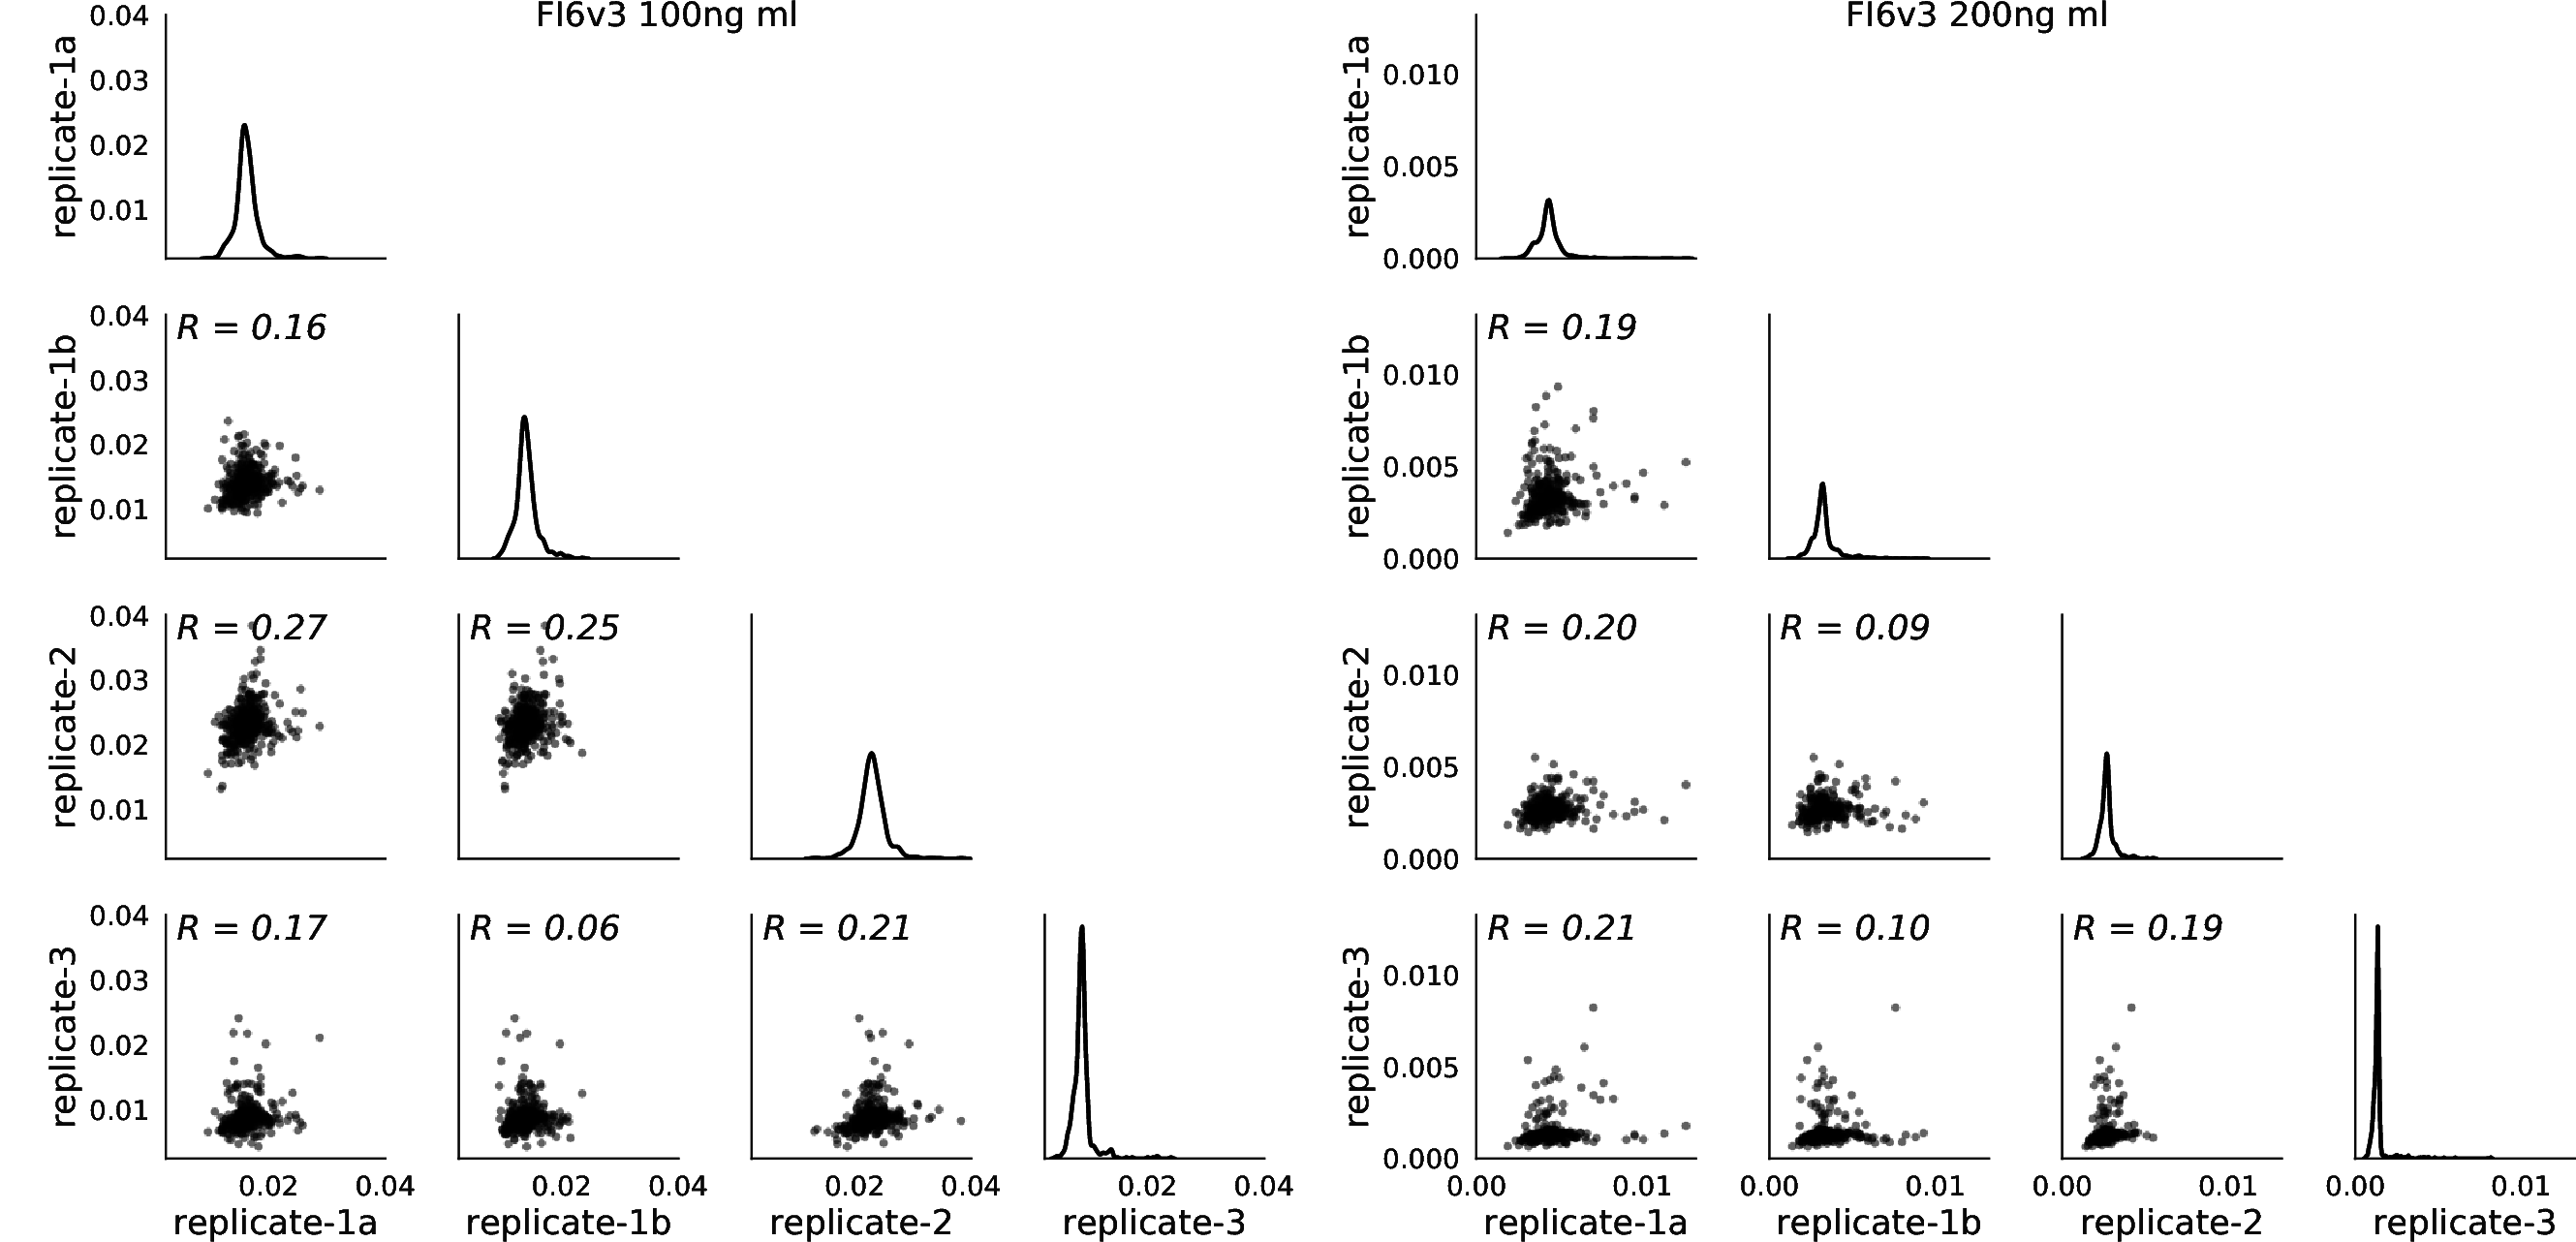

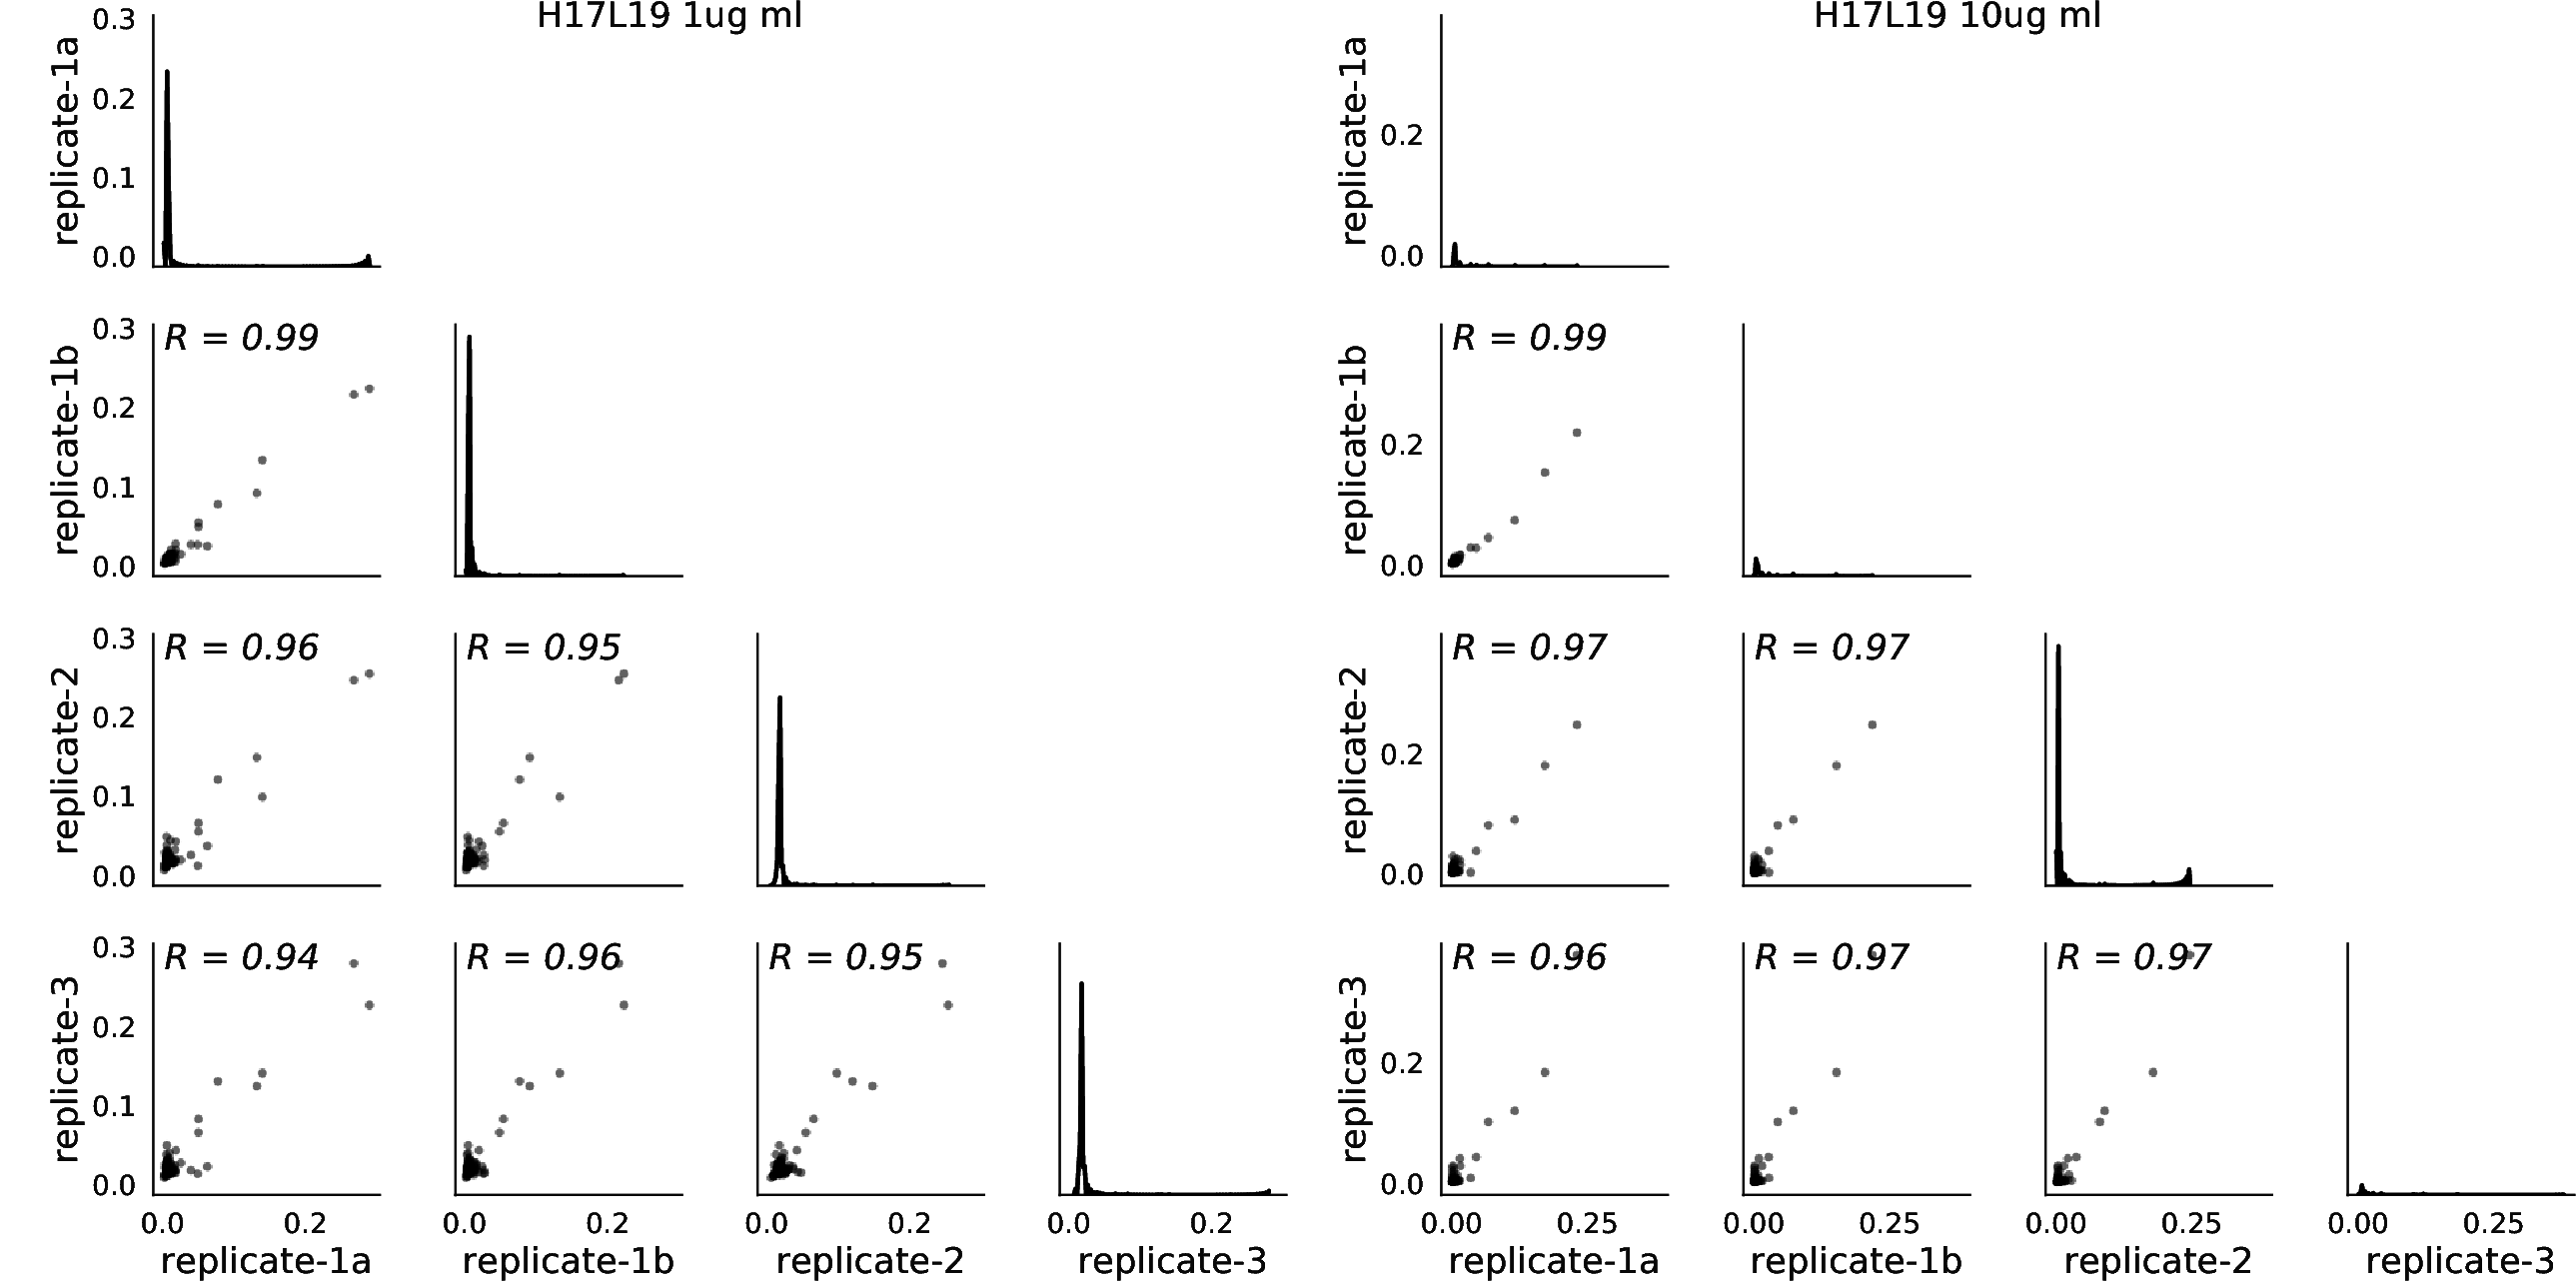

In [80]:
fracsurviveprefix = os.path.join(fracsurvivedir, 'summary_')
groups = fracsurvivebatch['group'].unique()

for fractype in ['maxfracsurvive', 'avgfracsurvive']:
    print("\n{0} correlations:".format(fractype))
    plots = []
    for g in groups:
        plot = fracsurviveprefix + g + '-' + fractype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots[ : 4]) # show S139/1 plots
    showPDF(plots[4 : 6]) # show C179 plots
    showPDF(plots[6 : 8], width=800) # show FI6v3 plots
    showPDF(plots[8 : ], width=800) # show H17L19 plots

### Show summary plots of fraction surviving as a function of primary sequence

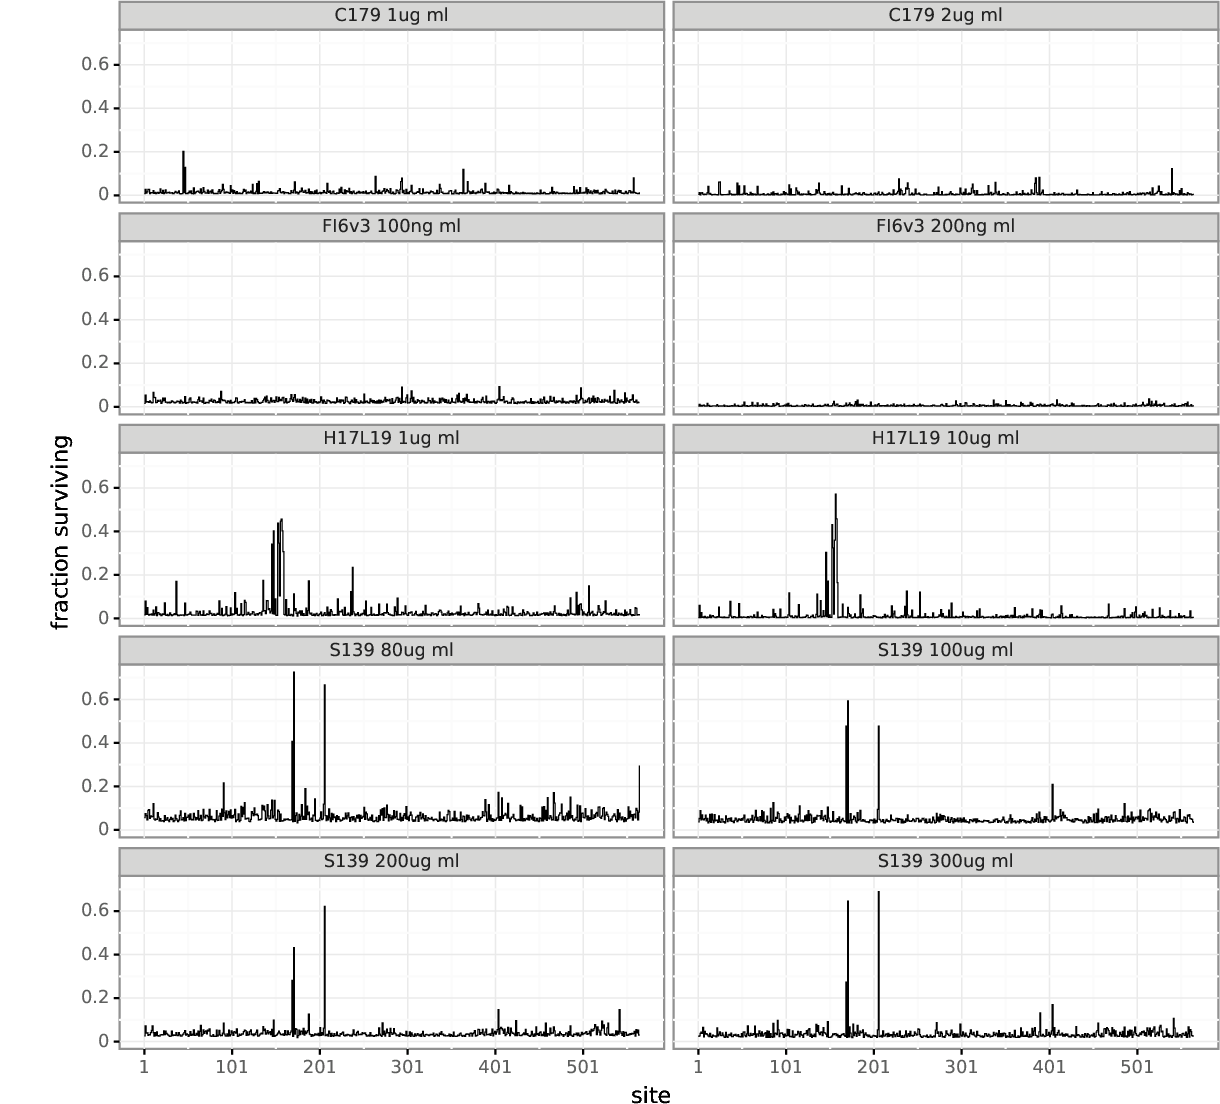

In [81]:
showPDF(fracsurviveprefix + 'meanmaxfracsurvive.pdf')

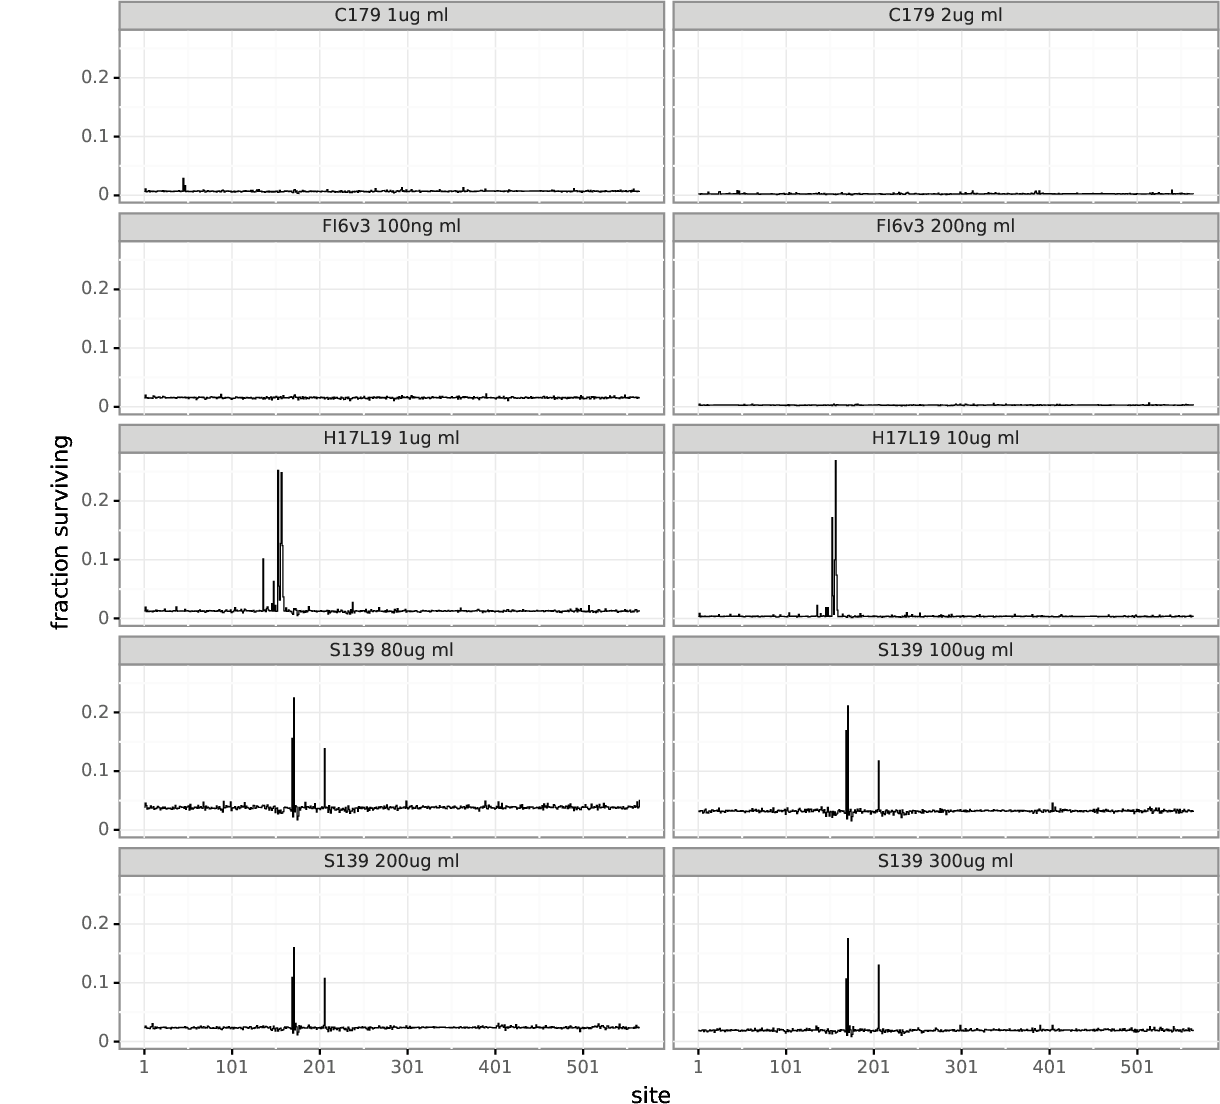

In [82]:
showPDF(fracsurviveprefix + 'meanavgfracsurvive.pdf')

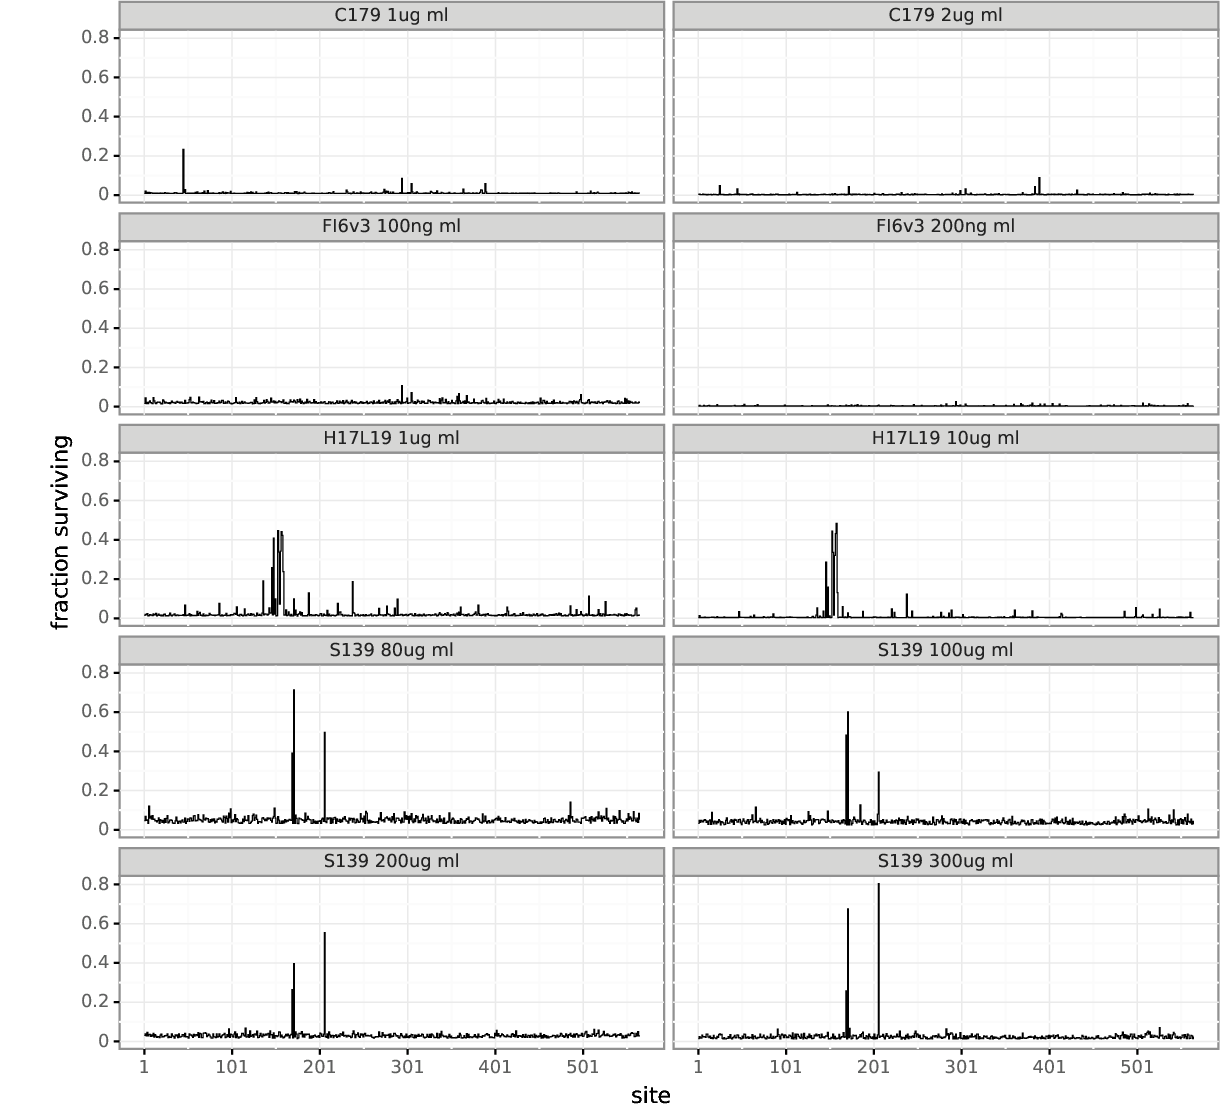

In [83]:
showPDF(fracsurviveprefix + 'medianmaxfracsurvive.pdf')

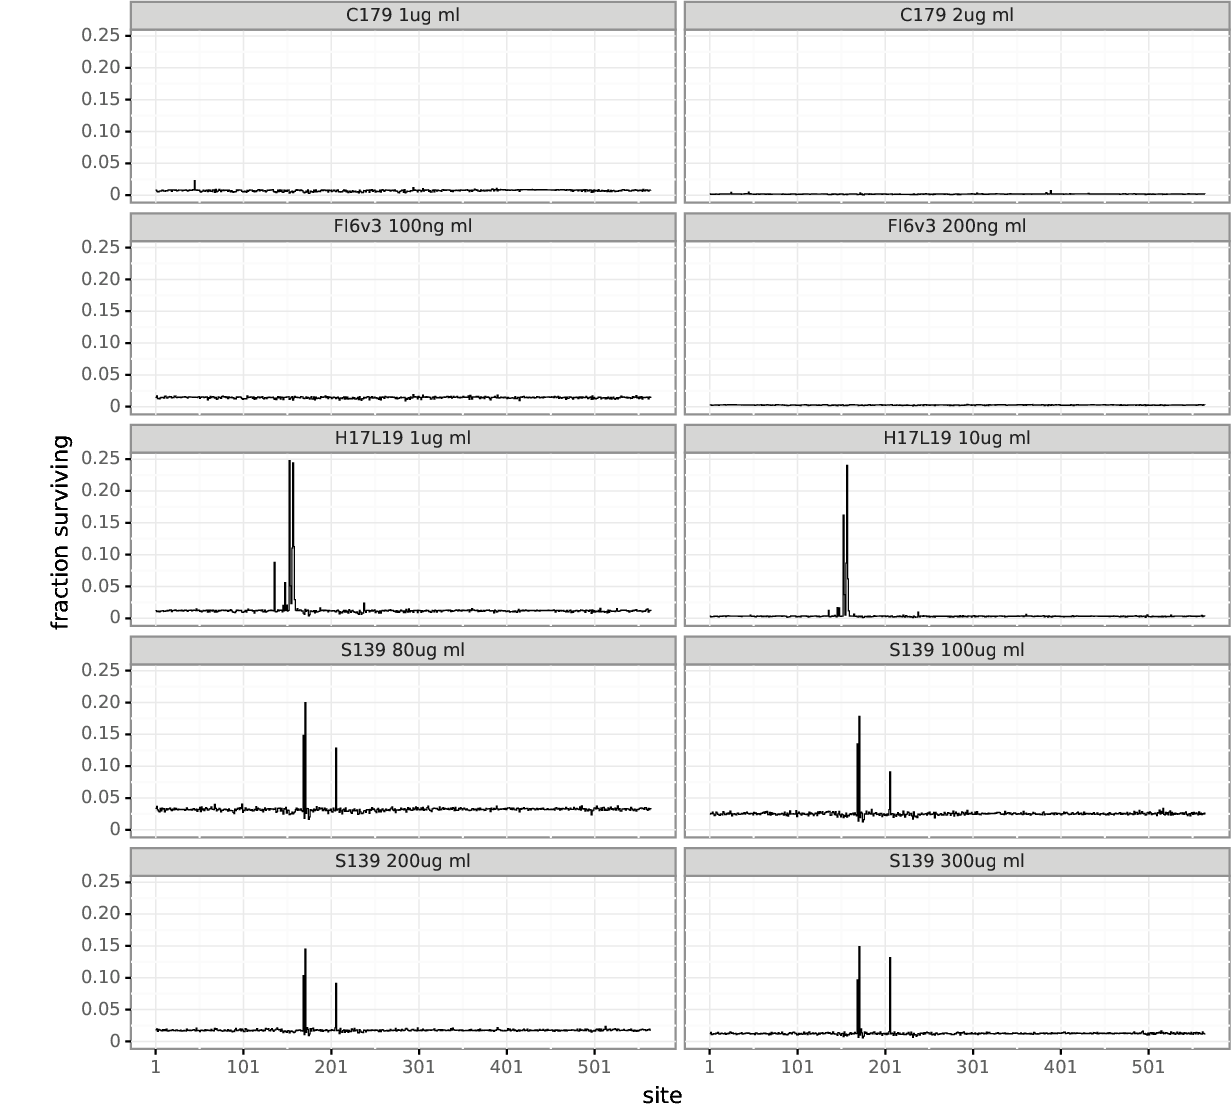

In [84]:
showPDF(fracsurviveprefix + 'medianavgfracsurvive.pdf')

When considering the median summary plots above, a couple things are clear. First the mutation with the maximum fraction surviving has a much higher fraction surviving selections with either S139/1 or H17-L19 compared to those mutations surviving C179 or FI6v3. In addition, for the maximum fraction surviving reaches **very** high proportions (~70-80%!) for some mutants after selection with S139/1. This is even higher than what is seen for the mutant with the maximum fraction surviving after selection with H17-L19, which seems to reach ~45-50% escape. Although S139/1 is considered to have "broadly-neutralizing" activity and H17-L19 is thought to be more strain-specific, these results seem to suggest that breadth and ease of escape are not necessarily related properties.

When comparing C179 vs FI6v3, a few mutations that confer escape from C179 reach higher fractions of escape than those fractions reached by escape mutations from FI6v3. Therefore, escape mutations from C179 seem have slightly higher effect sizes and have better "escape potential" than escape mutations from FI6v3.

The median average fraction surviving is consistent with the general observations above. First, on average, escape mutations from S139/1 or from H17-L19 reach higher fractions surviving than those mutations escaping from C179 or FI6v3. In essence, escape mutations from these two stalk-targeting antibodies are smaller in effect size and have less "escape potential" compared to escape mutations from these two head-targeting antibodies. Furthermore, antibody breadth does not necessarily reflect difficulty of escape from that antibody. As can be seen, the average mutation surviving selection with the bnAb S139/1 reaches a similar fraction survivng as the average mutation surviving selection with the (putatively) strain-specific H17-L19.

### Make logoplots using `fracsurvive`

In [ ]:
known = pd.read_csv('./data/known_escape.csv', index_col='site')

for antibody in ['S139-300ug-ml', 'S139-200ug-ml']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # create known sites overlay file to pass to dms2_logoplot
    sites = pd.read_csv(mutdiffsel)['site'].unique()
    antibodyname = antibody.split('-')[0]
    knownsites = diffselprefix + '{0}_known_escape.csv'.format(antibodyname)
    (known.query('antibody == @antibodyname')
          .assign(esc='yes')
          .reindex(sites) # add entry for sites NOT known to mediate escape
          .reset_index()
          .drop_duplicates('site')
          .fillna('not tested')
          .to_csv(knownsites, index=False)
          )
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(plotsdir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {plotsdir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 5 \
            --nperline 113 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {knownsites} esc "site of known escape mutation" \
            --underlay yes \
            --overlaycolormap plasma \
            --use_existing {use_existing}
    showPDF(logoplot)

## Make pymol scripts to map differential selection onto `1RVX pdb` structure

In [31]:
colors = ('#fafafa', '#ff0000')

diffselfile = ['{0}/summary_S139-2000-nM-mediansitediffsel.csv'.format(diffseldir), 
               '{0}/summary_C179-mediansitediffsel.csv'.format(diffseldir), 
               '{0}/summary_FI6v3-mediansitediffsel.csv'.format(diffseldir)]
scriptf = ['{0}/S139-2000-nM-mediansitediffsel.py'.format(pymoldir), 
           '{0}/C179-mediansitediffsel.py'.format(pymoldir), 
           '{0}/FI6v3-mediansitediffsel.py'.format(pymoldir)]

for x in range(len(diffselfile)):
    MapDiffselColorToSite(diffselfile[x], scriptf[x], script_type='pymol', 
                          map_type='positive_diffsel', colors = colors, sitecolorfile=None,
                          script_preamble=False, restrict_to_chain=False, prefsfile=None)